# `AVDOS-VR` - Virtual Reality Affective Video Database with Physiological Signals

Check `1_preprocess...ipynb` to see details on how to use the scripts to generate a preprocessed dataset compatible with this notebook.

This notebook takes a single postprocessed file `Dataset_AVDOSVR_full_postprocessed.csv` to generate the statistical analysis and feature-based classification.

In [1]:
# Add files to sys.path
from pathlib import Path
import sys,os
this_path = None
try:    # WORKS WITH .py
    this_path = str(os.path.dirname(os.path.abspath(__file__)))
except: # WORKS WITH .ipynb
    this_path = str(Path().absolute())+"/" 
print("File Path:", this_path)

# Add the level up to the file path so it recognizes the scripts inside `avdosvr`
sys.path.append(os.path.join(this_path, ".."))

File Path: D:\AVDOS-VR\notebooks/


In [2]:
# Import classes
import avdosvr.preprocessing       # Generate dataset index, load files, and plots.

# Utils for generation of files and paths
from avdosvr.utils import files_handler

# Import data science libs
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
#matplotlib.rcParams['text.usetex'] = True
import seaborn as sns

# Statistical tests
import scipy.stats as stats
from scipy.stats import mannwhitneyu, f_oneway

# Preprocessing
import neurokit2 as nk

from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Feature based classification

from sklearn.base import clone
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso, RidgeClassifier
from sklearn.svm import LinearSVC, SVC

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Feature selection
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# from lime import lime_tabular

# Evaluation
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Turn off chained assignment warning
pd.options.mode.chained_assignment = None 

---
## Setup

Global variables and functions for file management

In [3]:
### General configuration

# Path to the participants' folder w.r.t this notebook's filepath
DATASET_ROOT_FOLDER = "../data/"

# Used to generate the path of temporary subfolders
NOTEBOOK_NAME = "2_affect"

In [4]:
# Functions to generate filepaths

# MAIN FOLDERS FOR OUTPUT FILES
ROOT = this_path + ""   # Root folder for all the files w.r.t this file
TEMP_FOLDER = ROOT+"temp/"  # Main folder for temp files with intermediate calculations
RESULTS_FOLDER = ROOT+"results/"    # Folder to recreate plots and results from analyses

EXPORT_PLOTS = True
IMG_FORMAT = ".pdf"

# Generates paths for files created from this script

def gen_path_plot(filename, extension=IMG_FORMAT):
    # Generates full paths for PLOTS just by specifying a name
    return files_handler.generate_complete_path(filename, \
                                        main_folder=RESULTS_FOLDER, \
                                        subfolders=NOTEBOOK_NAME+"/plots/", \
                                        file_extension=extension, save_files=EXPORT_PLOTS)

def gen_path_temp(filename, extension, subfolders=""):
    # Generates full paths for TEMP FILES just by specifying a name
    return files_handler.generate_complete_path(filename, \
                                        main_folder=TEMP_FOLDER, \
                                        subfolders=NOTEBOOK_NAME+"/"+subfolders, \
                                        file_extension=extension)

def gen_path_results(filename, subfolders="", extension=""):
    # Generates full paths for RESULTS FILES (like pandas dataframes)
    return files_handler.generate_complete_path(filename, \
                                        main_folder=RESULTS_FOLDER, \
                                        subfolders=NOTEBOOK_NAME+"/"+subfolders, \
                                        file_extension=extension)

---

## Analysis 1: Validation of Subjective Self-reported Measures

### Plotting Valence-Arousal ratings per video across all data from participants

*Conclusion from statistical tests and plot:*
- It shows how the video categories: `Negative` and `Positive` can be discriminated from the Valence component, but not from the arousal. As expected.
- The categories in Valence may be used as ground-truth for the ML task. But not the presumed labels in Arousal.

In [5]:
# The preprocessing manager analyzes the original data folder
# to create an index and facilitate preprocessing.
data_loader = avdosvr.preprocessing.Manager(DATASET_ROOT_FOLDER, index_files_path = TEMP_FOLDER)

Index already exists: Loading from  D:\AVDOS-VR\notebooks/temp/avdosvr_index/avdosvr_tree_index.json
Participant 0 with folder id: 101 was part of protocol: v1
Participant 1 with folder id: 216 was part of protocol: v1
Participant 2 with folder id: 219 was part of protocol: v1
Participant 3 with folder id: 222 was part of protocol: v1
Participant 4 with folder id: 247 was part of protocol: v1
Participant 5 with folder id: 248 was part of protocol: v1
Participant 6 with folder id: 268 was part of protocol: v1
Participant 7 with folder id: 270 was part of protocol: v1
Participant 8 with folder id: 278 was part of protocol: v1
Participant 9 with folder id: 290 was part of protocol: v1
Participant 10 with folder id: 293 was part of protocol: v1
Participant 11 with folder id: 299 was part of protocol: v1
Participant 12 with folder id: 307 was part of protocol: v1
Participant 13 with folder id: 308 was part of protocol: v1
Participant 14 with folder id: 309 was part of protocol: v1
Participa

In [6]:
# Total participants
participants_ids = data_loader.summary["index_id"].unique()
participants_ids

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38], dtype=int64)

In [7]:
# Total sessions
experiment_segment_names = data_loader.summary["Segment"].unique()
experiment_segment_names

array(['video_1', 'video_2', 'video_3', 'video_4', 'video_5'],
      dtype=object)

In [8]:
# Merge the videoIds to each of the unaltered affective ratings
affect_ratings_matched_video_id = None
for participant in participants_ids:
    # Preparing dataframes to be merged
    df_em = data_loader.emotions[participant]
    df_seg = data_loader.segments[participant].drop("Session",axis=1) # Session is duplicated
    df_seg = df_seg[ df_seg["Trigger"] != "Start"] # To avoid errors when start and end are intertwined
    # Merging
    this_affect_ratings_merged = pd.merge_asof(df_em, df_seg, left_index=True, right_index=True, direction="forward")
    this_affect_ratings_merged.insert(0,"p_index_id",participant)
    this_affect_ratings_merged.insert(1,"participant_id",int(data_loader.index[participant]["participant_id"]))
    
    affect_ratings_matched_video_id = this_affect_ratings_merged if (affect_ratings_matched_video_id is None) else \
                                        pd.concat([affect_ratings_matched_video_id,this_affect_ratings_merged], axis=0, ignore_index=True)

# Show result
MATCHED_AFFECTIVE_RATINGS_FILENAME = gen_path_temp("AffectiveRatingsMatchedVideoId",extension=".csv")
affect_ratings_matched_video_id.to_csv( MATCHED_AFFECTIVE_RATINGS_FILENAME, index=False )

In [9]:
affect_ratings_matched_video_id.isna().sum()

p_index_id          0
participant_id      0
Session             0
Valence             0
Arousal             0
RawX                0
RawY                0
Segment            91
VideoId           396
Trigger            91
dtype: int64

The rows with `VideoId=NaN` mean that an affective ratings was generated outside the valid experimental segments. Valid segments are within the 120s-long resting stage or the 300s-long videos

In [10]:
affect_ratings_matched_video_id

,p_index_id,participant_id,Session,Valence,Arousal,RawX,RawY,Segment,VideoId,Trigger
0,0,101,video_1,3,5,94,124,Positive,NaN,StartSegment
1,0,101,video_2,5,5,128,122,Positive,-1.0,End
2,0,101,video_2,6,5,149,127,Positive,-1.0,End
3,0,101,video_2,7,5,170,127,Positive,-1.0,End
4,0,101,video_2,8,5,193,126,Positive,-1.0,End
...,...,...,...,...,...,...,...,...,...,...
41295,38,384,video_5,6,2,154,74,video_5,-1.0,End
41296,38,384,video_5,5,2,147,70,video_5,-1.0,End
41297,38,384,video_5,5,3,146,71,video_5,-1.0,End
41298,38,384,video_5,6,3,148,81,video_5,-1.0,End


In [11]:
affect_ratings_matched_video_id.dropna(axis=0, subset=["VideoId"], inplace=True)
affect_ratings_matched_video_id

,p_index_id,participant_id,Session,Valence,Arousal,RawX,RawY,Segment,VideoId,Trigger
1,0,101,video_2,5,5,128,122,Positive,-1.0,End
2,0,101,video_2,6,5,149,127,Positive,-1.0,End
3,0,101,video_2,7,5,170,127,Positive,-1.0,End
4,0,101,video_2,8,5,193,126,Positive,-1.0,End
5,0,101,video_2,7,5,191,125,Positive,-1.0,End
...,...,...,...,...,...,...,...,...,...,...
41294,38,384,video_5,6,3,155,100,video_5,-1.0,End
41295,38,384,video_5,6,2,154,74,video_5,-1.0,End
41296,38,384,video_5,5,2,147,70,video_5,-1.0,End
41297,38,384,video_5,5,3,146,71,video_5,-1.0,End


In [12]:
# Keep the data from affect segments (excluding `video_1` and `video_5`) corresponding to resting stages.
Q = ( (affect_ratings_matched_video_id["Segment"]=="Positive") | \
        (affect_ratings_matched_video_id["Segment"]=="Negative") | \
        (affect_ratings_matched_video_id["Segment"]=="Neutral") | \
        (affect_ratings_matched_video_id["Segment"]=="video_5"))
affect_ratings_matched_video_id = affect_ratings_matched_video_id[ Q ]
affect_ratings_matched_video_id

,p_index_id,participant_id,Session,Valence,Arousal,RawX,RawY,Segment,VideoId,Trigger
1,0,101,video_2,5,5,128,122,Positive,-1.0,End
2,0,101,video_2,6,5,149,127,Positive,-1.0,End
3,0,101,video_2,7,5,170,127,Positive,-1.0,End
4,0,101,video_2,8,5,193,126,Positive,-1.0,End
5,0,101,video_2,7,5,191,125,Positive,-1.0,End
...,...,...,...,...,...,...,...,...,...,...
41294,38,384,video_5,6,3,155,100,video_5,-1.0,End
41295,38,384,video_5,6,2,154,74,video_5,-1.0,End
41296,38,384,video_5,5,2,147,70,video_5,-1.0,End
41297,38,384,video_5,5,3,146,71,video_5,-1.0,End


In [13]:
# Replace the resting videoId with text for plot
affect_ratings_matched_video_id = affect_ratings_matched_video_id.astype({"VideoId":int})
# Resting in positive segment
Q = ( (affect_ratings_matched_video_id["Segment"]=="Positive") & (affect_ratings_matched_video_id["VideoId"]==-1) )
affect_ratings_matched_video_id.loc[Q,"VideoId"]="R+"
# Resting in positive segment
Q = ( (affect_ratings_matched_video_id["Segment"]=="Neutral") & (affect_ratings_matched_video_id["VideoId"]==-1) )
affect_ratings_matched_video_id.loc[Q,"VideoId"]="Rn"
# Resting in positive segment
Q = ( (affect_ratings_matched_video_id["Segment"]=="Negative") & (affect_ratings_matched_video_id["VideoId"]==-1) )
affect_ratings_matched_video_id.loc[Q,"VideoId"]="R-"
# Resting in final end segment
Q = ( (affect_ratings_matched_video_id["Segment"]=="video_5") & (affect_ratings_matched_video_id["VideoId"]==-1) )
affect_ratings_matched_video_id.loc[Q,"VideoId"]="R-end"

In [14]:
# Calculate and save total and mean number of ratings per video
NUMBER_OF_RATINGS_FILENAME = gen_path_results("2_NumberOfRatingsPerVideoID", extension=".csv")
df_number_of_ratings = pd.DataFrame(affect_ratings_matched_video_id["VideoId"].value_counts().index.array,columns=['VideoId'])
df_number_of_ratings['TotalRatings'] = affect_ratings_matched_video_id["VideoId"].value_counts().values
df_number_of_ratings['MeanRatings'] = df_number_of_ratings['TotalRatings']/len(participants_ids)
#df_number_of_ratings = df_number_of_ratings.sort_values(by=['TotalRatings'],ascending=False).reset_index(drop=True)
df_number_of_ratings.to_csv( NUMBER_OF_RATINGS_FILENAME, index=False)
df_number_of_ratings


,VideoId,TotalRatings,MeanRatings
0,Rn,3131,80.282051
1,R-end,3042,78.000000
2,R+,2949,75.615385
3,R-,2421,62.076923
4,10,1305,33.461538
5,12,1208,30.974359
6,3,1182,30.307692
7,5,1123,28.794872
8,20,1108,28.410256
9,51,1095,28.076923


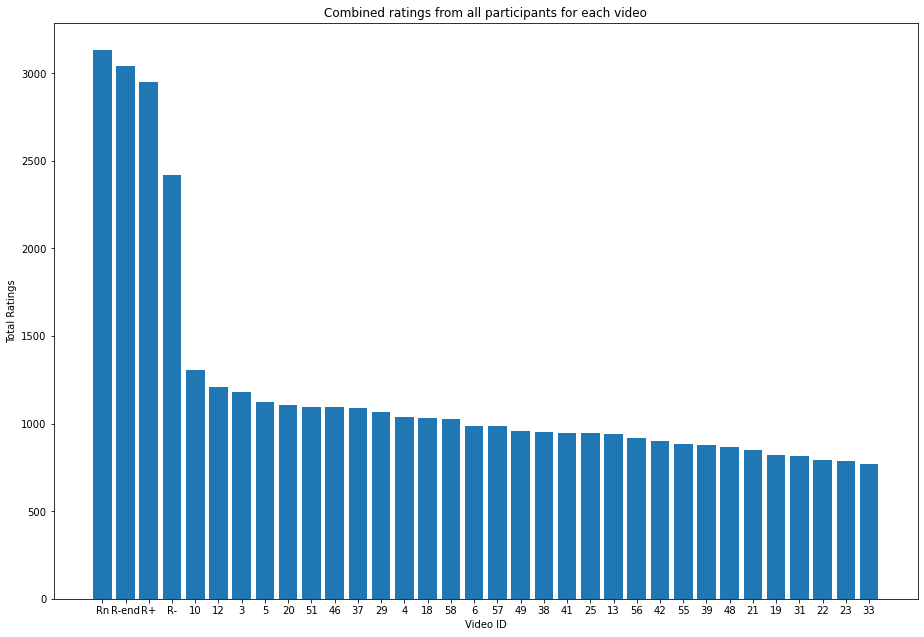

In [15]:
# Total Number of ratings per videoID
fig = plt.figure()
ax = fig.add_axes([0,0,2,2])
ax.bar(df_number_of_ratings['VideoId'].astype(str),df_number_of_ratings['TotalRatings'].values)
plt.xlabel('Video ID') 
plt.ylabel('Total Ratings') 
plt.title("Combined ratings from all participants for each video")
save_path_plot = gen_path_plot("combined-total-ratings-per-video")
plt.savefig(save_path_plot,bbox_inches='tight')
plt.show()

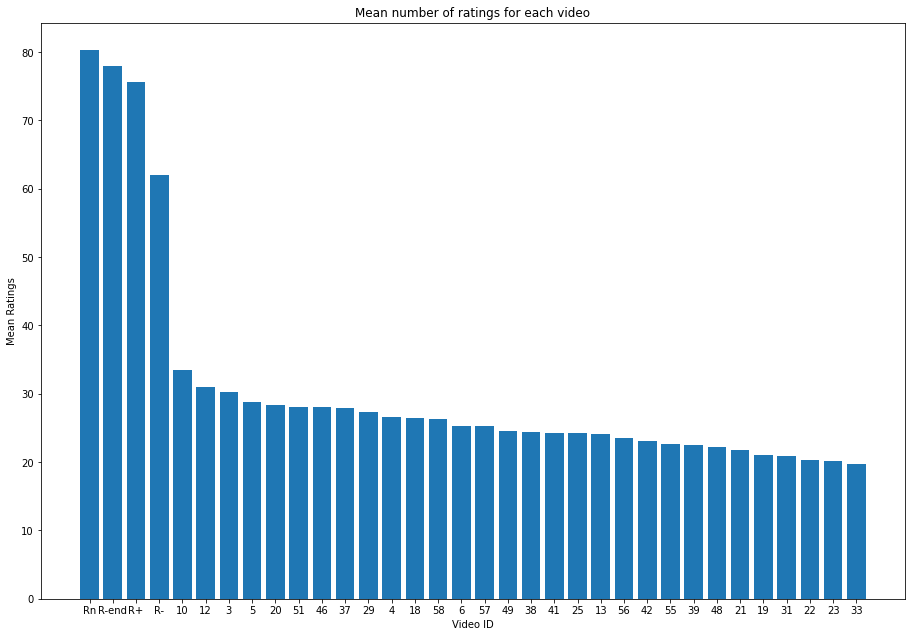

In [16]:
# Mean number of ratings per videoID
fig = plt.figure()
ax = fig.add_axes([0,0,2,2])
ax.bar(df_number_of_ratings['VideoId'].astype(str),df_number_of_ratings['MeanRatings'].values)
plt.xlabel('Video ID') 
plt.ylabel('Mean Ratings') 
plt.title("Mean number of ratings for each video")
save_path_plot = gen_path_plot("mean-number-of-ratings-per-video")
plt.savefig(save_path_plot,bbox_inches='tight')
plt.show()

In [17]:
# Average ratings per video
df_results_avg_affect_per_video = affect_ratings_matched_video_id.groupby(['p_index_id','VideoId']).mean().reset_index()
df_results_avg_affect_per_video

,p_index_id,VideoId,participant_id,Valence,Arousal,RawX,RawY
0,0,3,101.0,1.000000,8.300000,45.800000,180.400000
1,0,4,101.0,1.000000,8.181818,57.909091,177.727273
2,0,5,101.0,1.111111,6.888889,34.888889,155.666667
3,0,6,101.0,2.588235,6.882353,89.764706,155.588235
4,0,10,101.0,1.555556,7.888889,69.555556,171.888889
...,...,...,...,...,...,...,...
1304,38,58,384.0,6.090909,6.727273,155.136364,152.863636
1305,38,R+,384.0,4.952381,4.753968,135.023810,117.936508
1306,38,R-,384.0,4.966292,1.719101,137.651685,54.943820
1307,38,R-end,384.0,4.584000,3.632000,128.856000,94.240000


In [18]:
matching_video_segment = affect_ratings_matched_video_id.groupby("VideoId").first()["Segment"]
matching_video_segment

VideoId
3        Negative
4        Negative
5        Negative
6        Negative
10       Negative
12       Negative
13       Negative
18       Negative
19       Negative
20       Negative
21        Neutral
22        Neutral
23        Neutral
25        Neutral
29        Neutral
31        Neutral
33        Neutral
37        Neutral
38        Neutral
39        Neutral
41       Positive
42       Positive
46       Positive
48       Positive
49       Positive
51       Positive
55       Positive
56       Positive
57       Positive
58       Positive
R+       Positive
R-       Negative
R-end     video_5
Rn        Neutral
Name: Segment, dtype: object

In [19]:
avg_aff = df_results_avg_affect_per_video.groupby(["VideoId"]).mean()[["Valence","Arousal"]].join(matching_video_segment).reset_index()
avg_aff["Segment"].iloc[ avg_aff["VideoId"].str.startswith("R").replace(np.nan, False) ] = "Rest"
avg_aff

,VideoId,Valence,Arousal,Segment
0,3,2.858676,6.805001,Negative
1,4,2.532670,6.754700,Negative
2,5,3.556403,5.430783,Negative
3,6,3.325207,5.828082,Negative
4,10,3.203849,6.745703,Negative
5,12,3.316940,6.232813,Negative
6,13,2.673257,6.653845,Negative
7,18,3.167135,5.549159,Negative
8,19,2.434176,5.642616,Negative
9,20,2.783039,6.825944,Negative


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


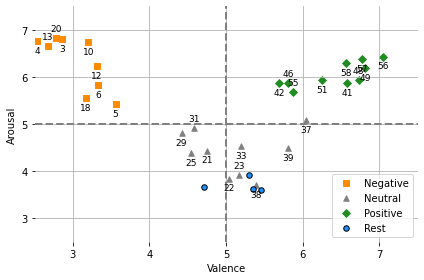

In [20]:
def generate_plot_affect_coordinates_ratings(df, ax):

    av_aff = df.copy()
    kwargs = {"Negative":{
                            "c":"darkorange", "marker":"s"
                            },
                    "Positive":{
                            "c":"forestgreen", "marker":"D"
                        },
                    "Neutral":{
                            "c":"grey", "marker":"^"
                        },
                    "Rest":{
                            "c":"dodgerblue", "marker":"o", "edgecolor":"k", "linewidths":1
                        }
                    }

    # colors = [kwargs[val]['c'] for val in avg_aff["Segment"]]
    # markers = [kwargs[val]['marker'] for val in avg_aff["Segment"]]
    # avg_aff.plot.scatter(ax=ax, x="Valence",y="Arousal",color=colors, markers=markers, legend=True)

    ax = plt.gca()
    # Plot
    offset_min = 2.5
    offset_max = 7.5
    ax.set(xlim=[offset_min,offset_max], ylim=[offset_min,offset_max])
    ax.set_xlabel("Valence")
    ax.set_ylabel("Arousal")
    # ax.set_title(f"Average Perceived Valence-Arousal ratings per video")

    ax.vlines([(offset_max+offset_min)/2], ymin=offset_min, ymax=offset_max, color="gray", linestyle='dashed', linewidth=2)
    ax.hlines([(offset_max+offset_min)/2], xmin=offset_min, xmax=offset_max, color="gray", linestyle='dashed', linewidth=2)
    ax.grid(True)
    ax.legend(loc="lower right")

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    for segment in av_aff["Segment"].unique():
        df_test = av_aff[ (av_aff["Segment"] == segment)]
        avg_V = df_test["Valence"] #((df_test.sum_RawX/df_test.N)-128)/256 # Normalized affect between 0-1
        avg_A = df_test["Arousal"] #((df_test.sum_RawY/df_test.N)-128)/256

        ax.scatter( avg_V, avg_A, label=segment, s=30, **kwargs[segment] ) #c=colors[segment], s=80, marker=markers[segment])

        for i, videoId in enumerate(df_test["VideoId"].values):
            avg_V = df_test["Valence"]
            avg_A = df_test["Arousal"]

            # Defines where to offset the annotations depending on how many neighbors are there
            offsetX = 0.2
            offsetY = 0.2

            offset_dict = {
                0: [0, -offsetY],
                1: [0, offsetY],
                2: [-offsetX, 0],
                3: [offsetX, 0]
            }
            # Define offset based on how many points are close to the value
            # np.random.seed(345)
            # offset_annotation = offset_dict[np.floor(np.random.randint(4))] #offset_dict[0] #offset_dict[np.floor(np.random.randint(4))]
            thresh = 0.2
            radius = np.sqrt(np.abs(avg_A.iloc[i] - avg_A.iloc[:i])**2 + (np.abs(avg_V.iloc[i] - avg_V.iloc[:i])**2))
            n_close_neighbors = (radius<thresh).sum()
            offset_annotation = offset_dict[n_close_neighbors]

            # Annotate
            if(segment != "Rest"):
                ax.annotate(videoId, (avg_V.iloc[i]+offset_annotation[0], 
                                    avg_A.iloc[i]+offset_annotation[1]), 
                                    fontsize=9, ha='center', va='center',
                                    color='k')  #kwargs[segment]["c"])
    
    ax.grid(True)
    ax.legend(loc="lower right")

    return ax

# Plotting how each video was rated among all self-reported datapoints across all 15 participants.
save_path_plot = gen_path_plot("affect-coordinates-ratings-per-video")

NUM_ROWS = 1
NUM_COLS = 1
fig,axes = plt.subplots(NUM_ROWS, NUM_COLS, sharex=False, sharey=True, figsize=(6*NUM_COLS, 4*NUM_ROWS))

axes = generate_plot_affect_coordinates_ratings(avg_aff, axes)

plt.tight_layout()
plt.savefig(save_path_plot)


### Statistical analysis tests

Validate whether the average self-reported **valence** and **arousal** ratings differ between video categories aiming to induce `Negative`, `Neutral`, and `Positive` affect.

**Method:** Shapiro-Wilk normality tests followed by a Friedman and post-hoc Wilcoxon signed-rank.

*Test 1*: $H_0: \mu_- \geq \mu_N$ | $H_1: \mu_- < \mu_N$

If $p<0.01$, we reject the null hypothesis that the mean **reported valence/arousal** in the `Negative` videos $\mu_-$ is *greater or equal*  than in the `Neutral` videos $\mu_N$

*Test 2*: $H_0: \mu_+ \leq \mu_N$ | $H_1: \mu_+ > \mu_N$

If $p<0.01$, we reject the null hypothesis that the mean **reported valence/arousal** in the `Positive` videos $\mu_-$ is *lower or equal* than in the `Neutral` videos $\mu_N$


**Conclusions**

We validated whether the average self-reported ratings in valence and arousal differed between the three affect segments. Raw joystick input (0-255) was used instead of the translated 1-9 values. The continuous self-ratings were grouped by participant to calculate mean arousal and valence ratings per segment for each participant. We start by using Shapiro-Wilk tests to check for normality in valence ratings. Negative and neutral valence ratings were normally distributed ($W(39)=0.970, p=0.385$ and $W(39)=0.976, p=0.547$ respectively). Positive valence ratings were not $W(39)=0.769, p<0.001$. Friedman test showed mean reported valence was significant different in all 3 segments ($X^2(2)=70.359, p<0.001$). Post-hoc Wilcoxon signed-rank tests for neutral vs negative, $Z=780, \; p<0.001$; positive vs neutral, $Z=740, \;  p<0.001$; positive vs negative, $Z=775, \;  p<0.001$).

Identical approach was applied to arousal ratings. Shapiro-Wilk tests showed only positive arousal ratings were normally distributed $W(39)=0.976, p=0.570$. Negative ($W(39)=0.943, p=0.049$) and neutral arousal ($W(39)=0.942, p=0.429$). Friedman test showed arousal ratings were likewise different in all 3 segments ($X^2(2)=45.282, p<0.001$). Post-hoc Wilcoxon signed-rank showed Arousal ratings for both negative and positive categories were significantly higher from the neutral category ($Z=768, \;  p<0.001$; $Z=771, p<0.001$ respectively). As expected, due to highly arousing nature of both positive and negative videos, there was no significant difference in arousal for negative and positive categories ($Z=243, \; p=0.981$).

In [21]:
affect_ratings_matched_video_id

,p_index_id,participant_id,Session,Valence,Arousal,RawX,RawY,Segment,VideoId,Trigger
1,0,101,video_2,5,5,128,122,Positive,R+,End
2,0,101,video_2,6,5,149,127,Positive,R+,End
3,0,101,video_2,7,5,170,127,Positive,R+,End
4,0,101,video_2,8,5,193,126,Positive,R+,End
5,0,101,video_2,7,5,191,125,Positive,R+,End
...,...,...,...,...,...,...,...,...,...,...
41294,38,384,video_5,6,3,155,100,video_5,R-end,End
41295,38,384,video_5,6,2,154,74,video_5,R-end,End
41296,38,384,video_5,5,2,147,70,video_5,R-end,End
41297,38,384,video_5,5,3,146,71,video_5,R-end,End


In [22]:
# Group self ratings by partipant and segment
X = affect_ratings_matched_video_id.copy()
X["VideoId"] = pd.Categorical(X["VideoId"], categories=X["VideoId"].unique(), ordered=False)
df_participant_segment_ratings = X.groupby(["p_index_id","Segment"]).mean().reset_index().set_index(["p_index_id"])
df_participant_segment_ratings

,Segment,participant_id,Valence,Arousal,RawX,RawY
p_index_id,,,,,,
0,Negative,101.0,2.470588,6.191176,82.139706,139.117647
0,Neutral,101.0,5.636364,4.895105,150.468531,119.776224
0,Positive,101.0,6.461538,5.851648,164.214286,137.983516
0,video_5,101.0,3.733333,1.000000,111.266667,20.266667
1,Negative,216.0,3.167641,6.231969,101.015595,144.970760
...,...,...,...,...,...,...
37,video_5,382.0,7.057143,1.600000,170.257143,67.800000
38,Negative,384.0,3.174157,4.820225,101.626404,115.921348
38,Neutral,384.0,4.043956,4.553114,119.597070,113.388278


In [23]:
# Generate DF with all participants and all videoIds (even if they have no ratings)
# result should be an array of 39 participants * 34 (30 videos, 10 per segment plus 4 relaxing videos) videos per segment = 1326
df_avg_per_participant_and_video = X.groupby(["p_index_id","VideoId"]).mean().reset_index().set_index(["VideoId"])
df_avg_per_participant_and_video

,p_index_id,participant_id,Valence,Arousal,RawX,RawY
VideoId,,,,,,
R+,0,101.0,6.632653,3.040816,165.285714,88.571429
51,0,101.0,4.666667,6.047619,133.142857,139.047619
49,0,101.0,7.400000,7.600000,174.550000,166.800000
46,0,101.0,6.800000,6.900000,171.400000,154.200000
41,0,101.0,7.666667,5.000000,189.333333,123.444444
...,...,...,...,...,...,...
22,38,384.0,3.470588,3.235294,109.058824,85.823529
39,38,384.0,4.533333,5.600000,127.800000,131.866667
23,38,384.0,5.157895,4.947368,142.368421,123.157895


**Valence**

We analyze `RawX` instead of `Valence` because it contains the raw reported values from the joystick and has not been quantisized in the `9-level` variable of valence.

In [24]:
# Extract valence ratings for each segment (negative, positive & neutral)
negative_valence = df_participant_segment_ratings['RawX'][df_participant_segment_ratings['Segment']=='Negative']
positive_valence = df_participant_segment_ratings['RawX'][df_participant_segment_ratings['Segment']=='Positive']
neutral_valence = df_participant_segment_ratings['RawX'][df_participant_segment_ratings['Segment']=='Neutral']
print(f"N = {negative_valence.size}")

N = 39


In [25]:
print(f"Negative: \t{negative_valence.mean()} +/- ({negative_valence.std()})")
print(f"Neutral: \t{neutral_valence.mean()} +/- ({neutral_valence.std()})")
print(f"Positive: \t{positive_valence.mean()} +/- ({positive_valence.std()})")

Negative: 	108.02859807118206 +/- (13.266220902894128)
Neutral: 	138.5664678278233 +/- (10.148795020366794)
Positive: 	156.9130371656552 +/- (17.34775153098181)


In [26]:
# Shapiro-Wilk normality tests for valence self ratings
print('Negative Valence: ' + str(stats.shapiro(negative_valence)))
print('Positive Valence: ' + str(stats.shapiro(positive_valence)))
print('Neutral Valence: ' + str(stats.shapiro(neutral_valence)))

Negative Valence: ShapiroResult(statistic=0.9703522324562073, pvalue=0.38498058915138245)
Positive Valence: ShapiroResult(statistic=0.7692767381668091, pvalue=2.0744842004205566e-06)
Neutral Valence: ShapiroResult(statistic=0.9756159782409668, pvalue=0.547075092792511)


In [27]:
# Non parametric Friedman test for valence self ratings
stats.friedmanchisquare(negative_valence, positive_valence, neutral_valence)

FriedmanchisquareResult(statistic=70.35897435897436, pvalue=5.269177658871268e-16)

In [28]:
# Post-hoc Wilcoxon tests for valence self ratings
# NEUTRAL > NEGATIVE
#Wilcoxon signed-rank test (paired)
test1 = stats.wilcoxon(neutral_valence, negative_valence, alternative='greater')
print(test1)

WilcoxonResult(statistic=780.0, pvalue=1.8189894035458565e-12)


In [29]:
# POSITIVE > NEUTRAL
test2 = stats.wilcoxon(positive_valence, neutral_valence, alternative="greater")
print(test2)

WilcoxonResult(statistic=740.0, pvalue=1.5817931853234768e-08)


In [30]:
# POSITIVE > NEGATIVE
test3 = stats.wilcoxon(positive_valence, negative_valence, alternative="greater")
print(test3)

WilcoxonResult(statistic=775.0, pvalue=1.8189894035458565e-11)


In [31]:
save_path_text = gen_path_results("2_Affect_Valence_Paired-T-Tests", extension=".txt")
f = open(save_path_text, "w")
f.write("Test 1: (H1) Negative < than Neutral:\t" + str(test1) + "\n")
f.write("Test 2: (H1) Positive > than Neutral:\t" + str(test2) + "\n")
f.write("Test 3: (H1) Positive > than Negative:\t" + str(test3) + "\n")
f.close()

**Arousal**

Analyzing average value from `RawY` from the joystick

In [32]:
# Extract valence ratings for each segment (negative, positive & neutral)
negative_arousal = df_participant_segment_ratings['RawY'][df_participant_segment_ratings['Segment']=='Negative']
positive_arousal = df_participant_segment_ratings['RawY'][df_participant_segment_ratings['Segment']=='Positive']
neutral_arousal = df_participant_segment_ratings['RawY'][df_participant_segment_ratings['Segment']=='Neutral']
print(f"N = {negative_arousal.size}")

N = 39


In [33]:
print(f"Negative: \t{negative_arousal.mean()} +/- ({negative_arousal.std()})")
print(f"Neutral: \t{positive_arousal.mean()} +/- ({positive_arousal.std()})")
print(f"Positive: \t{neutral_arousal.mean()} +/- ({neutral_arousal.std()})")

Negative: 	137.4428204552137 +/- (13.22400448847819)
Neutral: 	131.70145566126374 +/- (14.558804770123817)
Positive: 	112.06377206758727 +/- (15.604851230238767)


In [34]:
# Shapiro-Wilk normality tests for valence self ratings
print('Negative Arousal: ' + str(stats.shapiro(negative_arousal)))
print('Positive Arousal: ' + str(stats.shapiro(positive_arousal)))
print('Neutral Arousal: ' + str(stats.shapiro(neutral_arousal)))

Negative Arousal: ShapiroResult(statistic=0.9433279633522034, pvalue=0.04908474162220955)
Positive Arousal: ShapiroResult(statistic=0.9759960174560547, pvalue=0.5601245164871216)
Neutral Arousal: ShapiroResult(statistic=0.9415707588195801, pvalue=0.042902301996946335)


In [35]:
# Non parametric Friedman test for arousal self ratings
stats.friedmanchisquare(negative_arousal, positive_arousal, neutral_arousal)

FriedmanchisquareResult(statistic=45.28205128205127, pvalue=1.4693575859561738e-10)

In [36]:
# Statistical test: paired t-test
test1 = stats.wilcoxon(negative_arousal, neutral_arousal, alternative="greater")
print(test1)
test2 = stats.wilcoxon(positive_arousal, neutral_arousal, alternative="greater")
print(test2)
test3 = stats.wilcoxon(positive_arousal, negative_arousal, alternative="greater")
print(test3)

save_path_text = gen_path_results("_Affect_Arousal_Paired-T-Tests", extension=".txt")
f = open(save_path_text, "w")
f.write("Test 1: (H1) Negative > than Neutral:\t" + str(test1) + "\n")
f.write("Test 2: (H1) Positive > than Neutral:\t" + str(test2) + "\n")
f.write("Test 3: (H1) Positive > than Negative:\t" + str(test3) + "\n")
f.close()

WilcoxonResult(statistic=768.0, pvalue=1.2732925824820995e-10)
WilcoxonResult(statistic=771.0, pvalue=6.002665031701326e-11)
WilcoxonResult(statistic=243.0, pvalue=0.9807111718382657)


### Boxplots average ratings per video

In [37]:
df_avg_affect_with_segment = df_avg_per_participant_and_video.join(matching_video_segment).reset_index()
# Group relaxing videos together under the same sequence for plotting
df_avg_affect_with_segment['VideoId'] = df_avg_affect_with_segment['VideoId'].astype(str)
df_avg_affect_with_segment['Segment'].mask(df_avg_affect_with_segment['VideoId'].str.contains('R'), 'Relax', inplace=True)

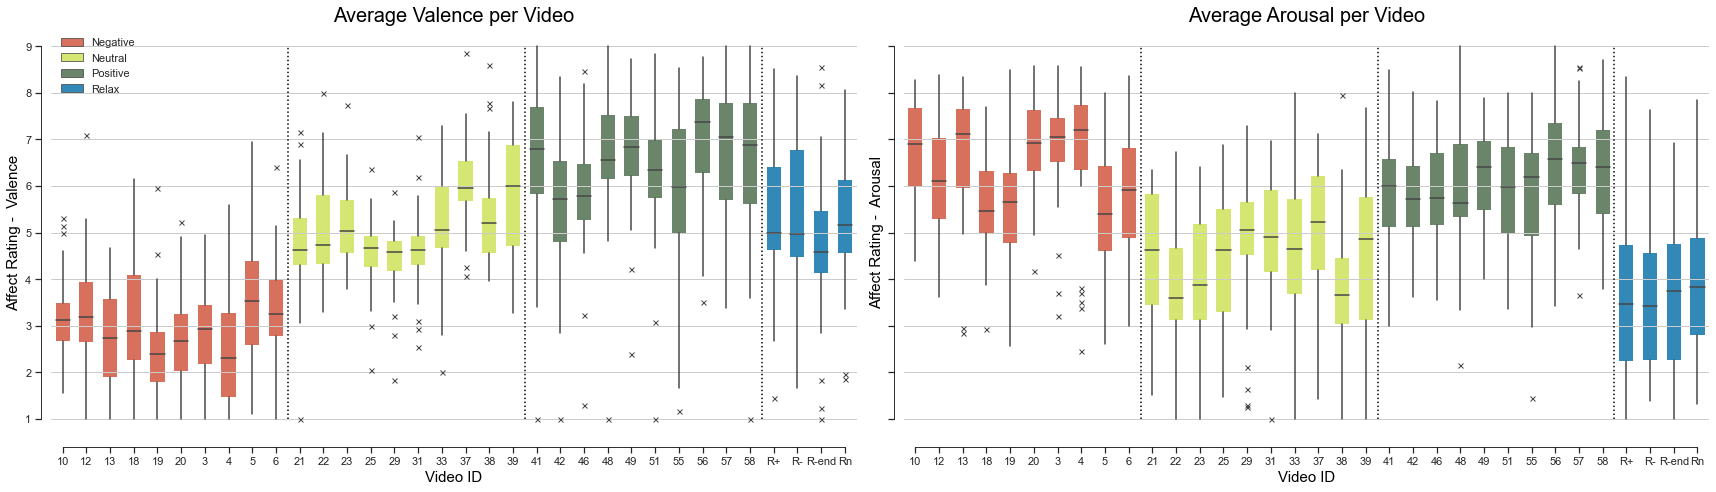

In [38]:
def generate_plot_affect_boxplot_ratings(df_results, axis_to_plot, colname, title):
    ax = axis_to_plot
    # Sort groups
    df_avg_affect_2 = df_results.copy()
    df_avg_affect_2.sort_values(by=["VideoId"], inplace=True, key= lambda col: col.map(lambda item: ([str,int].index(type(item)), item) ) ) # Make letters come before numbers
    df_avg_affect_2.sort_values(by=["Segment"], ascending=True, kind="mergesort", inplace=True) # Mergesort keeps respecting the previous sorting decision.

    # Rename columns
    df_avg_affect_2.rename( columns = {
                "Segment":"Exp. Segment",
                "VideoId": "Video ID",
                "Valence":"Avg. Valence",
                "Arousal":"Avg. Arousal"
                }, inplace = True )
    
    sns.set_theme(style="ticks")
    
    PALETTE_COLORS = [avdosvr.preprocessing.utils.enums.colourPaletteRGB.Negative.value,
                      avdosvr.preprocessing.utils.enums.colourPaletteRGB.Neutral.value,
                      avdosvr.preprocessing.utils.enums.colourPaletteRGB.Positive.value,
                      avdosvr.preprocessing.utils.enums.colourPaletteRGB.Relax.value]

    # Vertical lines separating the experimental sessions
    ax.vlines([9.5, 19.5, 29.5], ymin=1, ymax=9, color="black", linestyle='dotted', linewidth=1.5)
    ax.grid(axis="y")

    # Filter the data that has to do with this column label
    sns.boxplot(data=df_avg_affect_2, ax=ax,
                x="Video ID", y=colname, hue="Exp. Segment", #orient="h",
                width=0.6, palette=PALETTE_COLORS, dodge =False,
                # notch=True, 
                showcaps=False,
                flierprops={"marker": "x"},
                boxprops={"edgecolor": "none"},
                # medianprops={"color": "coral"}
                )
    
    sns.despine(offset=10, trim=True)
    sns.move_legend(ax, loc="best", title=None, frameon=False)

    ax.set_ylabel(f"Affect Rating - {colname.split('.')[-1]}", fontsize = 15)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel("Video ID", fontsize=15)
    if('Arousal' in title):
        ax.get_legend().remove()
    return ax

### Generate path to save and figure
save_path_plot = gen_path_plot(f"affect-boxplot-ratings-per-video")

NUM_ROWS = 1
NUM_COLS = 2
fig,axes = plt.subplots(NUM_ROWS, NUM_COLS, sharex=False, sharey=True, figsize=(12*NUM_COLS, 7*NUM_ROWS))

COL_TITLES = ["Avg. Valence", "Avg. Arousal"]
PLOT_TITLES = ["Average Valence per Video", "Average Arousal per Video"]
for i in range(len(COL_TITLES)):
    axes[i] = generate_plot_affect_boxplot_ratings(df_avg_affect_with_segment, axes[i], COL_TITLES[i], PLOT_TITLES[i])

plt.tight_layout()
plt.savefig(save_path_plot)

---
## Analyzing postprocessed dataset and features

The following blocks use compiled dataset created during the notebook `1_...ipynb`. It contains a subset from the AVDOS-VR dataset with physiological data resampled at 50Hz, subset of relevant columns, and synchronized with affect events and experimental affective segments.

In [39]:
# Load the dataset
DATASET_POSTPROCESSED_FILENAME = ROOT + "/temp/1_preprocess/Dataset_AVDOSVR_postprocessed.csv"
DATASET_POSTPROCESSED_FILENAME

'D:\\AVDOS-VR\\notebooks//temp/1_preprocess/Dataset_AVDOSVR_postprocessed.csv'

In [40]:
# Load the file in memory (~700MB)
dataset = pd.read_csv(DATASET_POSTPROCESSED_FILENAME)

In [41]:
dataset.columns

Index(['Participant', 'Stage', 'Time', 'OriginalParticipantID',
       'Emg/Contact[LeftOrbicularis]', 'Emg/Amplitude[LeftOrbicularis]',
       'Magnetometer/Raw.y', 'Emg/Contact[CenterCorrugator]',
       'Faceplate/FitState', 'Emg/Amplitude[RightZygomaticus]',
       'Emg/Contact[RightZygomaticus]', 'Gyroscope/Raw.x',
       'Emg/Contact[RightOrbicularis]', 'Faceplate/FaceState',
       'Emg/Amplitude[LeftZygomaticus]', 'Gyroscope/Raw.z',
       'HeartRate/Average', 'Accelerometer/Raw.x', 'Gyroscope/Raw.y',
       'Emg/Contact[LeftFrontalis]', 'Accelerometer/Raw.z', 'Ppg/Raw.ppg',
       'Ppg/Raw.proximity', 'Emg/Contact[RightFrontalis]',
       'Magnetometer/Raw.x', 'Magnetometer/Raw.z',
       'Emg/Amplitude[CenterCorrugator]', 'Emg/Amplitude[LeftFrontalis]',
       'Emg/Amplitude[RightOrbicularis]', 'Emg/Amplitude[RightFrontalis]',
       'Accelerometer/Raw.y', 'Emg/Contact[LeftZygomaticus]', 'VideoId',
       'Valence', 'Arousal', 'RawX', 'RawY'],
      dtype='object')

### General variables

The following variables store important info about the dataset. How many participants? Which video segments are included? Which videoIds are contained in each affective segment?

In [42]:
participants_ids = dataset["Participant"].unique()
participants_ids

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38], dtype=int64)

In [43]:
experiment_segment_names = dataset["Stage"].unique()
experiment_segment_names

array(['Resting_Positive', 'Positive', 'Resting_Negative', 'Negative',
       'Resting_Neutral', 'Neutral'], dtype=object)

In [44]:
video_ids = dataset["VideoId"].unique()
print(np.sort(video_ids))
# -1 refers to the resting stages, no video is presented.

[-1.  3.  4.  5.  6. 10. 12. 13. 18. 19. 20. 21. 22. 23. 25. 29. 31. 33.
 37. 38. 39. 41. 42. 46. 48. 49. 51. 55. 56. 57. 58.]


In [45]:
# All rows inside the `video` stage should contain a VideoId differen than -1,
# As -1 denotes a resting video. The following code verifies that there are no invalid rows.
Q = (( dataset["VideoId"]==-1) & ~(dataset["Stage"].str.startswith("Resting_")))
dataset[Q]

# NOTE: The result should be and empty DF.

,Participant,Stage,Time,OriginalParticipantID,Emg/Contact[LeftOrbicularis],Emg/Amplitude[LeftOrbicularis],Magnetometer/Raw.y,Emg/Contact[CenterCorrugator],Faceplate/FitState,Emg/Amplitude[RightZygomaticus],Emg/Contact[RightZygomaticus],Gyroscope/Raw.x,Emg/Contact[RightOrbicularis],Faceplate/FaceState,Emg/Amplitude[LeftZygomaticus],Gyroscope/Raw.z,HeartRate/Average,Accelerometer/Raw.x,Gyroscope/Raw.y,Emg/Contact[LeftFrontalis],Accelerometer/Raw.z,Ppg/Raw.ppg,Ppg/Raw.proximity,Emg/Contact[RightFrontalis],Magnetometer/Raw.x,Magnetometer/Raw.z,Emg/Amplitude[CenterCorrugator],Emg/Amplitude[LeftFrontalis],Emg/Amplitude[RightOrbicularis],Emg/Amplitude[RightFrontalis],Accelerometer/Raw.y,Emg/Contact[LeftZygomaticus],VideoId,Valence,Arousal,RawX,RawY


In [46]:
# Generate a dictionary with the stage and their corresponding list of `VideoId`
# Confirm the unique Video IDs in each experimental segment
video_ids_per_segment = {}
for segment in experiment_segment_names:
    video_ids_per_segment[segment] = np.array([])
    # Keep unique video ids
    Q = ( dataset["Stage"] == segment )
    video_ids_per_segment[segment] = dataset[Q]["VideoId"].unique()
video_ids_per_segment

{'Resting_Positive': array([-1.]),
 'Positive': array([51., 49., 46., 41., 48., 57., 56., 58., 42., 55.]),
 'Resting_Negative': array([-1.]),
 'Negative': array([18., 10.,  5., 13., 12., 19.,  3.,  4., 20.,  6.]),
 'Resting_Neutral': array([-1.]),
 'Neutral': array([25., 38., 29., 37., 31., 33., 22., 39., 23., 21.])}

In [47]:
# The index is in the order ["Participant", "AffectSegment", "Time"]
# It allows multidimensional manipulation in a 2D pandas structure
data = dataset.set_index(["Participant","Stage","Time"])
data.sort_index(inplace=True)
data.head()

OriginalParticipantID  ...  RawY
Participant Stage    Time                         ...      
0           Negative 0.00                    101  ...   NaN
                     0.02                    101  ...   NaN
                     0.04                    101  ...   NaN
                     0.06                    101  ...   NaN
                     0.08                    101  ...   NaN

[5 rows x 34 columns]

### EDA - Accessing single participant's data
Exploratory Data Analysis (EDA) to visualize a particular experimental segment from a specific participant

In [48]:
PARTICIPANT_IDX = 14
EXPERIMENTAL_SEGMENT = "Positive"
# Access the dictionary of videos existing in the segment, choose the first VideoID
VIDEO_ID = video_ids_per_segment[EXPERIMENTAL_SEGMENT][0] 

##
# Select a whole experimental segment
single_segment_ts = data.loc[(PARTICIPANT_IDX,EXPERIMENTAL_SEGMENT)]
# Select a specific video inside the experimental segment
single_video_ts = single_segment_ts[ single_segment_ts["VideoId"] == VIDEO_ID]

array([<AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Tim

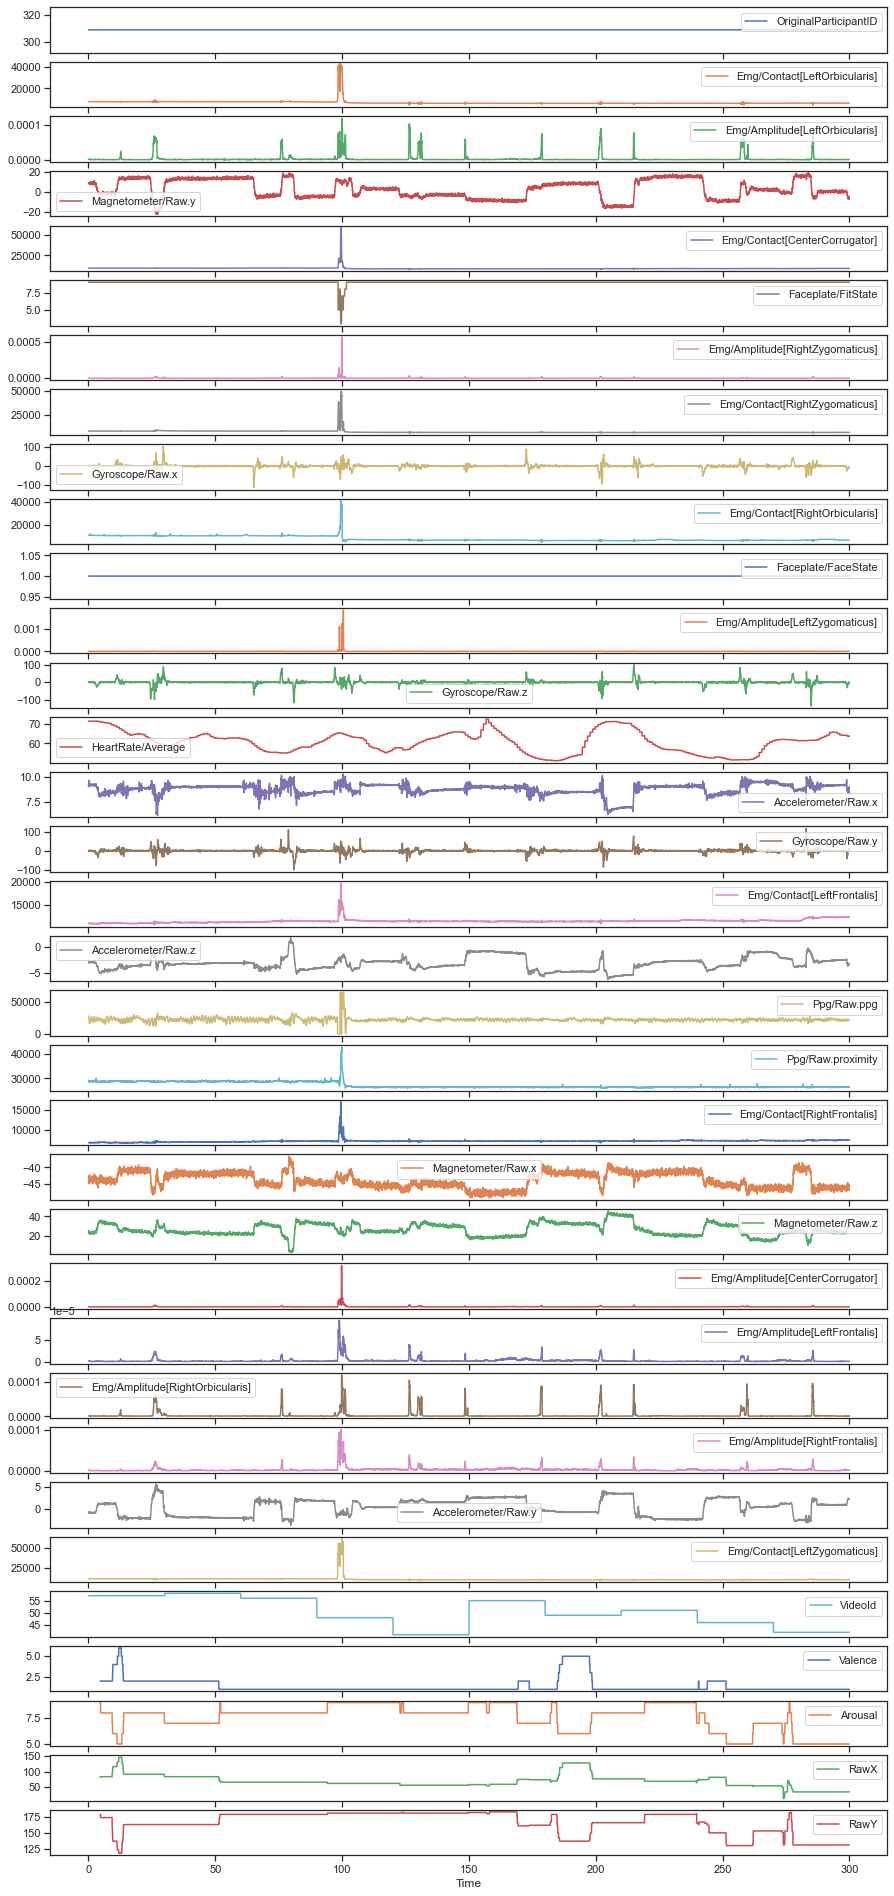

In [49]:
single_segment_ts.plot.line(subplots=True, figsize=(15,1*single_segment_ts.shape[1]), sharex=True)

array([<AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Tim

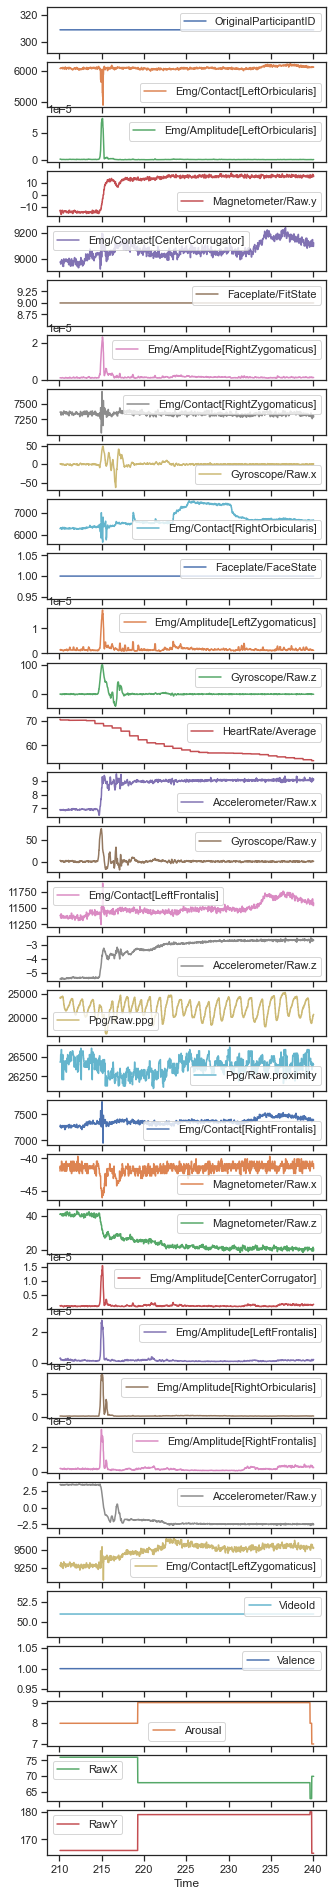

In [50]:
single_video_ts.plot.line(subplots=True, figsize=(5,1*single_video_ts.shape[1]), sharex=True)

---
## Analysis 2: Feature-based classification

Feature-based classification assuming that the features captured with overlapping windows act as independent samples, unlike in time-series classification.

Feature extraction steps:
1. Traverse the time-series data per participant and per experimental segment: (~300secs per video segment).
2. Consider the following stages as target classes: `[Positive, Neutral, Negative]`.
3. Take the corresponding resting stages ( `[Resting_Negative, Resting_Neutral, Resting_VideoPositive]`) to fit a standardizer ($\mu=0,\sigma=1$)
4. Apply a sliding window of specific width and overlap to extract **statistical features** (11 features per dimension) from: `[HEART, MOTOR, FACE]`.
5. In addition, calculate **time-domain HRV features** from the non-standardized version of the PPG signal (5 features from PPG).

In [51]:
ORIG_SAMP_FREQUENCY_HZ = 50

WINDOW_WIDTH_SECS = 30
WINDOW_OVERLAP_SECS = 10

In [52]:
# Copy the original dataset again
data = dataset.copy().set_index(["Participant","Stage","Time"])
data.sort_index(inplace=True)
data.head()

OriginalParticipantID  ...  RawY
Participant Stage    Time                         ...      
0           Negative 0.00                    101  ...   NaN
                     0.02                    101  ...   NaN
                     0.04                    101  ...   NaN
                     0.06                    101  ...   NaN
                     0.08                    101  ...   NaN

[5 rows x 34 columns]

In [53]:
data.columns

Index(['OriginalParticipantID', 'Emg/Contact[LeftOrbicularis]',
       'Emg/Amplitude[LeftOrbicularis]', 'Magnetometer/Raw.y',
       'Emg/Contact[CenterCorrugator]', 'Faceplate/FitState',
       'Emg/Amplitude[RightZygomaticus]', 'Emg/Contact[RightZygomaticus]',
       'Gyroscope/Raw.x', 'Emg/Contact[RightOrbicularis]',
       'Faceplate/FaceState', 'Emg/Amplitude[LeftZygomaticus]',
       'Gyroscope/Raw.z', 'HeartRate/Average', 'Accelerometer/Raw.x',
       'Gyroscope/Raw.y', 'Emg/Contact[LeftFrontalis]', 'Accelerometer/Raw.z',
       'Ppg/Raw.ppg', 'Ppg/Raw.proximity', 'Emg/Contact[RightFrontalis]',
       'Magnetometer/Raw.x', 'Magnetometer/Raw.z',
       'Emg/Amplitude[CenterCorrugator]', 'Emg/Amplitude[LeftFrontalis]',
       'Emg/Amplitude[RightOrbicularis]', 'Emg/Amplitude[RightFrontalis]',
       'Accelerometer/Raw.y', 'Emg/Contact[LeftZygomaticus]', 'VideoId',
       'Valence', 'Arousal', 'RawX', 'RawY'],
      dtype='object')

In [54]:
# Identify groups of features
basic_colnames = avdosvr.preprocessing.COLNAMES_AFFECT
hrv_colnames = avdosvr.preprocessing.COLNAMES_HR + avdosvr.preprocessing.COLNAMES_PPG
imu_colnames = avdosvr.preprocessing.COLNAMES_ACCELEROMETER + avdosvr.preprocessing.COLNAMES_MAGNETOMETER + avdosvr.preprocessing.COLNAMES_GYROSCOPE
emg_colnames = avdosvr.preprocessing.COLNAMES_EMG_AMPLITUDE
emg_contact_colnames = avdosvr.preprocessing.COLNAMES_EMG_CONTACT

In [55]:
# Identify colnames that have relevant time-series data (exclude videoId, affect, etc.)
TS_DATA_COLNAMES = hrv_colnames + imu_colnames + emg_colnames + emg_contact_colnames
TS_DATA_COLNAMES

['HeartRate/Average',
 'Ppg/Raw.ppg',
 'Ppg/Raw.proximity',
 'Accelerometer/Raw.x',
 'Accelerometer/Raw.y',
 'Accelerometer/Raw.z',
 'Magnetometer/Raw.x',
 'Magnetometer/Raw.y',
 'Magnetometer/Raw.z',
 'Gyroscope/Raw.x',
 'Gyroscope/Raw.y',
 'Gyroscope/Raw.z',
 'Emg/Amplitude[RightFrontalis]',
 'Emg/Amplitude[RightZygomaticus]',
 'Emg/Amplitude[RightOrbicularis]',
 'Emg/Amplitude[CenterCorrugator]',
 'Emg/Amplitude[LeftOrbicularis]',
 'Emg/Amplitude[LeftZygomaticus]',
 'Emg/Amplitude[LeftFrontalis]',
 'Emg/Contact[RightFrontalis]',
 'Emg/Contact[RightZygomaticus]',
 'Emg/Contact[RightOrbicularis]',
 'Emg/Contact[CenterCorrugator]',
 'Emg/Contact[LeftOrbicularis]',
 'Emg/Contact[LeftZygomaticus]',
 'Emg/Contact[LeftFrontalis]']

In [56]:
def filter_outliers_from_df(df, num_std = 2):
    """
    Takes a multidimensional dataFrame and filter the values
    that are `num_std` standard deviations away from the mean value
    of the column.

    First, it transforms the value in np.nan. Then, it imputes the
    value with backward filling, and then with forward filling, in case
    the missing values are generated on the extremes of the time-series.

    Returns the filtered dataset
    """
    mask = (( df > (df.mean() + num_std*df.std())) | ( df < (df.mean() - num_std*df.std())) )
    df[ mask ] = np.nan
    df_filtered = df.fillna(method="backfill", axis=0)
    df_filtered = df_filtered.fillna(method="ffill", axis=0)
    print(f"\tTotal NAs --> Generated={df.isna().sum().sum()} - After imputation={df_filtered.isna().sum().sum()}")
    return df_filtered

*Testing feature extraction in one instance*...

In [57]:
# INSTANCE
PARTICIPANT_IDX = 20
EXP_SEGMENT = str(avdosvr.preprocessing.AffectSegments.VideosNeutral)
VIDEO_ID = video_ids_per_segment[EXP_SEGMENT][0]

print(f"participant={PARTICIPANT_IDX}, segment={EXP_SEGMENT}, video_id={VIDEO_ID}")

participant=20, segment=Neutral, video_id=25.0


**Preparing resting stage as baseline for the scaler**

In [58]:
# Read from dataset data from a VIDEO segment and its corresponding RESTING stage
single_segment_ts = data.loc[(PARTICIPANT_IDX,EXP_SEGMENT)]

# Filter data with FitState >= average (8)
single_segment_ts = single_segment_ts[ single_segment_ts["Faceplate/FitState"] > 7]
single_segment_ts = single_segment_ts[TS_DATA_COLNAMES] # Choose columns with relevant data

# This resting stages will be used to normalize the values.
single_segment_resting = data.loc[(PARTICIPANT_IDX,"Resting_"+EXP_SEGMENT)]
# Filter data with FitState >= average (8)
single_segment_resting = single_segment_resting[ single_segment_resting["Faceplate/FitState"] > 7]

print(f"Video df shape: {single_segment_ts.shape}")
print(f"Resting df shape: {single_segment_resting.shape}")

Video df shape: (14900, 26)
Resting df shape: (5982, 34)


All data from each participant used for standarisation:

In [59]:
# Load all the data from a participant across all experiments
single_participants_data = data.loc[(PARTICIPANT_IDX)]
single_participants_data

OriginalParticipantID  ...  RawY
Stage            Time                           ...      
Negative         0.00                      330  ...   NaN
                 0.02                      330  ...   NaN
                 0.04                      330  ...   NaN
                 0.06                      330  ...   NaN
                 0.08                      330  ...   NaN
...                                        ...  ...   ...
Resting_Positive 119.92                    330  ...  58.0
                 119.94                    330  ...  58.0
                 119.96                    330  ...  58.0
                 119.98                    330  ...  58.0
                 120.00                    330  ...  58.0

[63013 rows x 34 columns]

In [60]:
# Note that each column has a mean different than zero and std different than one
single_participants_data.describe()

,OriginalParticipantID,Emg/Contact[LeftOrbicularis],Emg/Amplitude[LeftOrbicularis],Magnetometer/Raw.y,Emg/Contact[CenterCorrugator],Faceplate/FitState,Emg/Amplitude[RightZygomaticus],Emg/Contact[RightZygomaticus],Gyroscope/Raw.x,Emg/Contact[RightOrbicularis],Faceplate/FaceState,Emg/Amplitude[LeftZygomaticus],Gyroscope/Raw.z,HeartRate/Average,Accelerometer/Raw.x,Gyroscope/Raw.y,Emg/Contact[LeftFrontalis],Accelerometer/Raw.z,Ppg/Raw.ppg,Ppg/Raw.proximity,Emg/Contact[RightFrontalis],Magnetometer/Raw.x,Magnetometer/Raw.z,Emg/Amplitude[CenterCorrugator],Emg/Amplitude[LeftFrontalis],Emg/Amplitude[RightOrbicularis],Emg/Amplitude[RightFrontalis],Accelerometer/Raw.y,Emg/Contact[LeftZygomaticus],VideoId,Valence,Arousal,RawX,RawY
count,63013.0,63013.000000,6.301300e+04,63013.000000,63013.000000,63013.000000,6.301300e+04,63013.000000,63013.000000,63013.000000,63013.000000,6.301300e+04,63013.000000,63013.000000,63013.000000,63013.000000,63013.000000,63013.000000,63013.00000,63013.000000,63013.000000,63013.000000,63013.00000,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,63013.000000,63013.000000,63013.000000,62772.000000,62772.000000,62772.000000,62772.000000
mean,330.0,12158.773682,1.687247e-06,25.484264,12151.280180,8.970197,2.547934e-06,6264.364623,-0.236658,11772.892419,0.999984,4.470590e-06,0.045078,72.325513,8.388130,-0.129060,8297.566597,-4.626802,20252.08868,31626.423754,8037.547903,-14.525798,28.19769,2.740499e-06,3.423186e-06,2.728889e-06,2.708052e-06,-0.836648,5035.183914,21.404631,3.803463,4.447461,109.694402,111.883387
std,0.0,1119.522667,1.641463e-06,1.434478,927.691714,0.438969,5.804214e-06,736.091513,3.903849,1054.336431,0.003984,1.027784e-05,2.383895,5.091834,0.207581,2.527485,830.240519,0.340152,4976.94056,624.796921,807.543640,1.488996,1.85271,1.760138e-06,1.995123e-06,2.701062e-06,1.916606e-06,0.265312,734.425406,20.294369,2.638574,2.641891,54.845212,49.583833
min,330.0,10846.000000,6.357829e-07,15.937500,11204.000000,0.000000,6.755193e-07,5840.000000,-84.375000,10596.000000,0.000000,6.755193e-07,-38.812500,0.000000,1.460000,-51.312500,7530.000000,-5.750000,256.00000,30496.000000,7358.000000,-19.250000,21.93750,6.755193e-07,7.152557e-07,7.152557e-07,7.549922e-07,-1.810000,4256.000000,-1.000000,1.000000,1.000000,9.000000,0.000000
25%,330.0,11346.000000,9.536743e-07,24.812500,11586.000000,9.000000,9.934107e-07,6084.000000,-0.875000,11056.000000,1.000000,1.072884e-06,-0.562500,68.990000,8.270000,-0.875000,7906.000000,-4.850000,16176.00000,31040.000000,7662.000000,-15.562500,27.00000,1.430511e-06,2.106031e-06,1.231829e-06,1.549721e-06,-1.000000,4882.000000,-1.000000,1.000000,2.000000,61.000000,74.000000
50%,330.0,11982.000000,1.192093e-06,25.562500,12022.000000,9.000000,1.112620e-06,6192.000000,-0.250000,11586.000000,1.000000,1.390775e-06,0.125000,72.930000,8.400000,-0.125000,8206.000000,-4.620000,19952.00000,31536.000000,8006.000000,-14.812500,27.93750,2.543132e-06,3.178914e-06,1.668930e-06,2.185504e-06,-0.860000,4976.000000,19.000000,3.000000,4.000000,107.000000,110.000000
75%,330.0,12934.000000,2.066294e-06,26.312500,12670.000000,9.000000,1.748403e-06,6394.000000,0.500000,12418.000000,1.000000,3.178914e-06,0.750000,75.470000,8.500000,0.562500,8734.000000,-4.440000,24000.00000,32208.000000,8364.000000,-13.687500,29.12500,3.814697e-06,4.569689e-06,2.980232e-06,3.536542e-06,-0.690000,5152.000000,39.000000,6.000000,7.000000,152.000000,156.000000
max,330.0,131070.000000,1.343886e-04,30.375000,131070.000000,9.000000,1.165072e-04,131070.000000,42.687500,131070.000000,1.000000,1.711845e-04,53.062500,93.280000,11.170000,58.875000,131070.000000,-1.490000,65520.00000,33680.000000,131070.000000,-6.625000,36.31250,1.254479e-04,1.209180e-04,1.264413e-04,1.329581e-04,0.990000,131070.000000,58.000000,9.000000,9.000000,245.000000,225.000000


In [61]:
# Scaler fitted on the WHOLE data of the participant
scaler = ColumnTransformer( [ 
                            ("", StandardScaler(), TS_DATA_COLNAMES) # Apply to all columns with TS data
                        ])
scaler.fit(single_participants_data)

ColumnTransformer(transformers=[('', StandardScaler(),
                                 ['HeartRate/Average', 'Ppg/Raw.ppg',
                                  'Ppg/Raw.proximity', 'Accelerometer/Raw.x',
                                  'Accelerometer/Raw.y', 'Accelerometer/Raw.z',
                                  'Magnetometer/Raw.x', 'Magnetometer/Raw.y',
                                  'Magnetometer/Raw.z', 'Gyroscope/Raw.x',
                                  'Gyroscope/Raw.y', 'Gyroscope/Raw.z',
                                  'Emg/Amplitude[RightFrontalis]',
                                  'Emg/Amplitude[RightZygomat...
                                  'Emg/Amplitude[CenterCorrugator]',
                                  'Emg/Amplitude[LeftOrbicularis]',
                                  'Emg/Amplitude[LeftZygomaticus]',
                                  'Emg/Amplitude[LeftFrontalis]',
                                  'Emg/Contact[RightFrontalis]',
                                  'Emg/Contact[RightZygomaticus]',
                                  'Emg/Contact[RightOrbicularis]',
                                  'Emg/Contact[CenterCorrugator]',
                                  'Emg/Contact[LeftOrbicularis]',
                                  'Emg/Contact[LeftZygomaticus]',
                                  'Emg/Contact[LeftFrontalis]'])])

In [62]:
# Proof: The standardization creates the z-scores 
# trained above and each column has zero mean and one std
scaled_data = scaler.transform(single_participants_data)
scaled_data = pd.DataFrame(data=scaled_data,columns=TS_DATA_COLNAMES)
scaled_data.describe()

,HeartRate/Average,Ppg/Raw.ppg,Ppg/Raw.proximity,Accelerometer/Raw.x,Accelerometer/Raw.y,Accelerometer/Raw.z,Magnetometer/Raw.x,Magnetometer/Raw.y,Magnetometer/Raw.z,Gyroscope/Raw.x,Gyroscope/Raw.y,Gyroscope/Raw.z,Emg/Amplitude[RightFrontalis],Emg/Amplitude[RightZygomaticus],Emg/Amplitude[RightOrbicularis],Emg/Amplitude[CenterCorrugator],Emg/Amplitude[LeftOrbicularis],Emg/Amplitude[LeftZygomaticus],Emg/Amplitude[LeftFrontalis],Emg/Contact[RightFrontalis],Emg/Contact[RightZygomaticus],Emg/Contact[RightOrbicularis],Emg/Contact[CenterCorrugator],Emg/Contact[LeftOrbicularis],Emg/Contact[LeftZygomaticus],Emg/Contact[LeftFrontalis]
count,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04
mean,-1.912460e-15,3.214860e-16,-4.018784e-15,-6.221037e-15,-1.156727e-14,-3.616115e-15,5.094983e-15,1.195023e-16,-7.017541e-17,7.262312e-17,-4.589297e-17,3.218568e-16,1.514315e-15,-3.865085e-14,-1.953624e-15,9.742488e-15,3.213983e-14,-5.059564e-16,-2.013617e-15,4.330287e-15,-6.480131e-15,-3.929280e-15,1.234231e-13,-8.291902e-16,6.589546e-15,2.253855e-15
std,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00
min,-1.420433e+01,-4.017779e+00,-1.809280e+00,-3.337574e+01,-3.668730e+00,-3.302076e+00,-3.172768e+00,-6.655270e+00,-3.378965e+00,-2.155284e+01,-2.025090e+01,-1.630017e+01,-1.019028e+00,-3.225982e-01,-7.455026e-01,-1.173202e+00,-6.405704e-01,-3.692509e-01,-1.357286e+00,-8.415066e-01,-5.765153e-01,-1.116249e+00,-1.021123e+00,-1.172628e+00,-1.060952e+00,-9.245185e-01
25%,-6.550762e-01,-8.190013e-01,-9.385904e-01,-5.690819e-01,-6.157012e-01,-6.561760e-01,-6.962477e-01,-4.683023e-01,-6.464585e-01,-1.635175e-01,-2.951338e-01,-2.548698e-01,-6.043708e-01,-2.678287e-01,-5.542528e-01,-7.442590e-01,-4.469054e-01,-3.305884e-01,-6.601930e-01,-4.650534e-01,-2.450321e-01,-6.799519e-01,-6.093454e-01,-7.260060e-01,-2.085782e-01,-4.716341e-01
50%,1.187179e-01,-6.029629e-02,-1.447262e-01,5.718326e-02,-8.801713e-02,1.999831e-02,-1.925486e-01,5.454001e-02,-1.404389e-01,-3.417804e-03,1.606225e-03,3.352607e-02,-2.726448e-01,-2.472901e-01,-3.924260e-01,-1.121330e-01,-3.016567e-01,-2.996583e-01,-1.224355e-01,-3.906681e-02,-9.831006e-02,-1.772621e-01,-1.393579e-01,-1.579022e-01,-8.058597e-02,-1.102901e-01
75%,6.175598e-01,7.530612e-01,9.308318e-01,5.389257e-01,5.527421e-01,5.491782e-01,5.630001e-01,5.773824e-01,5.005193e-01,1.887018e-01,2.736179e-01,2.957041e-01,4.322728e-01,-1.377511e-01,9.305431e-02,6.102967e-01,2.309221e-01,-1.256768e-01,5.746576e-01,4.042564e-01,1.761145e-01,6.118661e-01,5.591555e-01,6.924670e-01,1.590591e-01,5.256752e-01
max,4.115345e+00,9.095602e+00,3.286816e+00,1.340145e+01,6.884951e+00,9.221849e+00,5.306167e+00,3.409445e+00,4.380003e+00,1.099543e+01,2.334516e+01,2.224001e+01,6.795924e+01,1.963404e+01,4.580176e+01,6.971521e+01,8.084398e+01,1.622085e+01,5.889147e+01,1.523551e+02,1.695531e+02,1.131499e+02,1.281888e+02,1.062168e+02,1.716115e+02,1.478769e+02


**Sliding window to iterate over the signal**

In [63]:
def generate_sliding_windows(df_ts, 
                        window_width_seconds,
                        window_overlap_seconds,
                        verbose = False
                        ):
    """
    Iterates over the dataframe in `df_ts` with overlapping windows
    defined by `window_width_seconds` and `window_overlap_seconds`.

    This function assumes that the index of `df_ts` is in seconds
    and is sorted incrementally.
    Returns a list of tuples with the (start,end) of each window
    """
    # Generate iterator
    w_start_indices = np.arange(df_ts.index[0], df_ts.index[-1], window_overlap_seconds)
    return [ (w, w+window_width_seconds) for w in w_start_indices ]


In [64]:
generate_sliding_windows(single_segment_ts,
                        window_overlap_seconds = WINDOW_OVERLAP_SECS,
                        window_width_seconds = WINDOW_WIDTH_SECS)

[(0.0, 30.0),
 (10.0, 40.0),
 (20.0, 50.0),
 (30.0, 60.0),
 (40.0, 70.0),
 (50.0, 80.0),
 (60.0, 90.0),
 (70.0, 100.0),
 (80.0, 110.0),
 (90.0, 120.0),
 (100.0, 130.0),
 (110.0, 140.0),
 (120.0, 150.0),
 (130.0, 160.0),
 (140.0, 170.0),
 (150.0, 180.0),
 (160.0, 190.0),
 (170.0, 200.0),
 (180.0, 210.0),
 (190.0, 220.0),
 (200.0, 230.0),
 (210.0, 240.0),
 (220.0, 250.0),
 (230.0, 260.0),
 (240.0, 270.0),
 (250.0, 280.0),
 (260.0, 290.0),
 (270.0, 300.0),
 (280.0, 310.0),
 (290.0, 320.0),
 (300.0, 330.0)]

In [65]:
# Select first window
df_window = single_segment_ts.loc[0:WINDOW_WIDTH_SECS]
df_window.head()

,HeartRate/Average,Ppg/Raw.ppg,Ppg/Raw.proximity,Accelerometer/Raw.x,Accelerometer/Raw.y,Accelerometer/Raw.z,Magnetometer/Raw.x,Magnetometer/Raw.y,Magnetometer/Raw.z,Gyroscope/Raw.x,Gyroscope/Raw.y,Gyroscope/Raw.z,Emg/Amplitude[RightFrontalis],Emg/Amplitude[RightZygomaticus],Emg/Amplitude[RightOrbicularis],Emg/Amplitude[CenterCorrugator],Emg/Amplitude[LeftOrbicularis],Emg/Amplitude[LeftZygomaticus],Emg/Amplitude[LeftFrontalis],Emg/Contact[RightFrontalis],Emg/Contact[RightZygomaticus],Emg/Contact[RightOrbicularis],Emg/Contact[CenterCorrugator],Emg/Contact[LeftOrbicularis],Emg/Contact[LeftZygomaticus],Emg/Contact[LeftFrontalis]
Time,,,,,,,,,,,,,,,,,,,,,,,,,,
0.00,74.38,16592,30832,8.47,-0.89,-4.48,-13.6875,25.5625,28.500,-0.6250,-0.5000,-0.250,0.000006,9.139379e-07,0.000001,0.000004,0.000001,9.934107e-07,0.000009,7658.0,6074.0,11052.0,11602.0,11322.0,4878.0,7886.0
0.02,74.38,16592,30832,8.47,-0.89,-4.48,-13.6875,25.5625,28.500,-0.6250,-0.5000,-0.250,0.000005,8.742015e-07,0.000001,0.000004,0.000001,1.072884e-06,0.000007,7658.0,6074.0,11052.0,11602.0,11322.0,4878.0,7886.0
0.04,74.38,17872,30928,8.47,-0.88,-4.47,-12.9375,25.1875,28.500,-1.1875,-0.3125,1.125,0.000006,8.344650e-07,0.000001,0.000003,0.000001,1.033147e-06,0.000007,7628.0,6064.0,11046.0,11578.0,11312.0,4874.0,7810.0
0.06,74.38,17872,30928,8.48,-0.88,-4.46,-12.9375,25.1875,28.500,-0.8125,-0.3125,0.875,0.000006,8.742015e-07,0.000001,0.000004,0.000001,9.934107e-07,0.000007,7628.0,6064.0,11046.0,11578.0,11312.0,4874.0,7810.0
0.08,74.38,18960,30928,8.48,-0.87,-4.48,-15.1875,25.1875,28.125,-1.5000,-0.6875,1.000,0.000006,9.139379e-07,0.000001,0.000004,0.000001,1.033147e-06,0.000008,7662.0,6084.0,11066.0,11572.0,11332.0,4910.0,7890.0


**Extract HRV features from PPG**

In [66]:
def calculate_hrv_features(df_ppg, sampling_frequency, return_plot=False):
    """
    Receives a dataframe with ppg data and returns
    time-domain features.
    """
    
    signals, info = nk.ppg_process(df_ppg, sampling_rate=sampling_frequency)
    peaks = signals.PPG_Peaks
    
    ## Plot summary
    # nk.ppg_plot(signals, sampling_rate=ORIG_SAMP_FREQUENCY_HZ)

    # Time-based features
    hrv_time = nk.hrv_time(peaks, sampling_rate=sampling_frequency, show=False)

    # HRV features from neurokit2 that should be forwarded for final dataset
    HRV_SUBSET_FEATURES = ["HRV_MeanNN","HRV_SDNN","HRV_RMSSD","HRV_SDSD","HRV_MedianNN", "HRV_IQRNN"]
    hrv_time_features = hrv_time[ HRV_SUBSET_FEATURES ]
    
    # Calculate mean heart rate for the window
    hrv_time_features['Mean_BPM'] = np.mean(signals['PPG_Rate'])
    
    # Get values for actual peaks
    ppg_peaks = signals[signals['PPG_Peaks']==1]
    ppg_peaks = ppg_peaks.reset_index()
    
    for idx, peak in ppg_peaks.iterrows():
        #get number of rows between PPG peaks
        if(idx < (len(ppg_peaks)-2)):
            time_between_peaks = ppg_peaks.loc[idx+1]['index'] - ppg_peaks.loc[idx]['index']
            #with known frequency of 50hz, get seconds between peaks
            time_between_peaks = time_between_peaks * 0.02
            # estimate BPM with the time between peaks
            estimated_hr = 60/time_between_peaks
            # check if BPM estimation falls outside the 40 to 120 bpm range
            if ((estimated_hr < 40) or (estimated_hr > 120)):
                hrv_time_features[hrv_time_features.columns] = -1
                break

    # ## NOTE: Frequency features are not used because the window width may not enough for most features!
    # hrv_freq = nk.hrv_frequency(peaks, sampling_rate=ts_sampling_freq, show=True, normalize=True)
    # hrv_allfeatures = nk.hrv(peaks, sampling_rate=ts_sampling_freq, show=True)

    #### Save figure when `show=True`
    # save_path_plot = gen_path_plot(f"Preprocessing/PPG/Participant{participant}_{segment}")
    # fig = plt.gcf().set_size_inches(8, 5)
    # plt.tight_layout()
    # plt.savefig(save_path_plot)
    # plt.close()
    return hrv_time_features


In [67]:
PPG_COLNAME = 'Ppg/Raw.ppg'     
calculate_hrv_features(df_window[PPG_COLNAME], ORIG_SAMP_FREQUENCY_HZ)

,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_SDSD,HRV_MedianNN,HRV_IQRNN,Mean_BPM
0,883.870968,61.842672,87.483332,88.968547,900.0,60.0,67.890318


**Extract statistical features**

In [68]:
def calculate_statistical_features(df):
    """
    Calculates the following features per column in the dataframe,
    adding a suffix for each processed column:
        - mean:     mean
        - std:      standard deviation
        - min:      minimum value
        - max:      maximum value
        - median:   median
        - irq:      interquartile range
        - pnv:      proportion of negative values
        - ppv:      proportion of positive values
        - skew:     skewness of the distribution
        - kurt:     kurtosis of the distribution
        - energy:   sum of squared absolute values
        - rms:      sqrt(sum of squared absolute values/n) 
    """

    if not isinstance(df, pd.DataFrame):
        df = pd.DataFrame(df)

    FUNCTIONS_FEATURES = {
        "mean":     np.mean,
        "std":      np.std,
        "min":      np.min,
        "max":      np.max,
        "median":   np.median,
        "irq":      stats.iqr,
        "pnv":      (lambda y: y[y<0].size/y.size),
        "ppv":      (lambda y: y[y>0].size/y.size),
        "skew":     stats.skew,
        "kurt":     stats.kurtosis,
        "energy":   (lambda y: np.sum(np.abs(y)**2) ),
        "rms":      (lambda y: np.sqrt(np.sum(np.abs(y)**2)/y.size) ),
    }
    
    # Store results with features per columns
    df_features_results = { }

    for feat_name,feat_func in FUNCTIONS_FEATURES.items():
        for col_name in list(df.columns):
            df_features_results[f"{col_name}_{feat_name}"] = [ feat_func(df[col_name]) ]

    return pd.DataFrame(df_features_results)

In [69]:
# Apply standardization on the VIDEO experimental stage
# Normalize the data from each participant w.r.t to the same variable during the corresponding resting stage.
df_window_norm = pd.DataFrame(data = scaler.transform(df_window), 
                                                columns = TS_DATA_COLNAMES, 
                                                index = df_window.index)

""" Create statistical feature """
statistical_features = calculate_statistical_features(df_window_norm)
statistical_features

,HeartRate/Average_mean,Ppg/Raw.ppg_mean,Ppg/Raw.proximity_mean,Accelerometer/Raw.x_mean,Accelerometer/Raw.y_mean,Accelerometer/Raw.z_mean,Magnetometer/Raw.x_mean,Magnetometer/Raw.y_mean,Magnetometer/Raw.z_mean,Gyroscope/Raw.x_mean,Gyroscope/Raw.y_mean,Gyroscope/Raw.z_mean,Emg/Amplitude[RightFrontalis]_mean,Emg/Amplitude[RightZygomaticus]_mean,Emg/Amplitude[RightOrbicularis]_mean,Emg/Amplitude[CenterCorrugator]_mean,Emg/Amplitude[LeftOrbicularis]_mean,Emg/Amplitude[LeftZygomaticus]_mean,Emg/Amplitude[LeftFrontalis]_mean,Emg/Contact[RightFrontalis]_mean,Emg/Contact[RightZygomaticus]_mean,Emg/Contact[RightOrbicularis]_mean,Emg/Contact[CenterCorrugator]_mean,Emg/Contact[LeftOrbicularis]_mean,Emg/Contact[LeftZygomaticus]_mean,Emg/Contact[LeftFrontalis]_mean,HeartRate/Average_std,Ppg/Raw.ppg_std,Ppg/Raw.proximity_std,Accelerometer/Raw.x_std,Accelerometer/Raw.y_std,Accelerometer/Raw.z_std,Magnetometer/Raw.x_std,Magnetometer/Raw.y_std,Magnetometer/Raw.z_std,Gyroscope/Raw.x_std,Gyroscope/Raw.y_std,Gyroscope/Raw.z_std,Emg/Amplitude[RightFrontalis]_std,Emg/Amplitude[RightZygomaticus]_std,...,Emg/Amplitude[RightFrontalis]_energy,Emg/Amplitude[RightZygomaticus]_energy,Emg/Amplitude[RightOrbicularis]_energy,Emg/Amplitude[CenterCorrugator]_energy,Emg/Amplitude[LeftOrbicularis]_energy,Emg/Amplitude[LeftZygomaticus]_energy,Emg/Amplitude[LeftFrontalis]_energy,Emg/Contact[RightFrontalis]_energy,Emg/Contact[RightZygomaticus]_energy,Emg/Contact[RightOrbicularis]_energy,Emg/Contact[CenterCorrugator]_energy,Emg/Contact[LeftOrbicularis]_energy,Emg/Contact[LeftZygomaticus]_energy,Emg/Contact[LeftFrontalis]_energy,HeartRate/Average_rms,Ppg/Raw.ppg_rms,Ppg/Raw.proximity_rms,Accelerometer/Raw.x_rms,Accelerometer/Raw.y_rms,Accelerometer/Raw.z_rms,Magnetometer/Raw.x_rms,Magnetometer/Raw.y_rms,Magnetometer/Raw.z_rms,Gyroscope/Raw.x_rms,Gyroscope/Raw.y_rms,Gyroscope/Raw.z_rms,Emg/Amplitude[RightFrontalis]_rms,Emg/Amplitude[RightZygomaticus]_rms,Emg/Amplitude[RightOrbicularis]_rms,Emg/Amplitude[CenterCorrugator]_rms,Emg/Amplitude[LeftOrbicularis]_rms,Emg/Amplitude[LeftZygomaticus]_rms,Emg/Amplitude[LeftFrontalis]_rms,Emg/Contact[RightFrontalis]_rms,Emg/Contact[RightZygomaticus]_rms,Emg/Contact[RightOrbicularis]_rms,Emg/Contact[CenterCorrugator]_rms,Emg/Contact[LeftOrbicularis]_rms,Emg/Contact[LeftZygomaticus]_rms,Emg/Contact[LeftFrontalis]_rms
0,-0.15609,0.01437,-1.007558,0.113111,-0.221798,0.082792,0.208645,-0.015397,0.211627,0.039905,-0.034673,-0.028905,1.220804,-0.26017,-0.554726,1.22067,-0.34493,-0.332403,1.675817,-0.50412,-0.254254,-0.716705,-0.643394,-0.764338,-0.213265,-0.540233,0.329744,1.37152,0.349177,0.23415,0.15336,0.235183,0.381355,0.579261,0.429044,0.569831,0.355106,0.513374,1.20424,0.296389,...,4110.896591,217.437211,1124.139634,3662.104783,2331.016862,199.683868,5698.060366,357.125234,91.555498,718.778079,579.872928,817.379642,64.577761,410.819902,0.364822,1.371596,1.066347,0.260039,0.269655,0.24933,0.4347,0.579465,0.478398,0.571226,0.356794,0.514187,1.714805,0.394379,0.896719,1.618497,1.291276,0.377936,2.018877,0.505425,0.255911,0.717041,0.64404,0.764642,0.214925,0.542091


In [70]:
print(statistical_features.columns.values)

['HeartRate/Average_mean' 'Ppg/Raw.ppg_mean' 'Ppg/Raw.proximity_mean'
 'Accelerometer/Raw.x_mean' 'Accelerometer/Raw.y_mean'
 'Accelerometer/Raw.z_mean' 'Magnetometer/Raw.x_mean'
 'Magnetometer/Raw.y_mean' 'Magnetometer/Raw.z_mean'
 'Gyroscope/Raw.x_mean' 'Gyroscope/Raw.y_mean' 'Gyroscope/Raw.z_mean'
 'Emg/Amplitude[RightFrontalis]_mean'
 'Emg/Amplitude[RightZygomaticus]_mean'
 'Emg/Amplitude[RightOrbicularis]_mean'
 'Emg/Amplitude[CenterCorrugator]_mean'
 'Emg/Amplitude[LeftOrbicularis]_mean'
 'Emg/Amplitude[LeftZygomaticus]_mean' 'Emg/Amplitude[LeftFrontalis]_mean'
 'Emg/Contact[RightFrontalis]_mean' 'Emg/Contact[RightZygomaticus]_mean'
 'Emg/Contact[RightOrbicularis]_mean' 'Emg/Contact[CenterCorrugator]_mean'
 'Emg/Contact[LeftOrbicularis]_mean' 'Emg/Contact[LeftZygomaticus]_mean'
 'Emg/Contact[LeftFrontalis]_mean' 'HeartRate/Average_std'
 'Ppg/Raw.ppg_std' 'Ppg/Raw.proximity_std' 'Accelerometer/Raw.x_std'
 'Accelerometer/Raw.y_std' 'Accelerometer/Raw.z_std'
 'Magnetometer/Raw.x_std

In [71]:
def extract_features_from_ts_window(data_df_window, ts_sampling_freq:float,
                                    colname_ppg:str,
                                    fitted_scaler:object,
                                    columns_to_normalize:list):
    """
    Takes a dataframe and extracts HRV and summary features from it
    Returns a dataframe with one row combining all features.
    """
    df_window = data_df_window
    
    # Extract HRV features from PPG
    hrv_time_features = calculate_hrv_features(df_window[colname_ppg], ts_sampling_freq)
    
    """ Create statistical feature """
    # Apply standardization on the VIDEO experimental stage
    # Normalize the data from each participant w.r.t to the same variable during the corresponding resting stage.
    df_window_norm = pd.DataFrame(data = fitted_scaler.transform(df_window), 
                                                    columns = columns_to_normalize, 
                                                    index = df_window.index)
    
    statistical_features = calculate_statistical_features(df_window_norm)

    df_result = pd.concat([hrv_time_features, statistical_features], axis=1)
    return df_result

In [72]:
extract_features_from_ts_window(single_segment_ts, ORIG_SAMP_FREQUENCY_HZ,
                                PPG_COLNAME, scaler,
                                columns_to_normalize=TS_DATA_COLNAMES)

,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_SDSD,HRV_MedianNN,HRV_IQRNN,Mean_BPM,HeartRate/Average_mean,Ppg/Raw.ppg_mean,Ppg/Raw.proximity_mean,Accelerometer/Raw.x_mean,Accelerometer/Raw.y_mean,Accelerometer/Raw.z_mean,Magnetometer/Raw.x_mean,Magnetometer/Raw.y_mean,Magnetometer/Raw.z_mean,Gyroscope/Raw.x_mean,Gyroscope/Raw.y_mean,Gyroscope/Raw.z_mean,Emg/Amplitude[RightFrontalis]_mean,Emg/Amplitude[RightZygomaticus]_mean,Emg/Amplitude[RightOrbicularis]_mean,Emg/Amplitude[CenterCorrugator]_mean,Emg/Amplitude[LeftOrbicularis]_mean,Emg/Amplitude[LeftZygomaticus]_mean,Emg/Amplitude[LeftFrontalis]_mean,Emg/Contact[RightFrontalis]_mean,Emg/Contact[RightZygomaticus]_mean,Emg/Contact[RightOrbicularis]_mean,Emg/Contact[CenterCorrugator]_mean,Emg/Contact[LeftOrbicularis]_mean,Emg/Contact[LeftZygomaticus]_mean,Emg/Contact[LeftFrontalis]_mean,HeartRate/Average_std,Ppg/Raw.ppg_std,Ppg/Raw.proximity_std,Accelerometer/Raw.x_std,Accelerometer/Raw.y_std,Accelerometer/Raw.z_std,Magnetometer/Raw.x_std,...,Emg/Amplitude[RightFrontalis]_energy,Emg/Amplitude[RightZygomaticus]_energy,Emg/Amplitude[RightOrbicularis]_energy,Emg/Amplitude[CenterCorrugator]_energy,Emg/Amplitude[LeftOrbicularis]_energy,Emg/Amplitude[LeftZygomaticus]_energy,Emg/Amplitude[LeftFrontalis]_energy,Emg/Contact[RightFrontalis]_energy,Emg/Contact[RightZygomaticus]_energy,Emg/Contact[RightOrbicularis]_energy,Emg/Contact[CenterCorrugator]_energy,Emg/Contact[LeftOrbicularis]_energy,Emg/Contact[LeftZygomaticus]_energy,Emg/Contact[LeftFrontalis]_energy,HeartRate/Average_rms,Ppg/Raw.ppg_rms,Ppg/Raw.proximity_rms,Accelerometer/Raw.x_rms,Accelerometer/Raw.y_rms,Accelerometer/Raw.z_rms,Magnetometer/Raw.x_rms,Magnetometer/Raw.y_rms,Magnetometer/Raw.z_rms,Gyroscope/Raw.x_rms,Gyroscope/Raw.y_rms,Gyroscope/Raw.z_rms,Emg/Amplitude[RightFrontalis]_rms,Emg/Amplitude[RightZygomaticus]_rms,Emg/Amplitude[RightOrbicularis]_rms,Emg/Amplitude[CenterCorrugator]_rms,Emg/Amplitude[LeftOrbicularis]_rms,Emg/Amplitude[LeftZygomaticus]_rms,Emg/Amplitude[LeftFrontalis]_rms,Emg/Contact[RightFrontalis]_rms,Emg/Contact[RightZygomaticus]_rms,Emg/Contact[RightOrbicularis]_rms,Emg/Contact[CenterCorrugator]_rms,Emg/Contact[LeftOrbicularis]_rms,Emg/Contact[LeftZygomaticus]_rms,Emg/Contact[LeftFrontalis]_rms
0,815.824176,75.741563,66.440387,66.531727,820.0,80.0,73.600108,0.364205,-0.002105,-1.02418,-0.563999,0.312894,-0.609929,0.618393,-0.396561,0.669548,0.006284,0.004974,-0.011834,0.588336,-0.212204,-0.418456,0.372312,-0.29294,-0.236254,0.727866,-0.607703,-0.30733,-0.888983,-0.808486,-0.939031,-0.274774,-0.692736,0.542802,1.053305,0.271471,0.880203,1.345433,0.911387,1.248894,...,13857.793109,2669.906365,7608.199347,9366.416125,6476.823247,6870.320927,17750.437319,5621.620556,1433.870253,11944.526549,9910.573675,13331.797116,1154.683987,7277.255604,0.653666,1.053307,1.059547,1.045396,1.381337,1.09665,1.393609,1.225077,1.342975,1.502264,1.117346,1.423465,0.964393,0.423306,0.714575,0.792855,0.659307,0.67904,1.091469,0.614239,0.310214,0.895347,0.815561,0.945913,0.27838,0.698861


### Applying feature extraction to all data

In [73]:
FEATURE_BASED_DATASET_FILENAME = gen_path_temp("Dataset_AVDOSVR_ManualFeaturesHRVandStatistics", extension=".csv")

df_feature_extraction = None

if (os.path.isfile(FEATURE_BASED_DATASET_FILENAME)):
    df_feature_extraction = pd.read_csv(FEATURE_BASED_DATASET_FILENAME)
    print(f"File loaded from path!")
else:
    print(f"Generating file!")

    FIT_STATE_THRESHOLD = 7

    # Iterate over participants
    for participant in participants_ids:
        # Iterate over segments
        for segment in [ str(x) for x in avdosvr.preprocessing.utils.enums.AllSegments]:
            print(f"\nparticipant:{participant} - segment:{segment}")

            # Standardizer per column over all data for each participant
            scaler = ColumnTransformer( [ 
                                        ("", StandardScaler(), TS_DATA_COLNAMES) # Apply to all columns with TS data
                                    ])
            scaler.fit(data.loc[participant])

            """ Load data from VIDEO stage and filter it  """
            # Extract data from VIDEO stage
            single_segment_ts = data.loc[(participant,segment)]
            # Filter data with FitState >= average (8)
            single_segment_ts = single_segment_ts[ single_segment_ts["Faceplate/FitState"] > FIT_STATE_THRESHOLD]
            # Choose columns with relevant time series
            single_segment_ts = single_segment_ts[TS_DATA_COLNAMES]
            
            # # Filter datapoints that are larger than N*std
            single_segment_ts = filter_outliers_from_df(single_segment_ts, 2)

            """ Generate indices for sliding windows """
            window_indices = generate_sliding_windows(single_segment_ts,
                                                window_width_seconds = WINDOW_WIDTH_SECS,
                                                window_overlap_seconds = WINDOW_OVERLAP_SECS,
                                                verbose=True)

            # Iterator to generate sliding windows
            for w_counter, (w_start, w_end) in enumerate(window_indices):
                df_window = single_segment_ts.loc[w_start:w_end]

                # To avoid non-complete window sizes. 
                # Analyze the window if the number of samples is >95% of expected number of samples
                if(df_window.shape[0] < 0.95*WINDOW_WIDTH_SECS*ORIG_SAMP_FREQUENCY_HZ):
                    print(f"Skipping window: Fewer samples than expected in [{w_start},{w_end}] - Samples: {df_window.shape[0]}<95%*{WINDOW_WIDTH_SECS*ORIG_SAMP_FREQUENCY_HZ}")
                    continue
            
                # DataFrame with general information and target class in "segment"
                df_this_feature_extraction = pd.DataFrame({
                                                "participant":  [participant],
                                                "segment":      [segment],
                                                "i_window":     [w_counter],
                                                "w_center":     [(w_end+w_start)/2],
                                            })
                
                """ Extract HRV and statistical features from window """
                all_features = extract_features_from_ts_window(df_window, 
                                                                ORIG_SAMP_FREQUENCY_HZ,
                                                                PPG_COLNAME, scaler,
                                                                columns_to_normalize=TS_DATA_COLNAMES)

                """ Create final feature vector for the window"""
                df_this_feature_extraction = pd.concat([df_this_feature_extraction, all_features], axis=1)
                
                df_feature_extraction = df_this_feature_extraction if (df_feature_extraction is None) else pd.concat([df_feature_extraction, df_this_feature_extraction], axis=0, ignore_index=True)


                # Saving .csv
                df_feature_extraction.to_csv( FEATURE_BASED_DATASET_FILENAME, index=False)

                """ Save plots with HRV features """
                        
                # # Save HRV features plot
                # save_path_plot = gen_path_plot(f"Features/Participant{participant}/HRV_{segment}_w{w}")
                # fig = plt.gcf().set_size_inches(8, 5)
                # plt.tight_layout()
                # plt.savefig(save_path_plot)
                # plt.close(fig)

                # # Save PPG plot
                # save_path_plot = gen_path_plot(f"Features/Participant{participant}/PPG_{segment}_w{w}")
                # nk.ppg_plot(signals, sampling_rate=ORIG_SAMP_FREQUENCY_HZ)
                # fig = plt.gcf().set_size_inches(8, 5)
                # plt.tight_layout()
                # plt.savefig(save_path_plot)
                # plt.close(fig)

                # # # Save statistical features plot - TAKES TOO LONG!
                # # save_path_plot = gen_path_plot(f"Features/Participant{participant}/{segment}_{w}_ALL")
                # # statistical_features.plot(subplots=True,figsize=(10,2*statistical_features.shape[1]))
                # # plt.savefig(save_path_plot)
                # # plt.close(fig)

        # df_feature_extraction.reset_index(drop=True, inplace=True)
    print("\n\n End")

File loaded from path!


In [74]:
# # Save a LARGE figure with all the features
# df_feature_extraction.plot(subplots=True,figsize=(3*participants_ids.size,2*df_feature_extraction.shape[1]))
# save_path_plot = gen_path_plot(f"features/_ALL")
# plt.savefig(save_path_plot)
# plt.close()

In [75]:
# drop data with unsufficient HR quality. This removes participant 38 all together.
df_feature_extraction = df_feature_extraction[df_feature_extraction['Mean_BPM']!=-1].reset_index(drop=True)
df_feature_extraction

,participant,segment,i_window,w_center,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_SDSD,HRV_MedianNN,HRV_IQRNN,Mean_BPM,HeartRate/Average_mean,Ppg/Raw.ppg_mean,Ppg/Raw.proximity_mean,Accelerometer/Raw.x_mean,Accelerometer/Raw.y_mean,Accelerometer/Raw.z_mean,Magnetometer/Raw.x_mean,Magnetometer/Raw.y_mean,Magnetometer/Raw.z_mean,Gyroscope/Raw.x_mean,Gyroscope/Raw.y_mean,Gyroscope/Raw.z_mean,Emg/Amplitude[RightFrontalis]_mean,Emg/Amplitude[RightZygomaticus]_mean,Emg/Amplitude[RightOrbicularis]_mean,Emg/Amplitude[CenterCorrugator]_mean,Emg/Amplitude[LeftOrbicularis]_mean,Emg/Amplitude[LeftZygomaticus]_mean,Emg/Amplitude[LeftFrontalis]_mean,Emg/Contact[RightFrontalis]_mean,Emg/Contact[RightZygomaticus]_mean,Emg/Contact[RightOrbicularis]_mean,Emg/Contact[CenterCorrugator]_mean,Emg/Contact[LeftOrbicularis]_mean,Emg/Contact[LeftZygomaticus]_mean,Emg/Contact[LeftFrontalis]_mean,HeartRate/Average_std,Ppg/Raw.ppg_std,Ppg/Raw.proximity_std,...,Emg/Amplitude[RightFrontalis]_energy,Emg/Amplitude[RightZygomaticus]_energy,Emg/Amplitude[RightOrbicularis]_energy,Emg/Amplitude[CenterCorrugator]_energy,Emg/Amplitude[LeftOrbicularis]_energy,Emg/Amplitude[LeftZygomaticus]_energy,Emg/Amplitude[LeftFrontalis]_energy,Emg/Contact[RightFrontalis]_energy,Emg/Contact[RightZygomaticus]_energy,Emg/Contact[RightOrbicularis]_energy,Emg/Contact[CenterCorrugator]_energy,Emg/Contact[LeftOrbicularis]_energy,Emg/Contact[LeftZygomaticus]_energy,Emg/Contact[LeftFrontalis]_energy,HeartRate/Average_rms,Ppg/Raw.ppg_rms,Ppg/Raw.proximity_rms,Accelerometer/Raw.x_rms,Accelerometer/Raw.y_rms,Accelerometer/Raw.z_rms,Magnetometer/Raw.x_rms,Magnetometer/Raw.y_rms,Magnetometer/Raw.z_rms,Gyroscope/Raw.x_rms,Gyroscope/Raw.y_rms,Gyroscope/Raw.z_rms,Emg/Amplitude[RightFrontalis]_rms,Emg/Amplitude[RightZygomaticus]_rms,Emg/Amplitude[RightOrbicularis]_rms,Emg/Amplitude[CenterCorrugator]_rms,Emg/Amplitude[LeftOrbicularis]_rms,Emg/Amplitude[LeftZygomaticus]_rms,Emg/Amplitude[LeftFrontalis]_rms,Emg/Contact[RightFrontalis]_rms,Emg/Contact[RightZygomaticus]_rms,Emg/Contact[RightOrbicularis]_rms,Emg/Contact[CenterCorrugator]_rms,Emg/Contact[LeftOrbicularis]_rms,Emg/Contact[LeftZygomaticus]_rms,Emg/Contact[LeftFrontalis]_rms
0,0,Positive,0,15.0,798.918919,31.603778,26.246693,26.619005,800.0,40.0,75.111431,-0.117674,-0.018847,-0.460378,0.136000,-1.492945,0.067237,-0.389583,0.622601,0.064267,-0.008435,-0.013119,0.017082,-0.182925,0.546278,0.583235,-0.299536,-0.250712,-0.042927,-0.238755,-0.060936,0.001273,0.076105,-0.000220,0.272776,0.027338,0.222725,0.107743,0.916681,0.806098,...,55.833330,654.883240,770.668416,148.501033,151.063322,49.956061,95.083050,7.183945,2.612928,10.334664,1.027618,113.089847,2.433486,76.589097,0.159548,0.916874,0.928301,0.739021,1.537711,0.179824,0.626355,0.916974,0.608033,0.338654,0.651333,0.440244,0.192866,0.660529,0.716545,0.314539,0.317241,0.182433,0.251687,0.069182,0.041723,0.082977,0.026165,0.274487,0.040265,0.225888
1,0,Positive,1,25.0,790.000000,33.295216,36.095112,36.622076,780.0,45.0,75.994305,0.076762,0.010308,-0.425375,0.066079,-1.590690,-0.083755,-0.349682,0.603969,0.151714,-0.002364,0.009627,-0.002995,-0.177261,1.022142,1.043440,-0.293037,0.259414,0.486342,-0.250211,-0.056069,0.002895,0.082377,0.000945,0.278169,0.022958,0.225893,0.267749,0.899319,0.796120,...,50.917556,3292.119287,3045.027006,141.280304,1260.260101,2138.349818,105.528876,6.228431,3.224662,12.544846,1.043194,117.885950,2.482265,79.227879,0.278535,0.899378,0.902636,0.690343,1.628923,0.304278,0.621729,0.886106,0.656440,0.383782,0.745983,0.495398,0.184180,1.480974,1.424312,0.306797,0.916304,1.193573,0.265152,0.064417,0.046350,0.091420,0.026363,0.280247,0.040666,0.229746
2,0,Positive,2,35.0,803.888889,39.372055,34.475664,34.978985,800.0,60.0,74.657658,0.364017,0.000579,-0.325190,-0.009772,-1.604667,-0.223572,-0.255371,0.608252,0.225543,0.005488,0.012706,-0.004557,-0.179840,1.003880,1.040547,-0.292419,0.505043,0.652711,-0.278972,-0.060821,0.001982,0.083477,-0.002070,0.275630,0.019654,0.212793,0.28149

<AxesSubplot: >

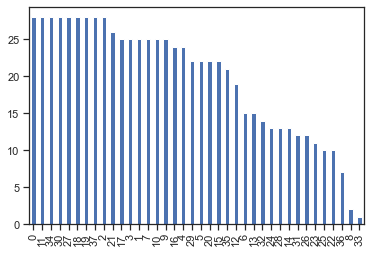

In [76]:
#Show number of windows for each segment to identify participants for discarding
data_participant = df_feature_extraction.loc[(df_feature_extraction['segment'] == 'Positive')]
data_participant = data_participant.reset_index(drop=True)
data_participant = data_participant.participant
data_participant.value_counts().plot.bar()

<AxesSubplot: >

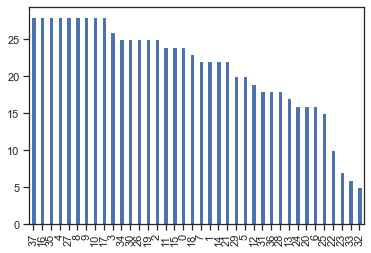

In [77]:
data_participant = df_feature_extraction.loc[(df_feature_extraction['segment'] == 'Negative')]
data_participant = data_participant.reset_index(drop=True)
data_participant = data_participant.participant
data_participant.value_counts().plot.bar()

<AxesSubplot: >

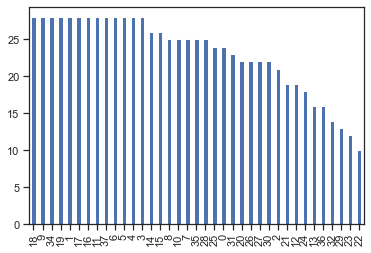

In [78]:
data_participant = df_feature_extraction.loc[(df_feature_extraction['segment'] == 'Neutral')]
data_participant = data_participant.reset_index(drop=True)
data_participant = data_participant.participant
data_participant.value_counts().plot.bar()

In [79]:
# Drop participants who have less than 10 windows in any segments (see plots above).
#df_feature_extraction.drop(df_feature_extraction.loc[df_feature_extraction['participant']==8].index, inplace=True)
#participants_to_discard = [8, 22, 23, 25, 32, 33, 36, 14]
participants_to_discard = [8, 22, 23, 25, 32, 33, 36, 14, 24, 28, 26, 31, 29]
df_feature_extraction.drop(df_feature_extraction.loc[df_feature_extraction['participant'].isin(participants_to_discard)].index, inplace=True)
df_feature_extraction = df_feature_extraction.reset_index(drop=True)

### 2.A) Barplots for features vs. affect segments

array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >], dtype=object)

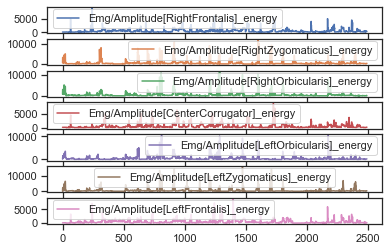

In [80]:
df_feature_extraction.loc[:,[str(x)+"_energy" for x in emg_colnames]].plot(subplots=True)

In [81]:
# Column names from feature extraction
HRV_SUBSET_FEATURES = ["HRV_MeanNN","HRV_SDNN","HRV_RMSSD","HRV_MedianNN", "HRV_IQRNN"]

In [82]:
# Average the feature values along the feature extraction windows
df_features_grouped_segment = df_feature_extraction.groupby(["participant","segment"]).mean().reset_index().drop(["i_window"], axis=1)
df_features_grouped_segment = df_features_grouped_segment.set_index(["segment"])
df_features_grouped_segment

,participant,w_center,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_SDSD,HRV_MedianNN,HRV_IQRNN,Mean_BPM,HeartRate/Average_mean,Ppg/Raw.ppg_mean,Ppg/Raw.proximity_mean,Accelerometer/Raw.x_mean,Accelerometer/Raw.y_mean,Accelerometer/Raw.z_mean,Magnetometer/Raw.x_mean,Magnetometer/Raw.y_mean,Magnetometer/Raw.z_mean,Gyroscope/Raw.x_mean,Gyroscope/Raw.y_mean,Gyroscope/Raw.z_mean,Emg/Amplitude[RightFrontalis]_mean,Emg/Amplitude[RightZygomaticus]_mean,Emg/Amplitude[RightOrbicularis]_mean,Emg/Amplitude[CenterCorrugator]_mean,Emg/Amplitude[LeftOrbicularis]_mean,Emg/Amplitude[LeftZygomaticus]_mean,Emg/Amplitude[LeftFrontalis]_mean,Emg/Contact[RightFrontalis]_mean,Emg/Contact[RightZygomaticus]_mean,Emg/Contact[RightOrbicularis]_mean,Emg/Contact[CenterCorrugator]_mean,Emg/Contact[LeftOrbicularis]_mean,Emg/Contact[LeftZygomaticus]_mean,Emg/Contact[LeftFrontalis]_mean,HeartRate/Average_std,Ppg/Raw.ppg_std,Ppg/Raw.proximity_std,Accelerometer/Raw.x_std,Accelerometer/Raw.y_std,...,Emg/Amplitude[RightFrontalis]_energy,Emg/Amplitude[RightZygomaticus]_energy,Emg/Amplitude[RightOrbicularis]_energy,Emg/Amplitude[CenterCorrugator]_energy,Emg/Amplitude[LeftOrbicularis]_energy,Emg/Amplitude[LeftZygomaticus]_energy,Emg/Amplitude[LeftFrontalis]_energy,Emg/Contact[RightFrontalis]_energy,Emg/Contact[RightZygomaticus]_energy,Emg/Contact[RightOrbicularis]_energy,Emg/Contact[CenterCorrugator]_energy,Emg/Contact[LeftOrbicularis]_energy,Emg/Contact[LeftZygomaticus]_energy,Emg/Contact[LeftFrontalis]_energy,HeartRate/Average_rms,Ppg/Raw.ppg_rms,Ppg/Raw.proximity_rms,Accelerometer/Raw.x_rms,Accelerometer/Raw.y_rms,Accelerometer/Raw.z_rms,Magnetometer/Raw.x_rms,Magnetometer/Raw.y_rms,Magnetometer/Raw.z_rms,Gyroscope/Raw.x_rms,Gyroscope/Raw.y_rms,Gyroscope/Raw.z_rms,Emg/Amplitude[RightFrontalis]_rms,Emg/Amplitude[RightZygomaticus]_rms,Emg/Amplitude[RightOrbicularis]_rms,Emg/Amplitude[CenterCorrugator]_rms,Emg/Amplitude[LeftOrbicularis]_rms,Emg/Amplitude[LeftZygomaticus]_rms,Emg/Amplitude[LeftFrontalis]_rms,Emg/Contact[RightFrontalis]_rms,Emg/Contact[RightZygomaticus]_rms,Emg/Contact[RightOrbicularis]_rms,Emg/Contact[CenterCorrugator]_rms,Emg/Contact[LeftOrbicularis]_rms,Emg/Contact[LeftZygomaticus]_rms,Emg/Contact[LeftFrontalis]_rms
segment,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Negative,0,154.583333,839.691137,56.366737,51.342006,52.055388,835.000000,69.375000,71.550167,-0.242238,-0.012071,0.052293,-0.527840,0.174765,-0.663826,0.587381,0.047584,0.484269,0.000230,0.028298,0.017298,0.040546,-0.276828,-0.211242,-0.017987,-0.102591,-0.129180,-0.032304,0.023143,0.004059,-0.030814,-0.016306,-0.076206,-0.008796,-0.154123,0.172457,1.003296,0.923947,0.448094,0.277108,...,50.436239,130.208416,183.768933,90.622779,224.757457,109.162959,32.770792,1.899002,1.590081,3.114111,1.823542,13.839581,1.935092,52.786568,0.397160,1.003535,0.942584,0.823286,0.398064,0.873042,0.950109,0.660418,0.852120,0.343702,0.642577,0.408968,0.176107,0.290701,0.316833,0.228970,0.363102,0.261956,0.145507,0.035107,0.032309,0.043623,0.034585,0.089383,0.035635,0.183468
Neutral,0,164.166667,821.517938,66.109411,76.805778,77.889929,820.833333,70.000000,73.203345,0.026239,0.005922,0.464705,0.194572,1.160843,0.418465,-0.153070,-0.902796,-0.618793,-0.006769,0.001543,0.021934,0.073838,-0.339655,-0.484591,0.282732,-0.420217,-0.453401,0.284159,0.005901,-0.036365,-0.080342,0.008389,-0.233698,-0.033723,-0.132541,0.263522,1.001300,0.985605,0.412656,0.340663,...,631.294206,174.238505,357.662191,740.153720,334.305895,315.124314,571.573114,1.778486,3.065814,10.922762,2.693876,84.341059,2.925163,76.036264,0.471306,1.001450,1.103052,0.516255,1.214434,0.687202,0.753634,1.296681,1.023062,0.755067,0.735857,0.700612,0.330393,0.340629,0.487781,0.490021,0.451319,0.456980,0.453609,0.034293,0.044911,0.084893,0.041132,0.235937,0.043997,0.209159
Positive,0,150.000000,816.050297,48.631672,39.569411,40.072712,815.714286,62.857143,73.606936,0.318635,0.002135,-0.298811,-0.219950,-1.056535,-0.451147,0.158

Functions to generate barplot

In [83]:
def convert_to_vertical_df(df_features):
    """
    Changes a dataframe to vertical version to make it compatible with
    seaborn plots.
    """
    # Change columns as rows to facilitate boxplots in seaborn
    df_vertical = None
    for c in df_features.columns:
        h_vertical_this = pd.DataFrame(data={
                                            "Affect Segment":df_features.index.values,
                                            "Feature Name":c,
                                            "Relative Variation":df_features[c].values
                                            })
        df_vertical = h_vertical_this if (df_vertical is None) else pd.concat([df_vertical, h_vertical_this], axis=0)
    return df_vertical


In [84]:
def plot_df_features_barplot(df_subset_features, ax=None, **kwargs):
    df_vertical = convert_to_vertical_df(df_subset_features)

    PALETTE_COLORS = [avdosvr.preprocessing.utils.enums.colourPaletteRGB.Negative.value,
                      avdosvr.preprocessing.utils.enums.colourPaletteRGB.Neutral.value,
                      avdosvr.preprocessing.utils.enums.colourPaletteRGB.Positive.value,
                      avdosvr.preprocessing.utils.enums.colourPaletteRGB.Relax.value]

    ax_plot = sns.barplot(data=df_vertical, ax=ax,
            x="Feature Name", y="Relative Variation", hue="Affect Segment",
            palette=PALETTE_COLORS,  **kwargs)
    return ax_plot

Heart rate

In [85]:
hr_feature_colnames = [ str(x)+"_mean" for x in avdosvr.preprocessing.COLNAMES_HR]
hr_feature_colnames

['HeartRate/Average_mean']

In [86]:
df_subset_features = df_features_grouped_segment.loc[:, hr_feature_colnames]
df_subset_features = df_subset_features.drop(['Resting_Negative'])
df_subset_features = df_subset_features.drop(['Resting_Positive'])
df_subset_features = df_subset_features.drop(['Resting_Neutral'])
df_subset_features

,HeartRate/Average_mean
segment,
Negative,-0.242238
Neutral,0.026239
Positive,0.318635
Negative,-0.109114
Neutral,-0.021133
...,...
Neutral,-0.679872
Positive,-0.433101
Negative,-0.255731


In [87]:
new_colnames = [ x.split("/")[0] for x in df_subset_features.columns]
new_colnames

['HeartRate']

In [88]:
df_subset_features.columns = new_colnames

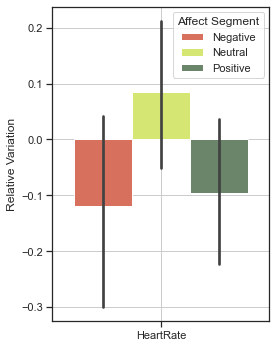

In [89]:
### Generate path to save and figure
save_path_plot = gen_path_plot(f"desc-barplot-hr")

NUM_ROWS = 1
NUM_COLS = 1
fig,axes = plt.subplots(NUM_ROWS, NUM_COLS, sharex=False, sharey=True, figsize=(4*NUM_COLS, 5*NUM_ROWS))

ax = axes
ax_i = plot_df_features_barplot(df_subset_features, ax=ax)
# ax_i.get_legend().remove()
ax.grid(True)
ax.set(xlabel=None)

plt.tight_layout()
plt.savefig(save_path_plot)

Heart Rate BPM

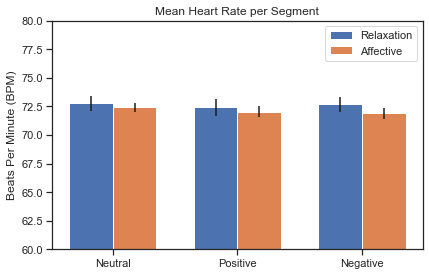

In [90]:
# Bar plot for Heart Rate (BPM)
df_subset_features = df_features_grouped_segment.loc[:, 'Mean_BPM']

segments = ['Neutral', 'Positive', 'Negative']
relax_means = [df_subset_features['Resting_Neutral'].mean(), 
               df_subset_features['Resting_Positive'].mean(), 
               df_subset_features['Resting_Negative'].mean()]

segment_means = [df_subset_features['Neutral'].mean(),
                 df_subset_features['Positive'].mean(),
                 df_subset_features['Negative'].mean()]

df_features_grouped_segment_se = df_feature_extraction.groupby(["participant","segment"]).sem().reset_index().drop(["i_window"], axis=1)
df_features_grouped_segment_se = df_features_grouped_segment_se.set_index(["segment"])
bpm_se = df_features_grouped_segment_se.loc[:, 'Mean_BPM']

relax_errors = [bpm_se['Resting_Neutral'].mean(), 
               bpm_se['Resting_Positive'].mean(), 
               bpm_se['Resting_Negative'].mean()]

segment_errors = [bpm_se['Neutral'].mean(),
                 bpm_se['Positive'].mean(),
                 bpm_se['Negative'].mean()]

x = np.arange(len(segments))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, relax_means, yerr=relax_errors, width=width, label='Relaxation')
rects2 = ax.bar(x + width/2, segment_means, yerr=segment_errors, width=width, label='Affective')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Beats Per Minute (BPM)')
ax.set_title('Mean Heart Rate per Segment')
ax.set_xticks(x, segments)
ax.legend()


fig.tight_layout()
plt.ylim(60,80)
save_path_plot = gen_path_plot(f"desc-barplot-hr-bpm")
plt.savefig(save_path_plot)
plt.show()

HR BPM Violin Plot

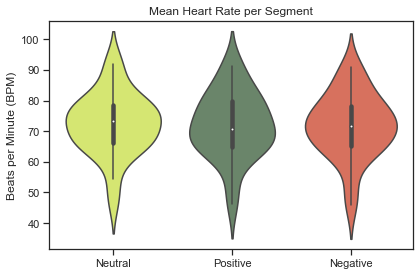

In [91]:
df_subset_features = df_features_grouped_segment.loc[:, 'Mean_BPM']
df_subset_features = df_subset_features.drop(['Resting_Negative'])
df_subset_features = df_subset_features.drop(['Resting_Positive'])
df_subset_features = df_subset_features.drop(['Resting_Neutral'])
df_hr = pd.DataFrame(df_subset_features)

violin_plot_colours = [avdosvr.preprocessing.utils.enums.colourPaletteRGB.Neutral.value,
                  avdosvr.preprocessing.utils.enums.colourPaletteRGB.Positive.value,
                  avdosvr.preprocessing.utils.enums.colourPaletteRGB.Negative.value]

violin_plot_order_rule = {
    "Neutral": 1,
    "Positive": 2,
    "Negative": 3
    }

def sort_violin_plot_order(series):
    """
    Must return one Series
    """
    return series.apply(lambda x: violin_plot_order_rule.get(x, 1000))

df_hr = df_hr.sort_values(by=['segment'], key=sort_violin_plot_order)

fig,axes = plt.subplots(1, 1, figsize=(6,4))
sns.set_style("whitegrid")
sns.violinplot(ax = axes, data=df_hr, x=df_hr.index, y="Mean_BPM", palette=violin_plot_colours).set(title='Mean Heart Rate per Segment')

plt.margins(x=0.05)
axes.set(xlabel=None)
plt.ylabel('Beats per Minute (BPM)')
fig.tight_layout()
save_path_plot = gen_path_plot(f"desc-violinplot-hr-bpm")
plt.savefig(save_path_plot)
plt.show()


In [92]:
neutral_bpm = df_subset_features['Neutral']
positive_bpm = df_subset_features['Positive']
negative_bpm = df_subset_features['Negative']

f_oneway(neutral_bpm, positive_bpm, negative_bpm)

F_onewayResult(statistic=0.01784336376587948, pvalue=0.98231922880642)

HRV

In [93]:
HRV_SUBSET_FEATURES

['HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_MedianNN', 'HRV_IQRNN']

In [94]:
df_subset_features = df_features_grouped_segment.loc[:, HRV_SUBSET_FEATURES]
df_subset_features = df_subset_features.drop(["HRV_MeanNN","HRV_MedianNN"],axis=1)
df_subset_features = df_subset_features.drop(['Resting_Negative'])
df_subset_features = df_subset_features.drop(['Resting_Positive'])
df_subset_features = df_subset_features.drop(['Resting_Neutral'])
df_subset_features

,HRV_SDNN,HRV_RMSSD,HRV_IQRNN
segment,,,
Negative,56.366737,51.342006,69.375000
Neutral,66.109411,76.805778,70.000000
Positive,48.631672,39.569411,62.857143
Negative,69.517459,83.324519,65.681818
Neutral,55.341728,62.671933,57.678571
...,...,...,...
Neutral,80.628912,109.917795,89.600000
Positive,104.972866,126.810656,125.000000
Negative,43.822328,36.431391,59.285714


In [95]:
#new_colnames = [ x.split("_")[1] for x in df_subset_features.columns]
new_colnames = ['sdnn', 'rmssd', 'sdsd']
new_colnames

['sdnn', 'rmssd', 'sdsd']

In [96]:
df_subset_features.columns = new_colnames

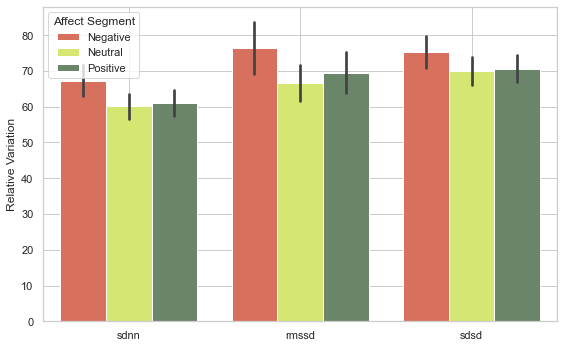

In [97]:
### Generate path to save and figure
save_path_plot = gen_path_plot(f"desc-barplot-hrv")

NUM_ROWS = 1
NUM_COLS = 1
fig,axes = plt.subplots(NUM_ROWS, NUM_COLS, sharex=False, sharey=True, figsize=(8*NUM_COLS, 5*NUM_ROWS))

ax = axes
ax_i = plot_df_features_barplot(df_subset_features, ax=ax, errorbar='se')
# ax_i.get_legend().remove()
ax.grid(True)
ax.set(xlabel=None)

plt.tight_layout()
plt.savefig(save_path_plot)

HRV Violin Plot

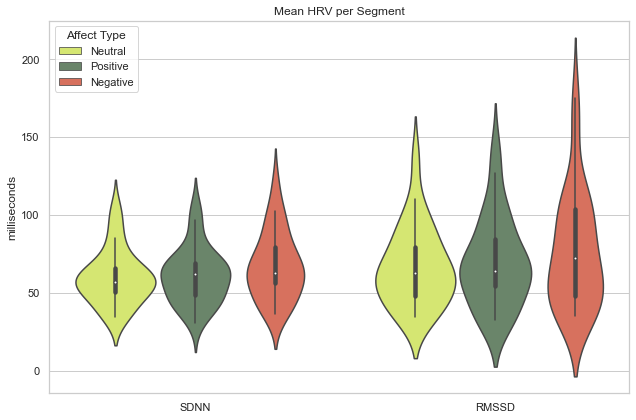

In [98]:
save_path_plot = gen_path_plot(f"desc-violinplot-hrv")
df_hrv = pd.DataFrame(df_subset_features)

violin_plot_colours = [avdosvr.preprocessing.utils.enums.colourPaletteRGB.Neutral.value,
                  avdosvr.preprocessing.utils.enums.colourPaletteRGB.Positive.value,
                  avdosvr.preprocessing.utils.enums.colourPaletteRGB.Negative.value]

violin_plot_order_rule = {
    "Neutral": 1,
    "Positive": 2,
    "Negative": 3
    }

def sort_violin_plot_order(series):
    """
    Must return one Series
    """
    return series.apply(lambda x: violin_plot_order_rule.get(x, 1000))

df_hrv = df_hrv.sort_values(by=['segment'], key=sort_violin_plot_order)

hrv_sdnn = pd.DataFrame(df_hrv['sdnn']).reset_index(level=0)
hrv_sdnn = hrv_sdnn.rename(columns={"sdnn": "HRV"})
hrv_sdnn['type']='SDNN'

hrv_rmssd = pd.DataFrame(df_hrv['rmssd']).reset_index(level=0)
hrv_rmssd = hrv_rmssd.rename(columns={"rmssd": "HRV"})
hrv_rmssd['type']='RMSSD'

hrv_sdsd = pd.DataFrame(df_hrv['sdsd']).reset_index(level=0)
hrv_sdsd = hrv_sdsd.rename(columns={"sdsd": "HRV"})
hrv_sdsd['type']='SDSD'

#Leave out SDSD as it's less common
#hrv_combined = pd.concat([hrv_sdnn,hrv_rmssd,hrv_sdsd],ignore_index=True)
hrv_combined = pd.concat([hrv_sdnn,hrv_rmssd],ignore_index=True)

hrv_combined = hrv_combined.sort_values(by=['segment'], key=sort_violin_plot_order)

fig,axes = plt.subplots(1, 1, figsize=(9,6))
sns.set_style("whitegrid")
sns.violinplot(ax = axes, data=hrv_combined, x="type", y="HRV", width=0.8, palette=violin_plot_colours, hue='segment').set(title='Mean HRV per Segment')
plt.margins(x=0.05)
axes.set(xlabel=None)
plt.ylabel('milliseconds')
plt.legend(title='Affect Type',loc='upper left')

plt.tight_layout()
plt.savefig(save_path_plot)

In [99]:
sdnn_neutral = df_subset_features.loc['Neutral']['sdnn']
sdnn_positive = df_subset_features.loc['Positive']['sdnn']
sdnn_negative = df_subset_features.loc['Negative']['sdnn']

rmssd_neutral = df_subset_features.loc['Neutral']['rmssd']
rmssd_positive = df_subset_features.loc['Positive']['rmssd']
rmssd_negative = df_subset_features.loc['Negative']['rmssd']

print(f_oneway(sdnn_neutral, sdnn_positive, sdnn_negative))
print(f_oneway(rmssd_neutral, rmssd_positive, rmssd_negative))

F_onewayResult(statistic=1.0567468732296035, pvalue=0.35291291656568685)
F_onewayResult(statistic=0.6677565961288301, pvalue=0.5160048632130432)


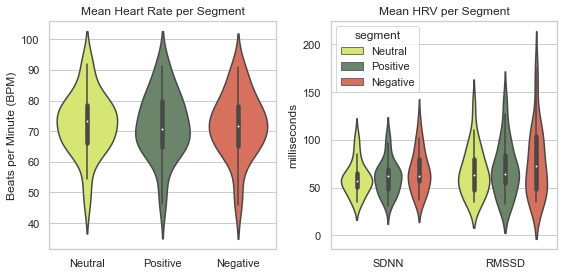

In [100]:
### Put this cell right before IMU plots

def violin_plot_hr(axes):
    df_subset_features = df_features_grouped_segment.loc[:, 'Mean_BPM']
    df_subset_features = df_subset_features.drop(['Resting_Negative'])
    df_subset_features = df_subset_features.drop(['Resting_Positive'])
    df_subset_features = df_subset_features.drop(['Resting_Neutral'])
    df_hr = pd.DataFrame(df_subset_features)

    violin_plot_colours = [avdosvr.preprocessing.utils.enums.colourPaletteRGB.Neutral.value,
                    avdosvr.preprocessing.utils.enums.colourPaletteRGB.Positive.value,
                    avdosvr.preprocessing.utils.enums.colourPaletteRGB.Negative.value]

    violin_plot_order_rule = {
        "Neutral": 1,
        "Positive": 2,
        "Negative": 3
        }

    def sort_violin_plot_order(series):
        """
        Must return one Series
        """
        return series.apply(lambda x: violin_plot_order_rule.get(x, 1000))

    df_hr = df_hr.sort_values(by=['segment'], key=sort_violin_plot_order)

    # fig,axes = plt.subplots(1, 1, figsize=(6,4))
    sns.set_style("whitegrid")
    sns.violinplot(ax = axes, data=df_hr, x=df_hr.index, y="Mean_BPM", palette=violin_plot_colours).set(title='Mean Heart Rate per Segment')
    axes.set(xlabel=None)
    axes.set(ylabel='Beats per Minute (BPM)')
    
    return axes

def violin_plot_hrv(axes):
    df_subset_features = df_features_grouped_segment.loc[:, HRV_SUBSET_FEATURES]
    df_subset_features = df_subset_features.drop(["HRV_MeanNN","HRV_MedianNN"],axis=1)
    df_subset_features = df_subset_features.drop(['Resting_Negative'])
    df_subset_features = df_subset_features.drop(['Resting_Positive'])
    df_subset_features = df_subset_features.drop(['Resting_Neutral'])
    # df_subset_features

    new_colnames = ['sdnn', 'rmssd', 'sdsd']
    df_subset_features.columns = new_colnames

    df_hrv = pd.DataFrame(df_subset_features)

    violin_plot_colours = [avdosvr.preprocessing.utils.enums.colourPaletteRGB.Neutral.value,
                    avdosvr.preprocessing.utils.enums.colourPaletteRGB.Positive.value,
                    avdosvr.preprocessing.utils.enums.colourPaletteRGB.Negative.value]

    violin_plot_order_rule = {
        "Neutral": 1,
        "Positive": 2,
        "Negative": 3
        }

    def sort_violin_plot_order(series):
        """
        Must return one Series
        """
        return series.apply(lambda x: violin_plot_order_rule.get(x, 1000))

    df_hrv = df_hrv.sort_values(by=['segment'], key=sort_violin_plot_order)

    hrv_sdnn = pd.DataFrame(df_hrv['sdnn']).reset_index(level=0)
    hrv_sdnn = hrv_sdnn.rename(columns={"sdnn": "HRV"})
    hrv_sdnn['type']='SDNN'

    hrv_rmssd = pd.DataFrame(df_hrv['rmssd']).reset_index(level=0)
    hrv_rmssd = hrv_rmssd.rename(columns={"rmssd": "HRV"})
    hrv_rmssd['type']='RMSSD'

    hrv_sdsd = pd.DataFrame(df_hrv['sdsd']).reset_index(level=0)
    hrv_sdsd = hrv_sdsd.rename(columns={"sdsd": "HRV"})
    hrv_sdsd['type']='SDSD'

    #Leave out SDSD as it's less common
    #hrv_combined = pd.concat([hrv_sdnn,hrv_rmssd,hrv_sdsd],ignore_index=True)
    hrv_combined = pd.concat([hrv_sdnn,hrv_rmssd],ignore_index=True)

    hrv_combined = hrv_combined.sort_values(by=['segment'], key=sort_violin_plot_order)

    # fig,axes = plt.subplots(1, 1, figsize=(9,6))
    sns.set_style("whitegrid")
    sns.violinplot(ax = axes, data=hrv_combined, x="type", y="HRV", width=0.8, palette=violin_plot_colours, hue='segment').set(title='Mean HRV per Segment')
    # plt.margins(x=0.05)
    axes.set(xlabel=None)
    axes.set(ylabel='milliseconds')
    # plt.legend(title='Affect Type',loc='upper left')


fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

violin_plot_hr(axes[0])
violin_plot_hrv(axes[1])

plt.margins(x=0.05)

fig.tight_layout()
save_path_plot = gen_path_plot(f"desc-violinplot-hr-hrv-combined")
plt.savefig(save_path_plot)
plt.show()

IMU

In [101]:
imu_feature_colnames = [ str(x)+"_rms" for x in imu_colnames]
imu_feature_colnames

['Accelerometer/Raw.x_rms',
 'Accelerometer/Raw.y_rms',
 'Accelerometer/Raw.z_rms',
 'Magnetometer/Raw.x_rms',
 'Magnetometer/Raw.y_rms',
 'Magnetometer/Raw.z_rms',
 'Gyroscope/Raw.x_rms',
 'Gyroscope/Raw.y_rms',
 'Gyroscope/Raw.z_rms']

In [102]:
df_subset_features = df_features_grouped_segment.loc[:, imu_feature_colnames]
# df_subset_features = df_subset_features.drop(["HRV_MeanNN","HRV_MedianNN"],axis=1)
df_subset_features

,Accelerometer/Raw.x_rms,Accelerometer/Raw.y_rms,Accelerometer/Raw.z_rms,Magnetometer/Raw.x_rms,Magnetometer/Raw.y_rms,Magnetometer/Raw.z_rms,Gyroscope/Raw.x_rms,Gyroscope/Raw.y_rms,Gyroscope/Raw.z_rms
segment,,,,,,,,,
Negative,0.823286,0.398064,0.873042,0.950109,0.660418,0.852120,0.343702,0.642577,0.408968
Neutral,0.516255,1.214434,0.687202,0.753634,1.296681,1.023062,0.755067,0.735857,0.700612
Positive,0.690426,1.149984,0.698336,0.722688,0.915169,0.824460,0.406854,0.695795,0.512493
Resting_Negative,0.620696,0.964684,0.468414,0.626494,0.646516,0.584382,0.270721,0.515196,0.339441
Resting_Neutral,1.217422,0.392644,1.469870,1.391805,0.632098,1.216234,0.386684,0.607864,0.510866
...,...,...,...,...,...,...,...,...,...
Neutral,0.988431,0.407496,1.018750,1.085857,0.721136,0.927233,0.587204,0.504874,0.454508
Positive,0.690811,1.438861,0.690266,0.632267,1.103374,0.872887,0.467247,0.491744,0.311376
Resting_Negative,0.730869,0.659467,0.850660,0.803060,0.887078,0.979719,0.387883,0.418893,0.285875


In [103]:
new_colnames = [ str(x)[:3]+"/"+x.split(".")[1][:1] for x in df_subset_features.columns]
df_subset_features.columns = new_colnames
df_subset_features = df_subset_features.drop(['Resting_Negative'])
df_subset_features = df_subset_features.drop(['Resting_Positive'])
df_subset_features = df_subset_features.drop(['Resting_Neutral'])
df_subset_features

,Acc/x,Acc/y,Acc/z,Mag/x,Mag/y,Mag/z,Gyr/x,Gyr/y,Gyr/z
segment,,,,,,,,,
Negative,0.823286,0.398064,0.873042,0.950109,0.660418,0.852120,0.343702,0.642577,0.408968
Neutral,0.516255,1.214434,0.687202,0.753634,1.296681,1.023062,0.755067,0.735857,0.700612
Positive,0.690426,1.149984,0.698336,0.722688,0.915169,0.824460,0.406854,0.695795,0.512493
Negative,0.381587,0.507134,0.347362,0.520217,0.585510,0.364441,0.229789,0.399075,0.305214
Neutral,0.414812,0.624292,0.372517,0.561601,0.652137,0.464913,0.556104,0.497065,0.519065
...,...,...,...,...,...,...,...,...,...
Neutral,0.715920,0.663562,0.706083,0.772225,0.857379,0.726999,0.564553,0.526372,0.555728
Positive,1.329368,0.903948,1.262224,1.210854,0.772582,1.038355,0.514062,0.689032,0.518801
Negative,0.935486,0.829586,0.879649,0.972722,0.937816,0.894674,0.542684,0.592305,0.350277


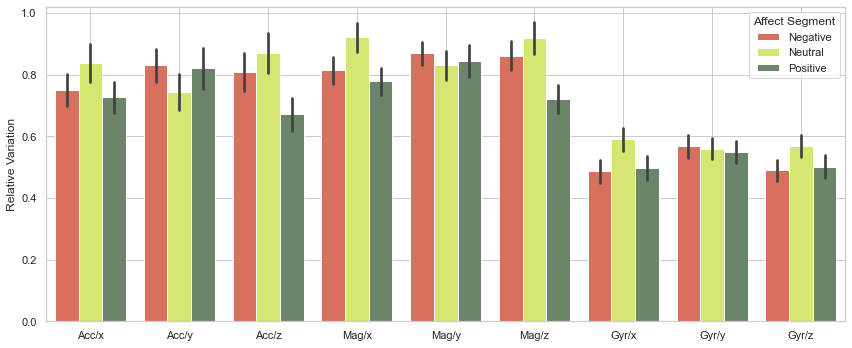

In [104]:
### Generate path to save and figure
save_path_plot = gen_path_plot(f"desc-barplot-imu")

NUM_ROWS = 1
NUM_COLS = 1
fig,axes = plt.subplots(NUM_ROWS, NUM_COLS, sharex=False, sharey=True, figsize=(12*NUM_COLS, 5*NUM_ROWS))

ax = axes
ax_i = plot_df_features_barplot(df_subset_features, ax=ax, errorbar='se')
# ax_i.get_legend().remove()
ax.grid(True)
ax.set(xlabel=None)

plt.tight_layout()
plt.savefig(save_path_plot)

In [105]:
#ANOVA TESTS
acc_x_neutral = df_subset_features.loc['Neutral']['Acc/x']
acc_x_positive = df_subset_features.loc['Positive']['Acc/x']
acc_x_negative = df_subset_features.loc['Negative']['Acc/x']

acc_y_neutral = df_subset_features.loc['Neutral']['Acc/y']
acc_y_positive = df_subset_features.loc['Positive']['Acc/y']
acc_y_negative = df_subset_features.loc['Negative']['Acc/y']

acc_z_neutral = df_subset_features.loc['Neutral']['Acc/z']
acc_z_positive = df_subset_features.loc['Positive']['Acc/z']
acc_z_negative = df_subset_features.loc['Negative']['Acc/z']

mag_x_neutral = df_subset_features.loc['Neutral']['Mag/x']
mag_x_positive = df_subset_features.loc['Positive']['Mag/x']
mag_x_negative = df_subset_features.loc['Negative']['Mag/x']

mag_y_neutral = df_subset_features.loc['Neutral']['Mag/y']
mag_y_positive = df_subset_features.loc['Positive']['Mag/y']
mag_y_negative = df_subset_features.loc['Negative']['Mag/y']

mag_z_neutral = df_subset_features.loc['Neutral']['Mag/z']
mag_z_positive = df_subset_features.loc['Positive']['Mag/z']
mag_z_negative = df_subset_features.loc['Negative']['Mag/z']

gyr_x_neutral = df_subset_features.loc['Neutral']['Gyr/x']
gyr_x_positive = df_subset_features.loc['Positive']['Gyr/x']
gyr_x_negative = df_subset_features.loc['Negative']['Gyr/x']

gyr_y_neutral = df_subset_features.loc['Neutral']['Gyr/y']
gyr_y_positive = df_subset_features.loc['Positive']['Gyr/y']
gyr_y_negative = df_subset_features.loc['Negative']['Gyr/y']

gyr_z_neutral = df_subset_features.loc['Neutral']['Gyr/z']
gyr_z_positive = df_subset_features.loc['Positive']['Gyr/z']
gyr_z_negative = df_subset_features.loc['Negative']['Gyr/z']

print('Acc_X: ' + str(f_oneway(acc_x_neutral, acc_x_positive, acc_x_negative)))
print('Acc_Y: ' + str(f_oneway(acc_y_neutral, acc_y_positive, acc_y_negative)))
print('Acc_Z: ' + str(f_oneway(acc_z_neutral, acc_z_positive, acc_z_negative)))
print('Mag_X: ' + str(f_oneway(mag_x_neutral, mag_x_positive, mag_x_negative)))
print('Mag_Y: ' + str(f_oneway(mag_y_neutral, mag_y_positive, mag_y_negative)))
print('Mag_Z ' + str(f_oneway(mag_z_neutral, mag_z_positive, mag_z_negative)))
print('Gyr_X: ' + str(f_oneway(gyr_x_neutral, gyr_x_positive, gyr_x_negative)))
print('Gyr_Y: ' + str(f_oneway(gyr_y_neutral, gyr_y_positive, gyr_y_negative)))
print('Gyr_Z: ' + str(f_oneway(gyr_z_neutral, gyr_z_positive, gyr_z_negative)))

Acc_X: F_onewayResult(statistic=1.1669176128008383, pvalue=0.3171424731326004)
Acc_Y: F_onewayResult(statistic=0.6205205294477378, pvalue=0.5405147561427309)
Acc_Z: F_onewayResult(statistic=2.8815188168222354, pvalue=0.06253657050343213)
Mag_X: F_onewayResult(statistic=2.775558515334814, pvalue=0.0689921683971514)
Mag_Y: F_onewayResult(statistic=0.1871259256743271, pvalue=0.8297413364980762)
Mag_Z F_onewayResult(statistic=4.543664358902016, pvalue=0.013856773015725864)
Gyr_X: F_onewayResult(statistic=2.2729943209078716, pvalue=0.11034741227193376)
Gyr_Y: F_onewayResult(statistic=0.06276685431981983, pvalue=0.9392137404278535)
Gyr_Z: F_onewayResult(statistic=1.3493199972973056, pvalue=0.2658966439838983)


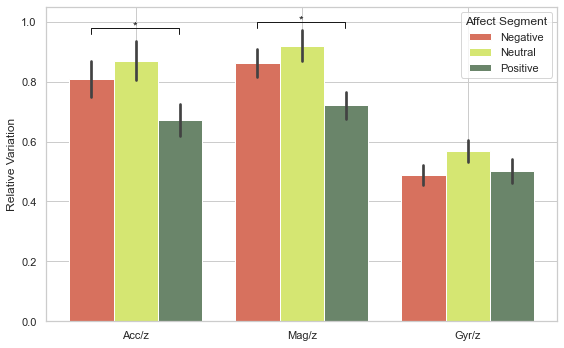

In [106]:
# IMU only Z axis
### Generate path to save and figure
save_path_plot = gen_path_plot(f"desc-barplot-imu-z-axis")

df_subset_features = df_subset_features[['Acc/z', 'Mag/z', 'Gyr/z']]

NUM_ROWS = 1
NUM_COLS = 1
fig,axes = plt.subplots(NUM_ROWS, NUM_COLS, sharex=False, sharey=True, figsize=(8*NUM_COLS, 5*NUM_ROWS))

ax = axes
ax_i = plot_df_features_barplot(df_subset_features, ax=ax, errorbar='se')
# ax_i.get_legend().remove()
ax.grid(True)
ax.set(xlabel=None)

### Acc Z axis Pos - Neg
plt.plot([-0.27,-0.27, 0.26, 0.26], [0.96, 0.98, 0.98, 0.96], linewidth=1, color='k')
plt.text((-0.27+0.26)*.5, 0.97, "*", ha='center', va='bottom', color='k')

### Mag Z axis Pos - Neg
plt.plot([0.73,0.73, 1.26, 1.26], [0.98, 1, 1, 0.98], linewidth=1, color='k')
plt.text((0.73+1.26)*.5, 0.99, "*", ha='center', va='bottom', color='k')

plt.tight_layout()
plt.savefig(save_path_plot)

In [107]:
# PLanned t tests

##Acc Z-axis
print('Acc Z-axis')
print('Pos-Neu: ' + str(stats.ttest_rel(acc_z_positive, acc_z_neutral, alternative='greater')))
print('Pos-Neg: ' + str(stats.ttest_rel(acc_z_positive, acc_z_negative, alternative='less')))
print('Neg-Neu: ' + str(stats.ttest_rel(acc_z_negative, acc_z_neutral,  alternative='greater')))

##Acc Z-axis
print('\nMag Z-axis')
print('Pos-Neu: ' + str(stats.ttest_rel(mag_z_positive, mag_z_neutral, alternative='greater')))
print('Pos-Neg: ' + str(stats.ttest_rel(mag_z_positive, mag_z_negative, alternative='less')))
print('Neg-Neu: ' + str(stats.ttest_rel(mag_z_negative, mag_z_neutral, alternative='greater')))

##Acc Z-axis
print('\nGyr Z-axis')
print('Pos-Neu: ' + str(stats.ttest_rel(gyr_z_positive, gyr_z_neutral, alternative='greater')))
print('Pos-Neg: ' + str(stats.ttest_rel(gyr_z_positive, gyr_z_negative, alternative='less')))
print('Neg-Neu: ' + str(stats.ttest_rel(gyr_z_negative, gyr_z_neutral, alternative='greater')))

Acc Z-axis
Pos-Neu: TtestResult(statistic=-2.128620293527115, pvalue=0.978125359122362, df=24)
Pos-Neg: TtestResult(statistic=-1.9029028714984793, pvalue=0.03455819829070462, df=24)
Neg-Neu: TtestResult(statistic=-0.5453317450426184, pvalue=0.7047209658694951, df=24)

Mag Z-axis
Pos-Neu: TtestResult(statistic=-2.7931310032172, pvalue=0.9949556025299202, df=24)
Pos-Neg: TtestResult(statistic=-2.286110432421053, pvalue=0.01568574001754653, df=24)
Neg-Neu: TtestResult(statistic=-0.7042833727378501, pvalue=0.7559827568893547, df=24)

Gyr Z-axis
Pos-Neu: TtestResult(statistic=-1.6437705492289494, pvalue=0.9433692749136064, df=24)
Pos-Neg: TtestResult(statistic=0.4428395414559354, pvalue=0.6690762085045436, df=24)
Neg-Neu: TtestResult(statistic=-2.148590777596522, pvalue=0.9790163415899531, df=24)


EMG Amplitude

In [108]:
emg_feature_colnames = [ str(x)+"_rms" for x in emg_colnames]
emg_feature_colnames

['Emg/Amplitude[RightFrontalis]_rms',
 'Emg/Amplitude[RightZygomaticus]_rms',
 'Emg/Amplitude[RightOrbicularis]_rms',
 'Emg/Amplitude[CenterCorrugator]_rms',
 'Emg/Amplitude[LeftOrbicularis]_rms',
 'Emg/Amplitude[LeftZygomaticus]_rms',
 'Emg/Amplitude[LeftFrontalis]_rms']

In [109]:
df_subset_features = df_features_grouped_segment.loc[:, emg_feature_colnames]
df_subset_features = df_subset_features.drop(['Resting_Negative'])
df_subset_features = df_subset_features.drop(['Resting_Positive'])
df_subset_features = df_subset_features.drop(['Resting_Neutral'])
df_subset_features

,Emg/Amplitude[RightFrontalis]_rms,Emg/Amplitude[RightZygomaticus]_rms,Emg/Amplitude[RightOrbicularis]_rms,Emg/Amplitude[CenterCorrugator]_rms,Emg/Amplitude[LeftOrbicularis]_rms,Emg/Amplitude[LeftZygomaticus]_rms,Emg/Amplitude[LeftFrontalis]_rms
segment,,,,,,,
Negative,0.176107,0.290701,0.316833,0.228970,0.363102,0.261956,0.145507
Neutral,0.330393,0.340629,0.487781,0.490021,0.451319,0.456980,0.453609
Positive,0.189390,1.063023,1.151048,0.302279,0.955030,1.127690,0.292995
Negative,0.368576,0.309004,0.314823,0.297190,0.270290,0.374189,0.478907
Neutral,0.282719,0.358775,0.332328,0.163994,0.277129,0.369459,0.313787
...,...,...,...,...,...,...,...
Neutral,0.438374,0.448559,0.379525,0.581291,0.256765,0.386144,0.530811
Positive,1.013248,1.145187,0.754525,0.860521,0.561678,0.992781,1.022140
Negative,0.676781,0.337476,0.192281,0.695516,0.275308,0.373781,0.558081


In [110]:
new_colnames = [ x.split("[")[1].split("]")[0] for x in df_subset_features.columns]
new_colnames
df_subset_features.columns = new_colnames
rearranged_emg_colnames = ['LeftFrontalis', 'RightFrontalis', 'CenterCorrugator', 'LeftOrbicularis', 
                           'RightOrbicularis', 'LeftZygomaticus', 'RightZygomaticus']
df_subset_features = df_subset_features[rearranged_emg_colnames]

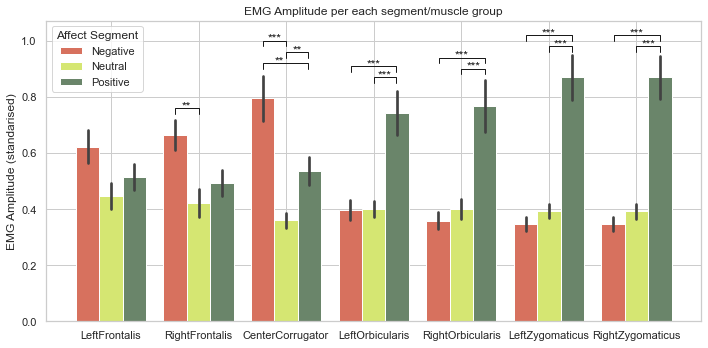

In [111]:
### Generate path to save and figure
save_path_plot = gen_path_plot(f"desc-barplot-emgAmplitude")

NUM_ROWS = 1
NUM_COLS = 1
fig,axes = plt.subplots(NUM_ROWS, NUM_COLS, sharex=False, sharey=True, figsize=(10*NUM_COLS, 5*NUM_ROWS))

PALETTE_COLORS = [avdosvr.preprocessing.utils.enums.colourPaletteRGB.Negative.value,
                  avdosvr.preprocessing.utils.enums.colourPaletteRGB.Neutral.value,
                  avdosvr.preprocessing.utils.enums.colourPaletteRGB.Positive.value,
                  avdosvr.preprocessing.utils.enums.colourPaletteRGB.Relax.value]

df_vertical = convert_to_vertical_df(df_subset_features)

ax = axes
ax_i = ax_plot = sns.barplot(data=df_vertical, ax=ax, x="Feature Name", y="Relative Variation", hue="Affect Segment", 
                      palette=PALETTE_COLORS, errorbar='se').set(title='EMG Amplitude per each segment/muscle group')

# Signififance annotations

## Positive - Neutral
### CCorrugator
plt.plot([2,2, 2.25, 2.25], [0.94, 0.96, 0.96, 0.94], linewidth=1, color='k')
plt.text((2+2.25)*.5, 0.95, "**", ha='center', va='bottom', color='k')

### LOrbicularis
plt.plot([3,3, 3.25, 3.25], [0.85, 0.87, 0.87, 0.85], linewidth=1, color='k')
plt.text((3+3.25)*.5, 0.86, "***", ha='center', va='bottom', color='k')

### ROrbicularis
plt.plot([4,4, 4.27, 4.27], [0.88, 0.90, 0.90, 0.88], linewidth=1, color='k')
plt.text((4+4.27)*.5, 0.89, "***", ha='center', va='bottom', color='k')

### Lzygomaticus
plt.plot([5,5, 5.26, 5.26], [0.96, 0.98, 0.98, 0.96], linewidth=1, color='k')
plt.text((5+5.26)*.5, 0.97, "***", ha='center', va='bottom', color='k')

### Rzygomaticus
plt.plot([6,6, 6.27, 6.27], [0.96, 0.98, 0.98, 0.96], linewidth=1, color='k')
plt.text((6+6.27)*.5, 0.97, "***", ha='center', va='bottom', color='k')



## Positive - Negative
### CCorrugator
plt.plot([1.74,1.74, 2.25, 2.25], [0.9, 0.92, 0.92, 0.9], linewidth=1, color='k')
plt.text((1.6+2.25)*.5, 0.91, "**", ha='center', va='bottom', color='k')

### LOrbicularis
plt.plot([2.74,2.74, 3.25, 3.25], [0.89, 0.91, 0.91, 0.89], linewidth=1, color='k')
plt.text((2.74+3.25)*.5, 0.90, "***", ha='center', va='bottom', color='k')

### ROrbicularis
plt.plot([3.74,3.74, 4.27, 4.27], [0.92, 0.94, 0.94, 0.92], linewidth=1, color='k')
plt.text((3.74+4.27)*.5, 0.93, "***", ha='center', va='bottom', color='k')

### Lzygomaticus
plt.plot([4.74,4.74, 5.26, 5.26], [1, 1.02, 1.02, 1], linewidth=1, color='k')
plt.text((4.74+5.26)*.5, 1.01, "***", ha='center', va='bottom', color='k')

### Rzygomaticus
plt.plot([5.74,5.74, 6.27, 6.27], [1, 1.02, 1.02, 1], linewidth=1, color='k')
plt.text((5.74+6.27)*.5, 1.01, "***", ha='center', va='bottom', color='k')



## Positive - Negative
### Rfrontalis
plt.plot([0.73,0.73, 1, 1], [0.74, 0.76, 0.76, 0.74], linewidth=1, color='k')
plt.text((0.73+1)*.5, 0.75, "**", ha='center', va='bottom', color='k')

### CCorrugator
plt.plot([1.74,1.74, 2, 2], [0.98, 1, 1, 0.98], linewidth=1, color='k')
plt.text((1.74+2)*.5, 0.99, "***", ha='center', va='bottom', color='k')


ax.grid(True)
ax.set(xlabel=None)
plt.ylabel('EMG Amplitude (standarised)')



plt.tight_layout()
plt.savefig(save_path_plot)

In [112]:
#ANOVA TESTS
left_frontalis_neutral = df_subset_features.loc['Neutral']['LeftFrontalis']
left_frontalis_positive = df_subset_features.loc['Positive']['LeftFrontalis']
left_frontalis_negative = df_subset_features.loc['Negative']['LeftFrontalis']

right_frontalis_neutral = df_subset_features.loc['Neutral']['RightFrontalis']
right_frontalis_positive = df_subset_features.loc['Positive']['RightFrontalis']
right_frontalis_negative = df_subset_features.loc['Negative']['RightFrontalis']

center_corrugator_neutral = df_subset_features.loc['Neutral']['CenterCorrugator']
center_corrugator_positive = df_subset_features.loc['Positive']['CenterCorrugator']
center_corrugator_negative = df_subset_features.loc['Negative']['CenterCorrugator']

left_orbicularis_neutral = df_subset_features.loc['Neutral']['LeftOrbicularis']
left_orbicularis_positive = df_subset_features.loc['Positive']['LeftOrbicularis']
left_orbicularis_negative = df_subset_features.loc['Negative']['LeftOrbicularis']

right_orbicularis_neutral = df_subset_features.loc['Neutral']['RightOrbicularis']
right_orbicularis_positive = df_subset_features.loc['Positive']['RightOrbicularis']
right_orbicularis_negative = df_subset_features.loc['Negative']['RightOrbicularis']

left_zygomaticus_neutral = df_subset_features.loc['Neutral']['LeftZygomaticus']
left_zygomaticus_positive = df_subset_features.loc['Positive']['LeftZygomaticus']
left_zygomaticus_negative = df_subset_features.loc['Negative']['LeftZygomaticus']

right_zygomaticus_neutral = df_subset_features.loc['Neutral']['RightZygomaticus']
right_zygomaticus_positive = df_subset_features.loc['Positive']['RightZygomaticus']
right_zygomaticus_negative = df_subset_features.loc['Negative']['RightZygomaticus']

print('Lfrontalis: ' + str(f_oneway(left_frontalis_neutral, left_frontalis_positive, left_frontalis_negative)))
print('Rfrontalis: ' + str(f_oneway(right_frontalis_neutral, right_frontalis_positive, right_frontalis_negative)))
print('Ccorrugator: ' + str(f_oneway(center_corrugator_neutral, center_corrugator_positive, center_corrugator_negative)))
print('LOrbicularis: ' + str(f_oneway(left_orbicularis_neutral, left_orbicularis_positive, left_orbicularis_negative)))
print('ROrbicularis: ' + str(f_oneway(right_orbicularis_neutral, right_orbicularis_positive, right_orbicularis_negative)))
print('Lzygomaticus: ' + str(f_oneway(left_zygomaticus_neutral, left_zygomaticus_positive, left_zygomaticus_negative)))
print('Rzygomaticus: ' + str(f_oneway(right_zygomaticus_neutral, right_zygomaticus_positive, right_zygomaticus_negative)))

Lfrontalis: F_onewayResult(statistic=2.9976805083988487, pvalue=0.05616865918375475)
Rfrontalis: F_onewayResult(statistic=6.093073803174285, pvalue=0.0035917570957682047)
Ccorrugator: F_onewayResult(statistic=15.214491058693925, pvalue=3.0813924985200528e-06)
LOrbicularis: F_onewayResult(statistic=14.266283676991595, pvalue=6.0384576568383005e-06)
ROrbicularis: F_onewayResult(statistic=14.289519148831856, pvalue=5.9388264932403635e-06)
Lzygomaticus: F_onewayResult(statistic=33.4839620871423, pvalue=5.2365510317072264e-11)
Rzygomaticus: F_onewayResult(statistic=33.81712770268377, pvalue=4.408174980513187e-11)


In [113]:
#T-TESTS

bonferroni_correction = 7
decimal_places = 3
print('Bonferonni correction for 7 tests applied. P value multiplied by 7.\n')
#Positive - Neutral
Pos_Neu_LF_test_value, Pos_Neu_LF_p_value, = stats.ttest_rel(left_frontalis_positive, left_frontalis_neutral)
Pos_Neu_RF_test_value, Pos_Neu_RF_p_value, = stats.ttest_rel(right_frontalis_positive, right_frontalis_neutral)
Pos_Neu_CC_test_value, Pos_Neu_CC_p_value, = stats.ttest_rel(center_corrugator_positive, center_corrugator_neutral)
Pos_Neu_LO_test_value, Pos_Neu_LO_p_value, = stats.ttest_rel(left_orbicularis_positive, left_orbicularis_neutral)
Pos_Neu_RO_test_value, Pos_Neu_RO_p_value, = stats.ttest_rel(right_orbicularis_positive, right_orbicularis_neutral)
Pos_Neu_LZ_test_value, Pos_Neu_LZ_p_value, = stats.ttest_rel(left_zygomaticus_positive, left_zygomaticus_neutral)
Pos_Neu_RZ_test_value, Pos_Neu_RZ_p_value, = stats.ttest_rel(right_zygomaticus_positive, right_zygomaticus_neutral)

print('Positive - Neutral')
print('Lfrontalis - statistic=' + str(round(Pos_Neu_LF_test_value, decimal_places)) + ', p=' + str(round(Pos_Neu_LF_p_value*bonferroni_correction, decimal_places)))
print('Rfrontalis - statistic=' + str(round(Pos_Neu_RF_test_value, decimal_places)) + ', p=' + str(round(Pos_Neu_RF_p_value*bonferroni_correction, decimal_places)))
print('Ccorrugator - statistic=' + str(round(Pos_Neu_CC_test_value, decimal_places)) + ', p=' + str(round(Pos_Neu_CC_p_value*bonferroni_correction, decimal_places)))
print('LOrbicularis - statistic=' + str(round(Pos_Neu_LO_test_value, decimal_places)) + ', p=' + str(round(Pos_Neu_LO_p_value*bonferroni_correction, decimal_places)))
print('ROrbicularis - statistic=' + str(round(Pos_Neu_RO_test_value, decimal_places)) + ', p=' + str(round(Pos_Neu_RO_p_value*bonferroni_correction, decimal_places)))
print('Lzygomaticus - statistic=' + str(round(Pos_Neu_LZ_test_value, decimal_places)) + ', p=' + str(round(Pos_Neu_LZ_p_value*bonferroni_correction, decimal_places)))
print('Rzygomaticus - statistic=' + str(round(Pos_Neu_RZ_test_value, decimal_places)) + ', p=' + str(round(Pos_Neu_RZ_p_value*bonferroni_correction, decimal_places)))

#Positive - Negative
Pos_Neg_LF_test_value, Pos_Neg_LF_p_value, = stats.ttest_rel(left_frontalis_positive, left_frontalis_negative)
Pos_Neg_RF_test_value, Pos_Neg_RF_p_value, = stats.ttest_rel(right_frontalis_positive, right_frontalis_negative)
Pos_Neg_CC_test_value, Pos_Neg_CC_p_value, = stats.ttest_rel(center_corrugator_positive, center_corrugator_negative)
Pos_Neg_LO_test_value, Pos_Neg_LO_p_value, = stats.ttest_rel(left_orbicularis_positive, left_orbicularis_negative)
Pos_Neg_RO_test_value, Pos_Neg_RO_p_value, = stats.ttest_rel(right_orbicularis_positive, right_orbicularis_negative)
Pos_Neg_LZ_test_value, Pos_Neg_LZ_p_value, = stats.ttest_rel(left_zygomaticus_positive, left_zygomaticus_negative)
Pos_Neg_RZ_test_value, Pos_Neg_RZ_p_value, = stats.ttest_rel(right_zygomaticus_positive, right_zygomaticus_negative)

print('\nPositive - Negative')
print('Lfrontalis - statistic=' + str(round(Pos_Neg_LF_test_value, decimal_places)) + ', p=' + str(round(Pos_Neg_LF_p_value*bonferroni_correction, decimal_places)))
print('Rfrontalis - statistic=' + str(round(Pos_Neg_RF_test_value, decimal_places)) + ', p=' + str(round(Pos_Neg_RF_p_value*bonferroni_correction, decimal_places)))
print('Ccorrugator - statistic=' + str(round(Pos_Neg_CC_test_value, decimal_places)) + ', p=' + str(round(Pos_Neg_CC_p_value*bonferroni_correction, decimal_places)))
print('LOrbicularis - statistic=' + str(round(Pos_Neg_LO_test_value, decimal_places)) + ', p=' + str(round(Pos_Neg_LO_p_value*bonferroni_correction, decimal_places)))
print('ROrbicularis - statistic=' + str(round(Pos_Neg_RO_test_value, decimal_places)) + ', p=' + str(round(Pos_Neg_RO_p_value*bonferroni_correction, decimal_places)))
print('Lzygomaticus - statistic=' + str(round(Pos_Neg_LZ_test_value, decimal_places)) + ', p=' + str(round(Pos_Neg_LZ_p_value*bonferroni_correction, decimal_places)))
print('Rzygomaticus - statistic=' + str(round(Pos_Neg_RZ_test_value, decimal_places)) + ', p=' + str(round(Pos_Neg_RZ_p_value*bonferroni_correction, decimal_places)))

#Negative - Neutral
Neg_Neu_LF_test_value, Neg_Neu_LF_p_value, = stats.ttest_rel(left_frontalis_negative, left_frontalis_neutral)
Neg_Neu_RF_test_value, Neg_Neu_RF_p_value, = stats.ttest_rel(right_frontalis_negative, right_frontalis_neutral)
Neg_Neu_CC_test_value, Neg_Neu_CC_p_value, = stats.ttest_rel(center_corrugator_negative, center_corrugator_neutral)
Neg_Neu_LO_test_value, Neg_Neu_LO_p_value, = stats.ttest_rel(left_orbicularis_negative, left_orbicularis_neutral)
Neg_Neu_RO_test_value, Neg_Neu_RO_p_value, = stats.ttest_rel(right_orbicularis_negative, right_orbicularis_neutral)
Neg_Neu_LZ_test_value, Neg_Neu_LZ_p_value, = stats.ttest_rel(left_zygomaticus_negative, left_zygomaticus_neutral)
Neg_Neu_RZ_test_value, Neg_Neu_RZ_p_value, = stats.ttest_rel(right_zygomaticus_negative, right_zygomaticus_neutral)

print('\nNegative - Neutral')
print('Lfrontalis - statistic=' + str(round(Neg_Neu_LF_test_value, decimal_places)) + ', p=' + str(round(Neg_Neu_LF_p_value*bonferroni_correction, decimal_places)))
print('Rfrontalis - statistic=' + str(round(Neg_Neu_RF_test_value, decimal_places)) + ', p=' + str(round(Neg_Neu_RF_p_value*bonferroni_correction, decimal_places)))
print('Ccorrugator - statistic=' + str(round(Neg_Neu_CC_test_value, decimal_places)) + ', p=' + str(round(Neg_Neu_CC_p_value*bonferroni_correction, decimal_places)))
print('LOrbicularis - statistic=' + str(round(Neg_Neu_LO_test_value, decimal_places)) + ', p=' + str(round(Neg_Neu_LO_p_value*bonferroni_correction, decimal_places)))
print('ROrbicularis - statistic=' + str(round(Neg_Neu_RO_test_value, decimal_places)) + ', p=' + str(round(Neg_Neu_RO_p_value*bonferroni_correction, decimal_places)))
print('Lzygomaticus - statistic=' + str(round(Neg_Neu_LZ_test_value, decimal_places)) + ', p=' + str(round(Neg_Neu_LZ_p_value*bonferroni_correction, decimal_places)))
print('Rzygomaticus - statistic=' + str(round(Neg_Neu_RZ_test_value, decimal_places)) + ', p=' + str(round(Neg_Neu_RZ_p_value*bonferroni_correction, decimal_places)))


Bonferonni correction for 7 tests applied. P value multiplied by 7.

Positive - Neutral
Lfrontalis - statistic=1.592, p=0.871
Rfrontalis - statistic=1.473, p=1.075
Ccorrugator - statistic=4.267, p=0.002
LOrbicularis - statistic=5.266, p=0.0
ROrbicularis - statistic=5.137, p=0.0
Lzygomaticus - statistic=6.909, p=0.0
Rzygomaticus - statistic=7.311, p=0.0

Positive - Negative
Lfrontalis - statistic=-1.602, p=0.856
Rfrontalis - statistic=-2.922, p=0.052
Ccorrugator - statistic=-4.526, p=0.001
LOrbicularis - statistic=5.184, p=0.0
ROrbicularis - statistic=5.787, p=0.0
Lzygomaticus - statistic=7.323, p=0.0
Rzygomaticus - statistic=7.673, p=0.0

Negative - Neutral
Lfrontalis - statistic=2.33, p=0.2
Rfrontalis - statistic=3.322, p=0.02
Ccorrugator - statistic=5.354, p=0.0
LOrbicularis - statistic=-0.074, p=6.589
ROrbicularis - statistic=-1.548, p=0.943
Lzygomaticus - statistic=-2.028, p=0.376
Rzygomaticus - statistic=-2.229, p=0.248


EMG Contact

In [114]:
emg_contact_feature_colnames = [ str(x)+"_rms" for x in emg_contact_colnames]
emg_contact_feature_colnames

['Emg/Contact[RightFrontalis]_rms',
 'Emg/Contact[RightZygomaticus]_rms',
 'Emg/Contact[RightOrbicularis]_rms',
 'Emg/Contact[CenterCorrugator]_rms',
 'Emg/Contact[LeftOrbicularis]_rms',
 'Emg/Contact[LeftZygomaticus]_rms',
 'Emg/Contact[LeftFrontalis]_rms']

In [115]:
df_subset_features = df_features_grouped_segment.loc[:, emg_contact_feature_colnames]
df_subset_features = df_subset_features.drop(['Resting_Negative'])
df_subset_features = df_subset_features.drop(['Resting_Positive'])
df_subset_features = df_subset_features.drop(['Resting_Neutral'])
df_subset_features

,Emg/Contact[RightFrontalis]_rms,Emg/Contact[RightZygomaticus]_rms,Emg/Contact[RightOrbicularis]_rms,Emg/Contact[CenterCorrugator]_rms,Emg/Contact[LeftOrbicularis]_rms,Emg/Contact[LeftZygomaticus]_rms,Emg/Contact[LeftFrontalis]_rms
segment,,,,,,,
Negative,0.035107,0.032309,0.043623,0.034585,0.089383,0.035635,0.183468
Neutral,0.034293,0.044911,0.084893,0.041132,0.235937,0.043997,0.209159
Positive,0.062933,0.049533,0.082235,0.030524,0.202260,0.037646,0.222566
Negative,0.343281,0.208928,0.264175,0.749775,0.404931,0.230850,0.252381
Neutral,0.166782,0.078149,0.134521,0.329266,0.122686,0.070683,0.101793
...,...,...,...,...,...,...,...
Neutral,0.251834,0.613144,0.589335,0.912164,0.936829,0.686562,0.114777
Positive,0.324829,1.909079,1.338268,0.531001,0.579971,1.922918,0.287666
Negative,0.153145,0.072941,0.188664,0.116306,0.070692,0.163599,0.151751


In [116]:
new_colnames = [ x.split("[")[1].split("]")[0] for x in df_subset_features.columns]
new_colnames

['RightFrontalis',
 'RightZygomaticus',
 'RightOrbicularis',
 'CenterCorrugator',
 'LeftOrbicularis',
 'LeftZygomaticus',
 'LeftFrontalis']

In [117]:
df_subset_features.columns = new_colnames
df_subset_features

,RightFrontalis,RightZygomaticus,RightOrbicularis,CenterCorrugator,LeftOrbicularis,LeftZygomaticus,LeftFrontalis
segment,,,,,,,
Negative,0.035107,0.032309,0.043623,0.034585,0.089383,0.035635,0.183468
Neutral,0.034293,0.044911,0.084893,0.041132,0.235937,0.043997,0.209159
Positive,0.062933,0.049533,0.082235,0.030524,0.202260,0.037646,0.222566
Negative,0.343281,0.208928,0.264175,0.749775,0.404931,0.230850,0.252381
Neutral,0.166782,0.078149,0.134521,0.329266,0.122686,0.070683,0.101793
...,...,...,...,...,...,...,...
Neutral,0.251834,0.613144,0.589335,0.912164,0.936829,0.686562,0.114777
Positive,0.324829,1.909079,1.338268,0.531001,0.579971,1.922918,0.287666
Negative,0.153145,0.072941,0.188664,0.116306,0.070692,0.163599,0.151751


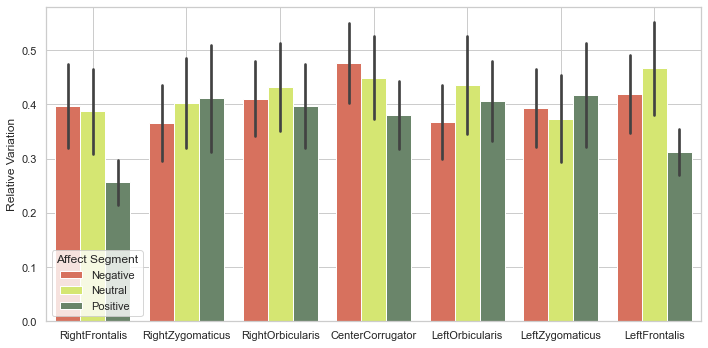

In [118]:
### Generate path to save and figure
save_path_plot = gen_path_plot(f"desc-barplot-emgContact")

NUM_ROWS = 1
NUM_COLS = 1
fig,axes = plt.subplots(NUM_ROWS, NUM_COLS, sharex=False, sharey=True, figsize=(10*NUM_COLS, 5*NUM_ROWS))

ax = axes
ax_i = plot_df_features_barplot(df_subset_features, ax=ax, errorbar='se')
# ax_i.get_legend().remove()
ax.grid(True)
ax.set(xlabel=None)
# ax.tick_params(axis='x', labelrotation = 45)

plt.tight_layout()
plt.savefig(save_path_plot)

---
## Analysis 3: Classification

- Select subset of features: `[Cardiac, Motor, Facial]`
- Configure the train-test strategy for CV with [Leave-One-Subject-Out (LOSO)](https://scikit-learn.org/stable/modules/cross_validation.html#leave-one-group-out)

In [119]:
# Used to define the segments of interest and the mapping for classifiers
CLASSES_MAPPING = {
            "Negative": -1,
            "Neutral": 0,
            "Positive": 1,
            }
CLASSES_MAPPING_INVERSE = { v:k for k,v in CLASSES_MAPPING.items()}

In [120]:
data_X = df_feature_extraction.loc[(df_feature_extraction['segment'] == 'Positive')  | 
                                   (df_feature_extraction['segment'] == 'Negative') | 
                                   (df_feature_extraction['segment'] == 'Neutral')]
data_X = data_X.reset_index(drop=True)
data_X = data_X.drop(["segment"], axis=1)
data_X

,participant,i_window,w_center,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_SDSD,HRV_MedianNN,HRV_IQRNN,Mean_BPM,HeartRate/Average_mean,Ppg/Raw.ppg_mean,Ppg/Raw.proximity_mean,Accelerometer/Raw.x_mean,Accelerometer/Raw.y_mean,Accelerometer/Raw.z_mean,Magnetometer/Raw.x_mean,Magnetometer/Raw.y_mean,Magnetometer/Raw.z_mean,Gyroscope/Raw.x_mean,Gyroscope/Raw.y_mean,Gyroscope/Raw.z_mean,Emg/Amplitude[RightFrontalis]_mean,Emg/Amplitude[RightZygomaticus]_mean,Emg/Amplitude[RightOrbicularis]_mean,Emg/Amplitude[CenterCorrugator]_mean,Emg/Amplitude[LeftOrbicularis]_mean,Emg/Amplitude[LeftZygomaticus]_mean,Emg/Amplitude[LeftFrontalis]_mean,Emg/Contact[RightFrontalis]_mean,Emg/Contact[RightZygomaticus]_mean,Emg/Contact[RightOrbicularis]_mean,Emg/Contact[CenterCorrugator]_mean,Emg/Contact[LeftOrbicularis]_mean,Emg/Contact[LeftZygomaticus]_mean,Emg/Contact[LeftFrontalis]_mean,HeartRate/Average_std,Ppg/Raw.ppg_std,Ppg/Raw.proximity_std,Accelerometer/Raw.x_std,...,Emg/Amplitude[RightFrontalis]_energy,Emg/Amplitude[RightZygomaticus]_energy,Emg/Amplitude[RightOrbicularis]_energy,Emg/Amplitude[CenterCorrugator]_energy,Emg/Amplitude[LeftOrbicularis]_energy,Emg/Amplitude[LeftZygomaticus]_energy,Emg/Amplitude[LeftFrontalis]_energy,Emg/Contact[RightFrontalis]_energy,Emg/Contact[RightZygomaticus]_energy,Emg/Contact[RightOrbicularis]_energy,Emg/Contact[CenterCorrugator]_energy,Emg/Contact[LeftOrbicularis]_energy,Emg/Contact[LeftZygomaticus]_energy,Emg/Contact[LeftFrontalis]_energy,HeartRate/Average_rms,Ppg/Raw.ppg_rms,Ppg/Raw.proximity_rms,Accelerometer/Raw.x_rms,Accelerometer/Raw.y_rms,Accelerometer/Raw.z_rms,Magnetometer/Raw.x_rms,Magnetometer/Raw.y_rms,Magnetometer/Raw.z_rms,Gyroscope/Raw.x_rms,Gyroscope/Raw.y_rms,Gyroscope/Raw.z_rms,Emg/Amplitude[RightFrontalis]_rms,Emg/Amplitude[RightZygomaticus]_rms,Emg/Amplitude[RightOrbicularis]_rms,Emg/Amplitude[CenterCorrugator]_rms,Emg/Amplitude[LeftOrbicularis]_rms,Emg/Amplitude[LeftZygomaticus]_rms,Emg/Amplitude[LeftFrontalis]_rms,Emg/Contact[RightFrontalis]_rms,Emg/Contact[RightZygomaticus]_rms,Emg/Contact[RightOrbicularis]_rms,Emg/Contact[CenterCorrugator]_rms,Emg/Contact[LeftOrbicularis]_rms,Emg/Contact[LeftZygomaticus]_rms,Emg/Contact[LeftFrontalis]_rms
0,0,0,15.0,798.918919,31.603778,26.246693,26.619005,800.0,40.0,75.111431,-0.117674,-0.018847,-0.460378,0.136000,-1.492945,0.067237,-0.389583,0.622601,0.064267,-0.008435,-0.013119,0.017082,-0.182925,0.546278,0.583235,-0.299536,-0.250712,-0.042927,-0.238755,-0.060936,0.001273,0.076105,-0.000220,0.272776,0.027338,0.222725,0.107743,0.916681,0.806098,0.726400,...,55.833330,654.883240,770.668416,148.501033,151.063322,49.956061,95.083050,7.183945,2.612928,10.334664,1.027618,113.089847,2.433486,76.589097,0.159548,0.916874,0.928301,0.739021,1.537711,0.179824,0.626355,0.916974,0.608033,0.338654,0.651333,0.440244,0.192866,0.660529,0.716545,0.314539,0.317241,0.182433,0.251687,0.069182,0.041723,0.082977,0.026165,0.274487,0.040265,0.225888
1,0,1,25.0,790.000000,33.295216,36.095112,36.622076,780.0,45.0,75.994305,0.076762,0.010308,-0.425375,0.066079,-1.590690,-0.083755,-0.349682,0.603969,0.151714,-0.002364,0.009627,-0.002995,-0.177261,1.022142,1.043440,-0.293037,0.259414,0.486342,-0.250211,-0.056069,0.002895,0.082377,0.000945,0.278169,0.022958,0.225893,0.267749,0.899319,0.796120,0.687173,...,50.917556,3292.119287,3045.027006,141.280304,1260.260101,2138.349818,105.528876,6.228431,3.224662,12.544846,1.043194,117.885950,2.482265,79.227879,0.278535,0.899378,0.902636,0.690343,1.628923,0.304278,0.621729,0.886106,0.656440,0.383782,0.745983,0.495398,0.184180,1.480974,1.424312,0.306797,0.916304,1.193573,0.265152,0.064417,0.046350,0.091420,0.026363,0.280247,0.040666,0.229746
2,0,2,35.0,803.888889,39.372055,34.475664,34.978985,800.0,60.0,74.657658,0.364017,0.000579,-0.325190,-0.009772,-1.604667,-0.223572,-0.255371,0.608252,0.225543,0.005488,0.012706,-0.004557,-0.179840,1.003880,1.040547,-0.292419,0.505043,0.652711,-0.278972,-0.060821,0.001982,0.083477,-0.002070,0.275630,0.019654,0.212793,

<AxesSubplot: >

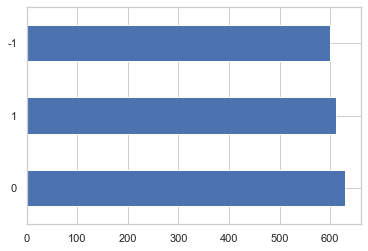

In [121]:
data_Y = df_feature_extraction.loc[(df_feature_extraction['segment'] == 'Positive')  | 
                                   (df_feature_extraction['segment'] == 'Negative') | 
                                   (df_feature_extraction['segment'] == 'Neutral')]
data_Y = data_Y.reset_index(drop=True)
data_Y = data_Y["segment"].map(CLASSES_MAPPING)
data_Y.value_counts().plot.barh()

<AxesSubplot: >

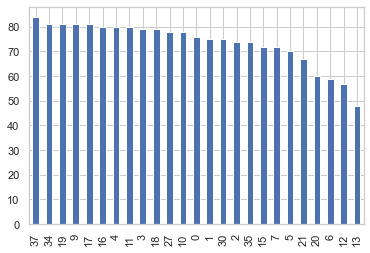

In [122]:
data_participant = df_feature_extraction.loc[(df_feature_extraction['segment'] == 'Positive')  | 
                                   (df_feature_extraction['segment'] == 'Negative') | 
                                   (df_feature_extraction['segment'] == 'Neutral')]
data_participant = data_participant.reset_index(drop=True)
data_participant = data_participant.participant
data_participant.value_counts().plot.bar()

### Feature selection per data modality

In [123]:
hrv_colnames = data_X.columns[ [ (col.startswith("HRV") | col.startswith("HeartRate") | col.startswith("Ppg/")) for col in data_X.columns] ].sort_values().values
hrv_colnames

array(['HRV_IQRNN', 'HRV_MeanNN', 'HRV_MedianNN', 'HRV_RMSSD', 'HRV_SDNN',
       'HRV_SDSD', 'HeartRate/Average_energy', 'HeartRate/Average_irq',
       'HeartRate/Average_kurt', 'HeartRate/Average_max',
       'HeartRate/Average_mean', 'HeartRate/Average_median',
       'HeartRate/Average_min', 'HeartRate/Average_pnv',
       'HeartRate/Average_ppv', 'HeartRate/Average_rms',
       'HeartRate/Average_skew', 'HeartRate/Average_std',
       'Ppg/Raw.ppg_energy', 'Ppg/Raw.ppg_irq', 'Ppg/Raw.ppg_kurt',
       'Ppg/Raw.ppg_max', 'Ppg/Raw.ppg_mean', 'Ppg/Raw.ppg_median',
       'Ppg/Raw.ppg_min', 'Ppg/Raw.ppg_pnv', 'Ppg/Raw.ppg_ppv',
       'Ppg/Raw.ppg_rms', 'Ppg/Raw.ppg_skew', 'Ppg/Raw.ppg_std',
       'Ppg/Raw.proximity_energy', 'Ppg/Raw.proximity_irq',
       'Ppg/Raw.proximity_kurt', 'Ppg/Raw.proximity_max',
       'Ppg/Raw.proximity_mean', 'Ppg/Raw.proximity_median',
       'Ppg/Raw.proximity_min', 'Ppg/Raw.proximity_pnv',
       'Ppg/Raw.proximity_ppv', 'Ppg/Raw.proximity_rms',
    

In [124]:
imu_colnames = data_X.columns[ [ (col.startswith("Accelerometer")) | (col.startswith("Magnetometer")) | (col.startswith("Gyroscope")) for col in data_X.columns] ].sort_values().values
imu_colnames

array(['Accelerometer/Raw.x_energy', 'Accelerometer/Raw.x_irq',
       'Accelerometer/Raw.x_kurt', 'Accelerometer/Raw.x_max',
       'Accelerometer/Raw.x_mean', 'Accelerometer/Raw.x_median',
       'Accelerometer/Raw.x_min', 'Accelerometer/Raw.x_pnv',
       'Accelerometer/Raw.x_ppv', 'Accelerometer/Raw.x_rms',
       'Accelerometer/Raw.x_skew', 'Accelerometer/Raw.x_std',
       'Accelerometer/Raw.y_energy', 'Accelerometer/Raw.y_irq',
       'Accelerometer/Raw.y_kurt', 'Accelerometer/Raw.y_max',
       'Accelerometer/Raw.y_mean', 'Accelerometer/Raw.y_median',
       'Accelerometer/Raw.y_min', 'Accelerometer/Raw.y_pnv',
       'Accelerometer/Raw.y_ppv', 'Accelerometer/Raw.y_rms',
       'Accelerometer/Raw.y_skew', 'Accelerometer/Raw.y_std',
       'Accelerometer/Raw.z_energy', 'Accelerometer/Raw.z_irq',
       'Accelerometer/Raw.z_kurt', 'Accelerometer/Raw.z_max',
       'Accelerometer/Raw.z_mean', 'Accelerometer/Raw.z_median',
       'Accelerometer/Raw.z_min', 'Accelerometer/Raw.z_pnv'

In [125]:
emg_amp_colnames = data_X.columns[ [ (col.startswith("Emg/Amplitude")) for col in data_X.columns] ].sort_values().values
emg_amp_colnames

array(['Emg/Amplitude[CenterCorrugator]_energy',
       'Emg/Amplitude[CenterCorrugator]_irq',
       'Emg/Amplitude[CenterCorrugator]_kurt',
       'Emg/Amplitude[CenterCorrugator]_max',
       'Emg/Amplitude[CenterCorrugator]_mean',
       'Emg/Amplitude[CenterCorrugator]_median',
       'Emg/Amplitude[CenterCorrugator]_min',
       'Emg/Amplitude[CenterCorrugator]_pnv',
       'Emg/Amplitude[CenterCorrugator]_ppv',
       'Emg/Amplitude[CenterCorrugator]_rms',
       'Emg/Amplitude[CenterCorrugator]_skew',
       'Emg/Amplitude[CenterCorrugator]_std',
       'Emg/Amplitude[LeftFrontalis]_energy',
       'Emg/Amplitude[LeftFrontalis]_irq',
       'Emg/Amplitude[LeftFrontalis]_kurt',
       'Emg/Amplitude[LeftFrontalis]_max',
       'Emg/Amplitude[LeftFrontalis]_mean',
       'Emg/Amplitude[LeftFrontalis]_median',
       'Emg/Amplitude[LeftFrontalis]_min',
       'Emg/Amplitude[LeftFrontalis]_pnv',
       'Emg/Amplitude[LeftFrontalis]_ppv',
       'Emg/Amplitude[LeftFrontalis]_rms',
 

In [126]:
emg_cont_colnames = data_X.columns[ [ (col.startswith("Emg/Contact")) for col in data_X.columns] ].sort_values().values
emg_cont_colnames

array(['Emg/Contact[CenterCorrugator]_energy',
       'Emg/Contact[CenterCorrugator]_irq',
       'Emg/Contact[CenterCorrugator]_kurt',
       'Emg/Contact[CenterCorrugator]_max',
       'Emg/Contact[CenterCorrugator]_mean',
       'Emg/Contact[CenterCorrugator]_median',
       'Emg/Contact[CenterCorrugator]_min',
       'Emg/Contact[CenterCorrugator]_pnv',
       'Emg/Contact[CenterCorrugator]_ppv',
       'Emg/Contact[CenterCorrugator]_rms',
       'Emg/Contact[CenterCorrugator]_skew',
       'Emg/Contact[CenterCorrugator]_std',
       'Emg/Contact[LeftFrontalis]_energy',
       'Emg/Contact[LeftFrontalis]_irq',
       'Emg/Contact[LeftFrontalis]_kurt',
       'Emg/Contact[LeftFrontalis]_max',
       'Emg/Contact[LeftFrontalis]_mean',
       'Emg/Contact[LeftFrontalis]_median',
       'Emg/Contact[LeftFrontalis]_min', 'Emg/Contact[LeftFrontalis]_pnv',
       'Emg/Contact[LeftFrontalis]_ppv', 'Emg/Contact[LeftFrontalis]_rms',
       'Emg/Contact[LeftFrontalis]_skew',
       'Emg/Conta

In [127]:
print(f"HRV {hrv_colnames.size}")
print(f"IMU {imu_colnames.size}")
print(f"EMG Amplitude {emg_amp_colnames.size}")
print(f"EMG Contact {emg_cont_colnames.size}")

HRV 42
IMU 108
EMG Amplitude 84
EMG Contact 84


### Correlation plots

Standardize [$\mathcal{N}(0,1)$] each of the column features and map the correlation among variables and vs. target variable `segment`.

In [128]:
# Name and columns of the corresponding data modalities
corr_plots_config = {
    "hrv": hrv_colnames,
    "imu": imu_colnames,
    "emg_amp": emg_amp_colnames,
    "emg_cont": emg_cont_colnames,
}

for k,v in corr_plots_config.items():
    # Select subfeatures from large dataset
    df_plot = df_feature_extraction[v]
    # Standardize the features (but not the target)
    df_plot = pd.DataFrame(data=StandardScaler().fit_transform(df_plot), 
                            columns=df_plot.columns, 
                            index=df_plot.index)
    # Concatenate target and features from the specific modality
    df_plot = pd.concat([data_Y, df_plot],axis=1)

    # Generate correlation plot and save DataFrame as HTML (it's not a matplotlib Figure)
    save_path_plot = gen_path_plot(f"Features/_CorrelationPlot_{k}", extension=".html")
    corr = df_plot.corr()
    corr_style = corr.style.background_gradient(cmap='coolwarm', axis=None).format(precision=2)
    corr_style.to_html(save_path_plot)


### Classification models

Important reading: [Common pitfalls in the interpretation of coeffs in linear models.](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#sphx-glr-auto-examples-inspection-plot-linear-model-coefficient-interpretation-py)

In [129]:
# FEATURE-BASED CLASSIFIERS CLASSIFIERS SETUP
MC_RANDOM_SEED = 1234
N_SPLITS_CV = 10 # Number of folds for Cross-validation

# Scoring parameters: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
SCORING_METRICS = ["accuracy", "f1_macro", "precision_macro", "recall_macro"]

*Testing Classification pipeline*

In [130]:
## Example of iterator for Cross-validation per subject

# Feature subset
feature_subset_colnames = hrv_colnames   # imu_colnames, emg_amp_colnames, emg_cont_colnames

# Features
x = data_X[feature_subset_colnames]
# Target
y = data_Y
# Groups indices (participants' ids)
group_cv = data_participant

loso_cv = LeaveOneGroupOut()
cv_splits = loso_cv.split(x, y, groups=group_cv)
for trn_idx, tst_idx in cv_splits:
    print("TRN: %s \t TST: %s" % (data_participant[trn_idx].unique(), data_participant[tst_idx].unique()))

TRN: [ 1  2  3  4  5  6  7  9 10 11 12 13 15 16 17 18 19 20 21 27 30 34 35 37] 	 TST: [0]
TRN: [ 0  2  3  4  5  6  7  9 10 11 12 13 15 16 17 18 19 20 21 27 30 34 35 37] 	 TST: [1]
TRN: [ 0  1  3  4  5  6  7  9 10 11 12 13 15 16 17 18 19 20 21 27 30 34 35 37] 	 TST: [2]
TRN: [ 0  1  2  4  5  6  7  9 10 11 12 13 15 16 17 18 19 20 21 27 30 34 35 37] 	 TST: [3]
TRN: [ 0  1  2  3  5  6  7  9 10 11 12 13 15 16 17 18 19 20 21 27 30 34 35 37] 	 TST: [4]
TRN: [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 21 27 30 34 35 37] 	 TST: [5]
TRN: [ 0  1  2  3  4  5  7  9 10 11 12 13 15 16 17 18 19 20 21 27 30 34 35 37] 	 TST: [6]
TRN: [ 0  1  2  3  4  5  6  9 10 11 12 13 15 16 17 18 19 20 21 27 30 34 35 37] 	 TST: [7]
TRN: [ 0  1  2  3  4  5  6  7 10 11 12 13 15 16 17 18 19 20 21 27 30 34 35 37] 	 TST: [9]
TRN: [ 0  1  2  3  4  5  6  7  9 11 12 13 15 16 17 18 19 20 21 27 30 34 35 37] 	 TST: [10]
TRN: [ 0  1  2  3  4  5  6  7  9 10 12 13 15 16 17 18 19 20 21 27 30 34 35 37] 	 TST: [11]
TRN: [ 0

In [131]:
# Deep learner Keras CLassifier

from scikeras.wrappers import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

from tensorflow import keras
def get_clf(meta, hidden_layer_sizes, dropout):
    n_features_in_ = meta["n_features_in_"]
    n_classes_ = meta["n_classes_"]
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(n_features_in_,)))
    for hidden_layer_size in hidden_layer_sizes:
        model.add(keras.layers.Dense(hidden_layer_size, activation="relu"))
        model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(3, activation="sigmoid"))
    return model

clf = KerasClassifier(
    model=get_clf,
    loss="CategoricalCrossentropy",
    optimizer="adam",
    optimizer__learning_rate=0.1,
    model__hidden_layer_sizes=(100,),
    model__dropout=0.5,
    verbose=False,
)

### Apply classification task

In [132]:
data_modality_colnames = { 
            "hrv": hrv_colnames, 
            "imu": imu_colnames, 
            "emg_amp": emg_amp_colnames,
            "emg_cont": emg_cont_colnames,
            "all": list(hrv_colnames) + list(imu_colnames) + list(emg_amp_colnames) + list(emg_cont_colnames),
    }

# ClassifierName: {"clf":model, "pgrid":parameters)
classifiers_hyperparams = {
    "LinearRidge": {    "clf": RidgeClassifier(alpha=0.01, max_iter=1000), # n_class classifiers are trained in a one-versus-all approach. Concretely, taking advantage of the multi-variate response support in Ridge
                        "pgrid": {'alpha': np.logspace(-5, 5,11) }},
    "GaussianSVM": {    "clf": SVC(kernel='rbf', gamma='auto', C = 1),          # Multilabel in one-vs-one approach
                        "pgrid": {'C': [1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001]}},
    "RF": {             "clf": RandomForestClassifier(criterion='entropy', random_state=MC_RANDOM_SEED, class_weight="balanced"), # Multilabel classification
                        "pgrid": {'n_estimators': [10, 50, 100], 'max_depth': [5, 10, 20]}},
    "KNN": {            "clf": KNeighborsClassifier(),
                        "pgrid": {'n_neighbors': [1, 5, 11, 15]}},
    "DL": {
    "clf": KerasClassifier(
        model=get_clf,
        loss="categorical_crossentropy",
        optimizer="adam",
        optimizer__learning_rate=0.1,
        model__hidden_layer_sizes=(100,),
        model__dropout=0.5,
        verbose=False,
    ),
    "pgrid": {
        'optimizer__learning_rate': [0.05, 0.001],
        'model__hidden_layer_sizes': [(100, ), (50, 50, )],
        'model__dropout': [0, 0.5],
    },
    },

    }

The execution below takes around 150min

In [133]:
# Loading all segments for all participants and store the resting and video parts in a single large CSV.

DATASET_POSTPROCESSED_FILENAME = gen_path_temp("Results_ModelTrainingCV_PerDataModalityPerSubject_25p", extension=".csv")

output_filename = DATASET_POSTPROCESSED_FILENAME

# Variable to store the final dataset
df_results_hyperparam_opt = None

# Check if file already exists
if (os.path.isfile(output_filename)):
    df_results_hyperparam_opt = pd.read_csv(output_filename)
    print(f"File loaded from path!")
# Otherwise generate it
else:
    print(f"Generating file!")
    
    ## Iteration per data type
    for modality_name, modality_colnames in data_modality_colnames.items(): 

        # modality_name = "hrv"
        # modality_colnames = data_modality_colnames[modality_name]
        #### ABOVE FOR TESTING

        # Subset of features
        data_mod_x = data_X[modality_colnames].values.copy()   # Features
        data_mod_y = data_Y.values.copy()       # Target
        subject_ids = data_participant.values.copy()  # Groups indices (participants' ids)

        # Split dataset with LOSO-CV
        cv_loso_subj = LeaveOneGroupOut()
        cv_splits_subjects = cv_loso_subj.split(data_mod_x, data_mod_y, groups=subject_ids)

        # Iteration per subject (participant)
        for trn_subj_idx, tst_subj_idx in cv_splits_subjects:

            # The dataset that is not belonging to the TEST subject will be further divided for hyperparam optimization.
            x = data_mod_x[trn_subj_idx]             # Data to be used to create a model for TEST subject
            x_test_subj = data_mod_x[tst_subj_idx]
            y = data_mod_y[trn_subj_idx]
            y_test_subj = data_mod_y[tst_subj_idx]
            subjects_cv = data_participant[trn_subj_idx].values
            subject_in_test_set = np.unique(data_participant[tst_subj_idx].values)[0]   # Store the participant id in the test set
            
            # print(f"TRAIN SUBJECT IDS: {np.unique(subjects_cv)} \t TEST SUBJECT: {subject_in_test_set}")
            # print(f"SHAPE : x:{x.shape}, x_test_subj:{x_test_subj.shape}, y:{y.shape}, y_test_subj:{y_test_subj.shape}, subjects_cv:{subjects_cv.shape}")

            # Create pipeline
            scaler = StandardScaler().fit(x)
            x_scaled = scaler.transform(x)

            for clf_name, clf_data in classifiers_hyperparams.items(): 
                # clf_name = "GaussianSVM"
                # clf_data = classifiers_hyperparams[clf_name]
                #### ABOVE FOR TESTING

                clf = clf_data["clf"]
                pgrid = clf_data["pgrid"]
                                
                # Leave-One-Subject-Out CV also to optimize the hyperparameters and select a model
                cv_loso_fold = LeaveOneGroupOut()
                cv_fold_per_subject = cv_loso_subj.split(x, y, groups = subjects_cv)    

                gr_search = GridSearchCV(clf, pgrid, cv=cv_fold_per_subject, scoring=SCORING_METRICS, refit="accuracy", n_jobs=-1)
                gr_search.fit(x_scaled, y)

                # Get results per fold and add best results
                df_this_hyperparam_optim = pd.DataFrame(gr_search.cv_results_)
                df_this_hyperparam_optim.insert(0,"best_trn_score_", str(gr_search.best_score_))
                df_this_hyperparam_optim.insert(0,"best_params_", str(gr_search.best_params_))
                df_this_hyperparam_optim.insert(0,"best_estimator_", str(gr_search.best_estimator_))

                # Insert general information in long format
                df_this_hyperparam_optim.insert(0,"classifier", clf_name)
                df_this_hyperparam_optim.insert(0, "test_subject_id",subject_in_test_set)
                df_this_hyperparam_optim.insert(0, "data_modality", modality_name)
                df_this_hyperparam_optim.insert(0, "pipeline_step", "hyperparam_opt")

                # Append to the main dataframe with the results 
                df_results_hyperparam_opt = df_this_hyperparam_optim if (df_results_hyperparam_opt is None) else pd.concat([df_results_hyperparam_opt, df_this_hyperparam_optim], axis=0, ignore_index=True)
                
                print(f"Data modality: {modality_name} | Clf: {clf_name} | Subject: {subject_in_test_set} ")

                # Saving .csv
                df_results_hyperparam_opt.to_csv( output_filename, index=False)

            # End of classifiers
        # End of subjects

        # # Saving .csv every iteration
        # df_results_hyperparam_opt.to_csv( output_filename )
    print("\n\n End")

Generating file!
Data modality: hrv | Clf: LinearRidge | Subject: 0 
Data modality: hrv | Clf: GaussianSVM | Subject: 0 
Data modality: hrv | Clf: RF | Subject: 0 
Data modality: hrv | Clf: KNN | Subject: 0 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: hrv | Clf: DL | Subject: 0 
Data modality: hrv | Clf: LinearRidge | Subject: 1 
Data modality: hrv | Clf: GaussianSVM | Subject: 1 
Data modality: hrv | Clf: RF | Subject: 1 
Data modality: hrv | Clf: KNN | Subject: 1 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: hrv | Clf: DL | Subject: 1 
Data modality: hrv | Clf: LinearRidge | Subject: 2 
Data modality: hrv | Clf: GaussianSVM | Subject: 2 
Data modality: hrv | Clf: RF | Subject: 2 
Data modality: hrv | Clf: KNN | Subject: 2 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: hrv | Clf: DL | Subject: 2 
Data modality: hrv | Clf: LinearRidge | Subject: 3 
Data modality: hrv | Clf: GaussianSVM | Subject: 3 
Data modality: hrv | Clf: RF | Subject: 3 
Data modality: hrv | Clf: KNN | Subject: 3 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: hrv | Clf: DL | Subject: 3 
Data modality: hrv | Clf: LinearRidge | Subject: 4 
Data modality: hrv | Clf: GaussianSVM | Subject: 4 
Data modality: hrv | Clf: RF | Subject: 4 
Data modality: hrv | Clf: KNN | Subject: 4 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: hrv | Clf: DL | Subject: 4 
Data modality: hrv | Clf: LinearRidge | Subject: 5 
Data modality: hrv | Clf: GaussianSVM | Subject: 5 
Data modality: hrv | Clf: RF | Subject: 5 
Data modality: hrv | Clf: KNN | Subject: 5 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: hrv | Clf: DL | Subject: 5 
Data modality: hrv | Clf: LinearRidge | Subject: 6 
Data modality: hrv | Clf: GaussianSVM | Subject: 6 
Data modality: hrv | Clf: RF | Subject: 6 
Data modality: hrv | Clf: KNN | Subject: 6 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: hrv | Clf: DL | Subject: 6 
Data modality: hrv | Clf: LinearRidge | Subject: 7 
Data modality: hrv | Clf: GaussianSVM | Subject: 7 
Data modality: hrv | Clf: RF | Subject: 7 
Data modality: hrv | Clf: KNN | Subject: 7 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: hrv | Clf: DL | Subject: 7 
Data modality: hrv | Clf: LinearRidge | Subject: 9 
Data modality: hrv | Clf: GaussianSVM | Subject: 9 
Data modality: hrv | Clf: RF | Subject: 9 
Data modality: hrv | Clf: KNN | Subject: 9 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: hrv | Clf: DL | Subject: 9 
Data modality: hrv | Clf: LinearRidge | Subject: 10 
Data modality: hrv | Clf: GaussianSVM | Subject: 10 
Data modality: hrv | Clf: RF | Subject: 10 
Data modality: hrv | Clf: KNN | Subject: 10 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: hrv | Clf: DL | Subject: 10 
Data modality: hrv | Clf: LinearRidge | Subject: 11 
Data modality: hrv | Clf: GaussianSVM | Subject: 11 
Data modality: hrv | Clf: RF | Subject: 11 
Data modality: hrv | Clf: KNN | Subject: 11 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: hrv | Clf: DL | Subject: 11 
Data modality: hrv | Clf: LinearRidge | Subject: 12 
Data modality: hrv | Clf: GaussianSVM | Subject: 12 
Data modality: hrv | Clf: RF | Subject: 12 
Data modality: hrv | Clf: KNN | Subject: 12 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: hrv | Clf: DL | Subject: 12 
Data modality: hrv | Clf: LinearRidge | Subject: 13 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Data modality: hrv | Clf: GaussianSVM | Subject: 13 
Data modality: hrv | Clf: RF | Subject: 13 
Data modality: hrv | Clf: KNN | Subject: 13 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: hrv | Clf: DL | Subject: 13 
Data modality: hrv | Clf: LinearRidge | Subject: 15 
Data modality: hrv | Clf: GaussianSVM | Subject: 15 
Data modality: hrv | Clf: RF | Subject: 15 
Data modality: hrv | Clf: KNN | Subject: 15 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: hrv | Clf: DL | Subject: 15 
Data modality: hrv | Clf: LinearRidge | Subject: 16 
Data modality: hrv | Clf: GaussianSVM | Subject: 16 
Data modality: hrv | Clf: RF | Subject: 16 
Data modality: hrv | Clf: KNN | Subject: 16 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: hrv | Clf: DL | Subject: 16 
Data modality: hrv | Clf: LinearRidge | Subject: 17 
Data modality: hrv | Clf: GaussianSVM | Subject: 17 
Data modality: hrv | Clf: RF | Subject: 17 
Data modality: hrv | Clf: KNN | Subject: 17 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: hrv | Clf: DL | Subject: 17 
Data modality: hrv | Clf: LinearRidge | Subject: 18 
Data modality: hrv | Clf: GaussianSVM | Subject: 18 
Data modality: hrv | Clf: RF | Subject: 18 
Data modality: hrv | Clf: KNN | Subject: 18 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: hrv | Clf: DL | Subject: 18 
Data modality: hrv | Clf: LinearRidge | Subject: 19 
Data modality: hrv | Clf: GaussianSVM | Subject: 19 
Data modality: hrv | Clf: RF | Subject: 19 
Data modality: hrv | Clf: KNN | Subject: 19 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: hrv | Clf: DL | Subject: 19 
Data modality: hrv | Clf: LinearRidge | Subject: 20 
Data modality: hrv | Clf: GaussianSVM | Subject: 20 
Data modality: hrv | Clf: RF | Subject: 20 
Data modality: hrv | Clf: KNN | Subject: 20 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: hrv | Clf: DL | Subject: 20 
Data modality: hrv | Clf: LinearRidge | Subject: 21 
Data modality: hrv | Clf: GaussianSVM | Subject: 21 
Data modality: hrv | Clf: RF | Subject: 21 
Data modality: hrv | Clf: KNN | Subject: 21 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: hrv | Clf: DL | Subject: 21 
Data modality: hrv | Clf: LinearRidge | Subject: 27 
Data modality: hrv | Clf: GaussianSVM | Subject: 27 
Data modality: hrv | Clf: RF | Subject: 27 
Data modality: hrv | Clf: KNN | Subject: 27 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: hrv | Clf: DL | Subject: 27 
Data modality: hrv | Clf: LinearRidge | Subject: 30 
Data modality: hrv | Clf: GaussianSVM | Subject: 30 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Data modality: hrv | Clf: RF | Subject: 30 
Data modality: hrv | Clf: KNN | Subject: 30 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: hrv | Clf: DL | Subject: 30 
Data modality: hrv | Clf: LinearRidge | Subject: 34 
Data modality: hrv | Clf: GaussianSVM | Subject: 34 
Data modality: hrv | Clf: RF | Subject: 34 
Data modality: hrv | Clf: KNN | Subject: 34 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: hrv | Clf: DL | Subject: 34 
Data modality: hrv | Clf: LinearRidge | Subject: 35 
Data modality: hrv | Clf: GaussianSVM | Subject: 35 
Data modality: hrv | Clf: RF | Subject: 35 
Data modality: hrv | Clf: KNN | Subject: 35 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: hrv | Clf: DL | Subject: 35 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Data modality: hrv | Clf: LinearRidge | Subject: 37 
Data modality: hrv | Clf: GaussianSVM | Subject: 37 
Data modality: hrv | Clf: RF | Subject: 37 
Data modality: hrv | Clf: KNN | Subject: 37 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: hrv | Clf: DL | Subject: 37 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Data modality: imu | Clf: LinearRidge | Subject: 0 
Data modality: imu | Clf: GaussianSVM | Subject: 0 
Data modality: imu | Clf: RF | Subject: 0 
Data modality: imu | Clf: KNN | Subject: 0 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: imu | Clf: DL | Subject: 0 
Data modality: imu | Clf: LinearRidge | Subject: 1 
Data modality: imu | Clf: GaussianSVM | Subject: 1 
Data modality: imu | Clf: RF | Subject: 1 
Data modality: imu | Clf: KNN | Subject: 1 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: imu | Clf: DL | Subject: 1 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Data modality: imu | Clf: LinearRidge | Subject: 2 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Data modality: imu | Clf: GaussianSVM | Subject: 2 
Data modality: imu | Clf: RF | Subject: 2 
Data modality: imu | Clf: KNN | Subject: 2 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: imu | Clf: DL | Subject: 2 
Data modality: imu | Clf: LinearRidge | Subject: 3 
Data modality: imu | Clf: GaussianSVM | Subject: 3 
Data modality: imu | Clf: RF | Subject: 3 
Data modality: imu | Clf: KNN | Subject: 3 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: imu | Clf: DL | Subject: 3 
Data modality: imu | Clf: LinearRidge | Subject: 4 
Data modality: imu | Clf: GaussianSVM | Subject: 4 
Data modality: imu | Clf: RF | Subject: 4 
Data modality: imu | Clf: KNN | Subject: 4 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: imu | Clf: DL | Subject: 4 
Data modality: imu | Clf: LinearRidge | Subject: 5 
Data modality: imu | Clf: GaussianSVM | Subject: 5 
Data modality: imu | Clf: RF | Subject: 5 
Data modality: imu | Clf: KNN | Subject: 5 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: imu | Clf: DL | Subject: 5 
Data modality: imu | Clf: LinearRidge | Subject: 6 
Data modality: imu | Clf: GaussianSVM | Subject: 6 
Data modality: imu | Clf: RF | Subject: 6 
Data modality: imu | Clf: KNN | Subject: 6 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: imu | Clf: DL | Subject: 6 
Data modality: imu | Clf: LinearRidge | Subject: 7 
Data modality: imu | Clf: GaussianSVM | Subject: 7 
Data modality: imu | Clf: RF | Subject: 7 
Data modality: imu | Clf: KNN | Subject: 7 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: imu | Clf: DL | Subject: 7 
Data modality: imu | Clf: LinearRidge | Subject: 9 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Data modality: imu | Clf: GaussianSVM | Subject: 9 
Data modality: imu | Clf: RF | Subject: 9 
Data modality: imu | Clf: KNN | Subject: 9 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: imu | Clf: DL | Subject: 9 
Data modality: imu | Clf: LinearRidge | Subject: 10 
Data modality: imu | Clf: GaussianSVM | Subject: 10 
Data modality: imu | Clf: RF | Subject: 10 
Data modality: imu | Clf: KNN | Subject: 10 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: imu | Clf: DL | Subject: 10 
Data modality: imu | Clf: LinearRidge | Subject: 11 
Data modality: imu | Clf: GaussianSVM | Subject: 11 
Data modality: imu | Clf: RF | Subject: 11 
Data modality: imu | Clf: KNN | Subject: 11 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: imu | Clf: DL | Subject: 11 
Data modality: imu | Clf: LinearRidge | Subject: 12 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Data modality: imu | Clf: GaussianSVM | Subject: 12 
Data modality: imu | Clf: RF | Subject: 12 
Data modality: imu | Clf: KNN | Subject: 12 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: imu | Clf: DL | Subject: 12 
Data modality: imu | Clf: LinearRidge | Subject: 13 
Data modality: imu | Clf: GaussianSVM | Subject: 13 
Data modality: imu | Clf: RF | Subject: 13 
Data modality: imu | Clf: KNN | Subject: 13 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: imu | Clf: DL | Subject: 13 
Data modality: imu | Clf: LinearRidge | Subject: 15 
Data modality: imu | Clf: GaussianSVM | Subject: 15 
Data modality: imu | Clf: RF | Subject: 15 
Data modality: imu | Clf: KNN | Subject: 15 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: imu | Clf: DL | Subject: 15 
Data modality: imu | Clf: LinearRidge | Subject: 16 
Data modality: imu | Clf: GaussianSVM | Subject: 16 
Data modality: imu | Clf: RF | Subject: 16 
Data modality: imu | Clf: KNN | Subject: 16 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: imu | Clf: DL | Subject: 16 
Data modality: imu | Clf: LinearRidge | Subject: 17 
Data modality: imu | Clf: GaussianSVM | Subject: 17 
Data modality: imu | Clf: RF | Subject: 17 
Data modality: imu | Clf: KNN | Subject: 17 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: imu | Clf: DL | Subject: 17 
Data modality: imu | Clf: LinearRidge | Subject: 18 
Data modality: imu | Clf: GaussianSVM | Subject: 18 
Data modality: imu | Clf: RF | Subject: 18 
Data modality: imu | Clf: KNN | Subject: 18 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: imu | Clf: DL | Subject: 18 
Data modality: imu | Clf: LinearRidge | Subject: 19 
Data modality: imu | Clf: GaussianSVM | Subject: 19 
Data modality: imu | Clf: RF | Subject: 19 
Data modality: imu | Clf: KNN | Subject: 19 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: imu | Clf: DL | Subject: 19 
Data modality: imu | Clf: LinearRidge | Subject: 20 
Data modality: imu | Clf: GaussianSVM | Subject: 20 
Data modality: imu | Clf: RF | Subject: 20 
Data modality: imu | Clf: KNN | Subject: 20 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: imu | Clf: DL | Subject: 20 
Data modality: imu | Clf: LinearRidge | Subject: 21 
Data modality: imu | Clf: GaussianSVM | Subject: 21 
Data modality: imu | Clf: RF | Subject: 21 
Data modality: imu | Clf: KNN | Subject: 21 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: imu | Clf: DL | Subject: 21 
Data modality: imu | Clf: LinearRidge | Subject: 27 
Data modality: imu | Clf: GaussianSVM | Subject: 27 
Data modality: imu | Clf: RF | Subject: 27 
Data modality: imu | Clf: KNN | Subject: 27 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: imu | Clf: DL | Subject: 27 
Data modality: imu | Clf: LinearRidge | Subject: 30 
Data modality: imu | Clf: GaussianSVM | Subject: 30 
Data modality: imu | Clf: RF | Subject: 30 
Data modality: imu | Clf: KNN | Subject: 30 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: imu | Clf: DL | Subject: 30 
Data modality: imu | Clf: LinearRidge | Subject: 34 
Data modality: imu | Clf: GaussianSVM | Subject: 34 
Data modality: imu | Clf: RF | Subject: 34 
Data modality: imu | Clf: KNN | Subject: 34 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: imu | Clf: DL | Subject: 34 
Data modality: imu | Clf: LinearRidge | Subject: 35 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Data modality: imu | Clf: GaussianSVM | Subject: 35 
Data modality: imu | Clf: RF | Subject: 35 
Data modality: imu | Clf: KNN | Subject: 35 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: imu | Clf: DL | Subject: 35 
Data modality: imu | Clf: LinearRidge | Subject: 37 
Data modality: imu | Clf: GaussianSVM | Subject: 37 
Data modality: imu | Clf: RF | Subject: 37 
Data modality: imu | Clf: KNN | Subject: 37 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: imu | Clf: DL | Subject: 37 
Data modality: emg_amp | Clf: LinearRidge | Subject: 0 
Data modality: emg_amp | Clf: GaussianSVM | Subject: 0 
Data modality: emg_amp | Clf: RF | Subject: 0 
Data modality: emg_amp | Clf: KNN | Subject: 0 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_amp | Clf: DL | Subject: 0 
Data modality: emg_amp | Clf: LinearRidge | Subject: 1 
Data modality: emg_amp | Clf: GaussianSVM | Subject: 1 
Data modality: emg_amp | Clf: RF | Subject: 1 
Data modality: emg_amp | Clf: KNN | Subject: 1 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_amp | Clf: DL | Subject: 1 
Data modality: emg_amp | Clf: LinearRidge | Subject: 2 
Data modality: emg_amp | Clf: GaussianSVM | Subject: 2 
Data modality: emg_amp | Clf: RF | Subject: 2 
Data modality: emg_amp | Clf: KNN | Subject: 2 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_amp | Clf: DL | Subject: 2 
Data modality: emg_amp | Clf: LinearRidge | Subject: 3 
Data modality: emg_amp | Clf: GaussianSVM | Subject: 3 
Data modality: emg_amp | Clf: RF | Subject: 3 
Data modality: emg_amp | Clf: KNN | Subject: 3 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_amp | Clf: DL | Subject: 3 
Data modality: emg_amp | Clf: LinearRidge | Subject: 4 
Data modality: emg_amp | Clf: GaussianSVM | Subject: 4 
Data modality: emg_amp | Clf: RF | Subject: 4 
Data modality: emg_amp | Clf: KNN | Subject: 4 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_amp | Clf: DL | Subject: 4 
Data modality: emg_amp | Clf: LinearRidge | Subject: 5 
Data modality: emg_amp | Clf: GaussianSVM | Subject: 5 
Data modality: emg_amp | Clf: RF | Subject: 5 
Data modality: emg_amp | Clf: KNN | Subject: 5 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_amp | Clf: DL | Subject: 5 
Data modality: emg_amp | Clf: LinearRidge | Subject: 6 
Data modality: emg_amp | Clf: GaussianSVM | Subject: 6 
Data modality: emg_amp | Clf: RF | Subject: 6 
Data modality: emg_amp | Clf: KNN | Subject: 6 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_amp | Clf: DL | Subject: 6 
Data modality: emg_amp | Clf: LinearRidge | Subject: 7 
Data modality: emg_amp | Clf: GaussianSVM | Subject: 7 
Data modality: emg_amp | Clf: RF | Subject: 7 
Data modality: emg_amp | Clf: KNN | Subject: 7 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_amp | Clf: DL | Subject: 7 
Data modality: emg_amp | Clf: LinearRidge | Subject: 9 
Data modality: emg_amp | Clf: GaussianSVM | Subject: 9 
Data modality: emg_amp | Clf: RF | Subject: 9 
Data modality: emg_amp | Clf: KNN | Subject: 9 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_amp | Clf: DL | Subject: 9 
Data modality: emg_amp | Clf: LinearRidge | Subject: 10 
Data modality: emg_amp | Clf: GaussianSVM | Subject: 10 
Data modality: emg_amp | Clf: RF | Subject: 10 
Data modality: emg_amp | Clf: KNN | Subject: 10 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_amp | Clf: DL | Subject: 10 
Data modality: emg_amp | Clf: LinearRidge | Subject: 11 
Data modality: emg_amp | Clf: GaussianSVM | Subject: 11 
Data modality: emg_amp | Clf: RF | Subject: 11 
Data modality: emg_amp | Clf: KNN | Subject: 11 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_amp | Clf: DL | Subject: 11 
Data modality: emg_amp | Clf: LinearRidge | Subject: 12 
Data modality: emg_amp | Clf: GaussianSVM | Subject: 12 
Data modality: emg_amp | Clf: RF | Subject: 12 
Data modality: emg_amp | Clf: KNN | Subject: 12 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_amp | Clf: DL | Subject: 12 
Data modality: emg_amp | Clf: LinearRidge | Subject: 13 
Data modality: emg_amp | Clf: GaussianSVM | Subject: 13 
Data modality: emg_amp | Clf: RF | Subject: 13 
Data modality: emg_amp | Clf: KNN | Subject: 13 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_amp | Clf: DL | Subject: 13 
Data modality: emg_amp | Clf: LinearRidge | Subject: 15 
Data modality: emg_amp | Clf: GaussianSVM | Subject: 15 
Data modality: emg_amp | Clf: RF | Subject: 15 
Data modality: emg_amp | Clf: KNN | Subject: 15 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_amp | Clf: DL | Subject: 15 
Data modality: emg_amp | Clf: LinearRidge | Subject: 16 
Data modality: emg_amp | Clf: GaussianSVM | Subject: 16 
Data modality: emg_amp | Clf: RF | Subject: 16 
Data modality: emg_amp | Clf: KNN | Subject: 16 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_amp | Clf: DL | Subject: 16 
Data modality: emg_amp | Clf: LinearRidge | Subject: 17 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Data modality: emg_amp | Clf: GaussianSVM | Subject: 17 
Data modality: emg_amp | Clf: RF | Subject: 17 
Data modality: emg_amp | Clf: KNN | Subject: 17 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_amp | Clf: DL | Subject: 17 
Data modality: emg_amp | Clf: LinearRidge | Subject: 18 
Data modality: emg_amp | Clf: GaussianSVM | Subject: 18 
Data modality: emg_amp | Clf: RF | Subject: 18 
Data modality: emg_amp | Clf: KNN | Subject: 18 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_amp | Clf: DL | Subject: 18 
Data modality: emg_amp | Clf: LinearRidge | Subject: 19 
Data modality: emg_amp | Clf: GaussianSVM | Subject: 19 
Data modality: emg_amp | Clf: RF | Subject: 19 
Data modality: emg_amp | Clf: KNN | Subject: 19 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_amp | Clf: DL | Subject: 19 
Data modality: emg_amp | Clf: LinearRidge | Subject: 20 
Data modality: emg_amp | Clf: GaussianSVM | Subject: 20 
Data modality: emg_amp | Clf: RF | Subject: 20 
Data modality: emg_amp | Clf: KNN | Subject: 20 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_amp | Clf: DL | Subject: 20 
Data modality: emg_amp | Clf: LinearRidge | Subject: 21 
Data modality: emg_amp | Clf: GaussianSVM | Subject: 21 
Data modality: emg_amp | Clf: RF | Subject: 21 
Data modality: emg_amp | Clf: KNN | Subject: 21 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_amp | Clf: DL | Subject: 21 
Data modality: emg_amp | Clf: LinearRidge | Subject: 27 
Data modality: emg_amp | Clf: GaussianSVM | Subject: 27 
Data modality: emg_amp | Clf: RF | Subject: 27 
Data modality: emg_amp | Clf: KNN | Subject: 27 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_amp | Clf: DL | Subject: 27 
Data modality: emg_amp | Clf: LinearRidge | Subject: 30 
Data modality: emg_amp | Clf: GaussianSVM | Subject: 30 
Data modality: emg_amp | Clf: RF | Subject: 30 
Data modality: emg_amp | Clf: KNN | Subject: 30 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_amp | Clf: DL | Subject: 30 
Data modality: emg_amp | Clf: LinearRidge | Subject: 34 
Data modality: emg_amp | Clf: GaussianSVM | Subject: 34 
Data modality: emg_amp | Clf: RF | Subject: 34 
Data modality: emg_amp | Clf: KNN | Subject: 34 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_amp | Clf: DL | Subject: 34 
Data modality: emg_amp | Clf: LinearRidge | Subject: 35 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Data modality: emg_amp | Clf: GaussianSVM | Subject: 35 
Data modality: emg_amp | Clf: RF | Subject: 35 
Data modality: emg_amp | Clf: KNN | Subject: 35 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_amp | Clf: DL | Subject: 35 
Data modality: emg_amp | Clf: LinearRidge | Subject: 37 
Data modality: emg_amp | Clf: GaussianSVM | Subject: 37 
Data modality: emg_amp | Clf: RF | Subject: 37 
Data modality: emg_amp | Clf: KNN | Subject: 37 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_amp | Clf: DL | Subject: 37 
Data modality: emg_cont | Clf: LinearRidge | Subject: 0 
Data modality: emg_cont | Clf: GaussianSVM | Subject: 0 
Data modality: emg_cont | Clf: RF | Subject: 0 
Data modality: emg_cont | Clf: KNN | Subject: 0 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_cont | Clf: DL | Subject: 0 
Data modality: emg_cont | Clf: LinearRidge | Subject: 1 
Data modality: emg_cont | Clf: GaussianSVM | Subject: 1 
Data modality: emg_cont | Clf: RF | Subject: 1 
Data modality: emg_cont | Clf: KNN | Subject: 1 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_cont | Clf: DL | Subject: 1 
Data modality: emg_cont | Clf: LinearRidge | Subject: 2 
Data modality: emg_cont | Clf: GaussianSVM | Subject: 2 
Data modality: emg_cont | Clf: RF | Subject: 2 
Data modality: emg_cont | Clf: KNN | Subject: 2 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_cont | Clf: DL | Subject: 2 
Data modality: emg_cont | Clf: LinearRidge | Subject: 3 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Data modality: emg_cont | Clf: GaussianSVM | Subject: 3 
Data modality: emg_cont | Clf: RF | Subject: 3 
Data modality: emg_cont | Clf: KNN | Subject: 3 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_cont | Clf: DL | Subject: 3 
Data modality: emg_cont | Clf: LinearRidge | Subject: 4 
Data modality: emg_cont | Clf: GaussianSVM | Subject: 4 
Data modality: emg_cont | Clf: RF | Subject: 4 
Data modality: emg_cont | Clf: KNN | Subject: 4 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_cont | Clf: DL | Subject: 4 
Data modality: emg_cont | Clf: LinearRidge | Subject: 5 
Data modality: emg_cont | Clf: GaussianSVM | Subject: 5 
Data modality: emg_cont | Clf: RF | Subject: 5 
Data modality: emg_cont | Clf: KNN | Subject: 5 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_cont | Clf: DL | Subject: 5 
Data modality: emg_cont | Clf: LinearRidge | Subject: 6 
Data modality: emg_cont | Clf: GaussianSVM | Subject: 6 
Data modality: emg_cont | Clf: RF | Subject: 6 
Data modality: emg_cont | Clf: KNN | Subject: 6 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_cont | Clf: DL | Subject: 6 
Data modality: emg_cont | Clf: LinearRidge | Subject: 7 
Data modality: emg_cont | Clf: GaussianSVM | Subject: 7 
Data modality: emg_cont | Clf: RF | Subject: 7 
Data modality: emg_cont | Clf: KNN | Subject: 7 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_cont | Clf: DL | Subject: 7 
Data modality: emg_cont | Clf: LinearRidge | Subject: 9 
Data modality: emg_cont | Clf: GaussianSVM | Subject: 9 
Data modality: emg_cont | Clf: RF | Subject: 9 
Data modality: emg_cont | Clf: KNN | Subject: 9 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_cont | Clf: DL | Subject: 9 
Data modality: emg_cont | Clf: LinearRidge | Subject: 10 
Data modality: emg_cont | Clf: GaussianSVM | Subject: 10 
Data modality: emg_cont | Clf: RF | Subject: 10 
Data modality: emg_cont | Clf: KNN | Subject: 10 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_cont | Clf: DL | Subject: 10 
Data modality: emg_cont | Clf: LinearRidge | Subject: 11 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Data modality: emg_cont | Clf: GaussianSVM | Subject: 11 
Data modality: emg_cont | Clf: RF | Subject: 11 
Data modality: emg_cont | Clf: KNN | Subject: 11 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_cont | Clf: DL | Subject: 11 
Data modality: emg_cont | Clf: LinearRidge | Subject: 12 
Data modality: emg_cont | Clf: GaussianSVM | Subject: 12 
Data modality: emg_cont | Clf: RF | Subject: 12 
Data modality: emg_cont | Clf: KNN | Subject: 12 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_cont | Clf: DL | Subject: 12 
Data modality: emg_cont | Clf: LinearRidge | Subject: 13 
Data modality: emg_cont | Clf: GaussianSVM | Subject: 13 
Data modality: emg_cont | Clf: RF | Subject: 13 
Data modality: emg_cont | Clf: KNN | Subject: 13 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_cont | Clf: DL | Subject: 13 
Data modality: emg_cont | Clf: LinearRidge | Subject: 15 
Data modality: emg_cont | Clf: GaussianSVM | Subject: 15 
Data modality: emg_cont | Clf: RF | Subject: 15 
Data modality: emg_cont | Clf: KNN | Subject: 15 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_cont | Clf: DL | Subject: 15 
Data modality: emg_cont | Clf: LinearRidge | Subject: 16 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Data modality: emg_cont | Clf: GaussianSVM | Subject: 16 
Data modality: emg_cont | Clf: RF | Subject: 16 
Data modality: emg_cont | Clf: KNN | Subject: 16 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_cont | Clf: DL | Subject: 16 
Data modality: emg_cont | Clf: LinearRidge | Subject: 17 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Data modality: emg_cont | Clf: GaussianSVM | Subject: 17 
Data modality: emg_cont | Clf: RF | Subject: 17 
Data modality: emg_cont | Clf: KNN | Subject: 17 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_cont | Clf: DL | Subject: 17 
Data modality: emg_cont | Clf: LinearRidge | Subject: 18 
Data modality: emg_cont | Clf: GaussianSVM | Subject: 18 
Data modality: emg_cont | Clf: RF | Subject: 18 
Data modality: emg_cont | Clf: KNN | Subject: 18 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_cont | Clf: DL | Subject: 18 
Data modality: emg_cont | Clf: LinearRidge | Subject: 19 
Data modality: emg_cont | Clf: GaussianSVM | Subject: 19 
Data modality: emg_cont | Clf: RF | Subject: 19 
Data modality: emg_cont | Clf: KNN | Subject: 19 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_cont | Clf: DL | Subject: 19 
Data modality: emg_cont | Clf: LinearRidge | Subject: 20 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Data modality: emg_cont | Clf: GaussianSVM | Subject: 20 
Data modality: emg_cont | Clf: RF | Subject: 20 
Data modality: emg_cont | Clf: KNN | Subject: 20 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_cont | Clf: DL | Subject: 20 
Data modality: emg_cont | Clf: LinearRidge | Subject: 21 
Data modality: emg_cont | Clf: GaussianSVM | Subject: 21 
Data modality: emg_cont | Clf: RF | Subject: 21 
Data modality: emg_cont | Clf: KNN | Subject: 21 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_cont | Clf: DL | Subject: 21 
Data modality: emg_cont | Clf: LinearRidge | Subject: 27 
Data modality: emg_cont | Clf: GaussianSVM | Subject: 27 
Data modality: emg_cont | Clf: RF | Subject: 27 
Data modality: emg_cont | Clf: KNN | Subject: 27 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_cont | Clf: DL | Subject: 27 
Data modality: emg_cont | Clf: LinearRidge | Subject: 30 
Data modality: emg_cont | Clf: GaussianSVM | Subject: 30 
Data modality: emg_cont | Clf: RF | Subject: 30 
Data modality: emg_cont | Clf: KNN | Subject: 30 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_cont | Clf: DL | Subject: 30 
Data modality: emg_cont | Clf: LinearRidge | Subject: 34 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Data modality: emg_cont | Clf: GaussianSVM | Subject: 34 
Data modality: emg_cont | Clf: RF | Subject: 34 
Data modality: emg_cont | Clf: KNN | Subject: 34 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_cont | Clf: DL | Subject: 34 
Data modality: emg_cont | Clf: LinearRidge | Subject: 35 
Data modality: emg_cont | Clf: GaussianSVM | Subject: 35 
Data modality: emg_cont | Clf: RF | Subject: 35 
Data modality: emg_cont | Clf: KNN | Subject: 35 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_cont | Clf: DL | Subject: 35 
Data modality: emg_cont | Clf: LinearRidge | Subject: 37 
Data modality: emg_cont | Clf: GaussianSVM | Subject: 37 
Data modality: emg_cont | Clf: RF | Subject: 37 
Data modality: emg_cont | Clf: KNN | Subject: 37 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: emg_cont | Clf: DL | Subject: 37 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Data modality: all | Clf: LinearRidge | Subject: 0 
Data modality: all | Clf: GaussianSVM | Subject: 0 
Data modality: all | Clf: RF | Subject: 0 
Data modality: all | Clf: KNN | Subject: 0 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: all | Clf: DL | Subject: 0 
Data modality: all | Clf: LinearRidge | Subject: 1 
Data modality: all | Clf: GaussianSVM | Subject: 1 
Data modality: all | Clf: RF | Subject: 1 
Data modality: all | Clf: KNN | Subject: 1 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: all | Clf: DL | Subject: 1 
Data modality: all | Clf: LinearRidge | Subject: 2 
Data modality: all | Clf: GaussianSVM | Subject: 2 
Data modality: all | Clf: RF | Subject: 2 
Data modality: all | Clf: KNN | Subject: 2 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: all | Clf: DL | Subject: 2 
Data modality: all | Clf: LinearRidge | Subject: 3 
Data modality: all | Clf: GaussianSVM | Subject: 3 
Data modality: all | Clf: RF | Subject: 3 
Data modality: all | Clf: KNN | Subject: 3 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: all | Clf: DL | Subject: 3 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Data modality: all | Clf: LinearRidge | Subject: 4 
Data modality: all | Clf: GaussianSVM | Subject: 4 
Data modality: all | Clf: RF | Subject: 4 
Data modality: all | Clf: KNN | Subject: 4 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: all | Clf: DL | Subject: 4 
Data modality: all | Clf: LinearRidge | Subject: 5 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Data modality: all | Clf: GaussianSVM | Subject: 5 
Data modality: all | Clf: RF | Subject: 5 
Data modality: all | Clf: KNN | Subject: 5 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: all | Clf: DL | Subject: 5 
Data modality: all | Clf: LinearRidge | Subject: 6 
Data modality: all | Clf: GaussianSVM | Subject: 6 
Data modality: all | Clf: RF | Subject: 6 
Data modality: all | Clf: KNN | Subject: 6 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: all | Clf: DL | Subject: 6 
Data modality: all | Clf: LinearRidge | Subject: 7 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Data modality: all | Clf: GaussianSVM | Subject: 7 
Data modality: all | Clf: RF | Subject: 7 
Data modality: all | Clf: KNN | Subject: 7 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: all | Clf: DL | Subject: 7 
Data modality: all | Clf: LinearRidge | Subject: 9 
Data modality: all | Clf: GaussianSVM | Subject: 9 
Data modality: all | Clf: RF | Subject: 9 
Data modality: all | Clf: KNN | Subject: 9 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: all | Clf: DL | Subject: 9 
Data modality: all | Clf: LinearRidge | Subject: 10 
Data modality: all | Clf: GaussianSVM | Subject: 10 
Data modality: all | Clf: RF | Subject: 10 
Data modality: all | Clf: KNN | Subject: 10 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: all | Clf: DL | Subject: 10 
Data modality: all | Clf: LinearRidge | Subject: 11 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Data modality: all | Clf: GaussianSVM | Subject: 11 
Data modality: all | Clf: RF | Subject: 11 
Data modality: all | Clf: KNN | Subject: 11 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: all | Clf: DL | Subject: 11 
Data modality: all | Clf: LinearRidge | Subject: 12 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Data modality: all | Clf: GaussianSVM | Subject: 12 
Data modality: all | Clf: RF | Subject: 12 
Data modality: all | Clf: KNN | Subject: 12 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: all | Clf: DL | Subject: 12 
Data modality: all | Clf: LinearRidge | Subject: 13 
Data modality: all | Clf: GaussianSVM | Subject: 13 
Data modality: all | Clf: RF | Subject: 13 
Data modality: all | Clf: KNN | Subject: 13 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: all | Clf: DL | Subject: 13 
Data modality: all | Clf: LinearRidge | Subject: 15 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Data modality: all | Clf: GaussianSVM | Subject: 15 
Data modality: all | Clf: RF | Subject: 15 
Data modality: all | Clf: KNN | Subject: 15 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: all | Clf: DL | Subject: 15 
Data modality: all | Clf: LinearRidge | Subject: 16 
Data modality: all | Clf: GaussianSVM | Subject: 16 
Data modality: all | Clf: RF | Subject: 16 
Data modality: all | Clf: KNN | Subject: 16 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: all | Clf: DL | Subject: 16 
Data modality: all | Clf: LinearRidge | Subject: 17 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Data modality: all | Clf: GaussianSVM | Subject: 17 
Data modality: all | Clf: RF | Subject: 17 
Data modality: all | Clf: KNN | Subject: 17 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: all | Clf: DL | Subject: 17 
Data modality: all | Clf: LinearRidge | Subject: 18 
Data modality: all | Clf: GaussianSVM | Subject: 18 
Data modality: all | Clf: RF | Subject: 18 
Data modality: all | Clf: KNN | Subject: 18 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: all | Clf: DL | Subject: 18 
Data modality: all | Clf: LinearRidge | Subject: 19 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Data modality: all | Clf: GaussianSVM | Subject: 19 
Data modality: all | Clf: RF | Subject: 19 
Data modality: all | Clf: KNN | Subject: 19 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: all | Clf: DL | Subject: 19 
Data modality: all | Clf: LinearRidge | Subject: 20 
Data modality: all | Clf: GaussianSVM | Subject: 20 
Data modality: all | Clf: RF | Subject: 20 
Data modality: all | Clf: KNN | Subject: 20 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: all | Clf: DL | Subject: 20 
Data modality: all | Clf: LinearRidge | Subject: 21 
Data modality: all | Clf: GaussianSVM | Subject: 21 
Data modality: all | Clf: RF | Subject: 21 
Data modality: all | Clf: KNN | Subject: 21 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: all | Clf: DL | Subject: 21 
Data modality: all | Clf: LinearRidge | Subject: 27 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Data modality: all | Clf: GaussianSVM | Subject: 27 
Data modality: all | Clf: RF | Subject: 27 
Data modality: all | Clf: KNN | Subject: 27 


C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: all | Clf: DL | Subject: 27 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Data modality: all | Clf: LinearRidge | Subject: 30 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Data modality: all | Clf: GaussianSVM | Subject: 30 
Data modality: all | Clf: RF | Subject: 30 
Data modality: all | Clf: KNN | Subject: 30 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: all | Clf: DL | Subject: 30 
Data modality: all | Clf: LinearRidge | Subject: 34 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Data modality: all | Clf: GaussianSVM | Subject: 34 
Data modality: all | Clf: RF | Subject: 34 
Data modality: all | Clf: KNN | Subject: 34 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: all | Clf: DL | Subject: 34 
Data modality: all | Clf: LinearRidge | Subject: 35 
Data modality: all | Clf: GaussianSVM | Subject: 35 
Data modality: all | Clf: RF | Subject: 35 
Data modality: all | Clf: KNN | Subject: 35 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: all | Clf: DL | Subject: 35 
Data modality: all | Clf: LinearRidge | Subject: 37 
Data modality: all | Clf: GaussianSVM | Subject: 37 
Data modality: all | Clf: RF | Subject: 37 
Data modality: all | Clf: KNN | Subject: 37 


C:\Users\m\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\m\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data modality: all | Clf: DL | Subject: 37 


 End


In [134]:
df_results_hyperparam_opt.sample(5)

,pipeline_step,data_modality,test_subject_id,classifier,best_estimator_,best_params_,best_trn_score_,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,split5_test_accuracy,split6_test_accuracy,split7_test_accuracy,split8_test_accuracy,split9_test_accuracy,split10_test_accuracy,split11_test_accuracy,split12_test_accuracy,split13_test_accuracy,split14_test_accuracy,split15_test_accuracy,split16_test_accuracy,split17_test_accuracy,split18_test_accuracy,split19_test_accuracy,split20_test_accuracy,split21_test_accuracy,split22_test_accuracy,split23_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,...,split22_test_precision_macro,split23_test_precision_macro,mean_test_precision_macro,std_test_precision_macro,rank_test_precision_macro,split0_test_recall_macro,split1_test_recall_macro,split2_test_recall_macro,split3_test_recall_macro,split4_test_recall_macro,split5_test_recall_macro,split6_test_recall_macro,split7_test_recall_macro,split8_test_recall_macro,split9_test_recall_macro,split10_test_recall_macro,split11_test_recall_macro,split12_test_recall_macro,split13_test_recall_macro,split14_test_recall_macro,split15_test_recall_macro,split16_test_recall_macro,split17_test_recall_macro,split18_test_recall_macro,split19_test_recall_macro,split20_test_recall_macro,split21_test_recall_macro,split22_test_recall_macro,split23_test_recall_macro,mean_test_recall_macro,std_test_recall_macro,rank_test_recall_macro,param_C,param_gamma,param_max_depth,param_n_estimators,param_n_neighbors,param_model__dropout,param_model__hidden_layer_sizes,param_optimizer__learning_rate
3914,hyperparam_opt,emg_cont,15,DL,KerasClassifier(\n\tmodel=<function get_clf at...,"{'model__dropout': 0, 'model__hidden_layer_siz...",0.3805850945225988,1.915565,0.107684,0.281906,0.069004,NaN,"{'model__dropout': 0.5, 'model__hidden_layer_s...",0.328947,0.333333,0.337838,0.316456,0.300000,0.285714,0.254237,0.250000,0.308642,0.320513,0.175000,0.315789,0.333333,0.3500,0.308642,0.354430,0.308642,0.366667,0.283582,0.282051,0.373333,0.345679,0.310811,0.333333,0.311541,0.041870,8,...,0.111111,0.111111,0.125566,0.074202,8,0.345238,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.272727,0.333333,0.333333,0.194444,0.315789,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.273810,0.333333,0.322306,0.031647,8,NaN,NaN,NaN,NaN,NaN,0.5,"(50, 50)",0.05
1957,hyperparam_opt,imu,21,GaussianSVM,"SVC(C=100, gamma=0.001)","{'C': 100, 'gamma': 0.001}",0.506001823920669,0.590131,0.073075,0.169374,0.202135,NaN,"{'C': 1000, 'gamma': 0.01}",0.644737,0.506667,0.702703,0.506329,0.362500,0.085714,0.271186,0.430556,0.703704,0.730769,0.650000,0.438596,0.437500,0.3750,0.750000,0.296296,0.481013,0.530864,0.533333,0.461538,0.306667,0.382716,0.405405,0.619048,0.483868,0.161542,4,...,0.400676,0.563131,0.480359,0.171389,5,0.632937,0.471342,0.730952,0.487179,0.349206,0.093939,0.321032,0.433333,0.704286,0.744286,0.652778,0.438596,0.422794,0.389666,0.736111,0.291429,0.462733,0.537619,0.530303,0.457792,0.318745,0.376190,0.398571,0.619048,0.483369,0.159884,4,1000,0.01,NaN,NaN,NaN,NaN,NaN,NaN
205,hyperparam_opt,hrv,4,RF,RandomForestClassifier(class_weight='balanced'...,"{'max_depth': 5, 'n_estimators': 10}",0.3420560881416757,0.262511,0.011881,0.007811,0.007811,NaN,"{'max_depth': 20, 'n_estimators': 10}",0.197368,0.226667,0.162162,0.316456,0.628571,0.305085,0.430556,0.604938,0.589744,0.362500,0.122807,0.187500,0.333333,0.3750,0.246914,0.126582,0.160494,0.183333,0.268657,0.397436,0.613333,0.123457,0.297297,0.285714,0.314413,0.157170,4,...,0.250982,0.266308,0.317495,0.153007,3,0.194444,0.211342,0.175238,0.313187,0.650649,0.326389,0.422424,0.590476,0.610476,0.380952,0.122807,0.193382,0.327117,0.365079,0.253810,0.134576,0.157619,0.206439,0.311005,0.391775,0.603203,0.119048,0.328254,0.285714,0.319809,0.157026,3,NaN,NaN,20,10,N

In [135]:
# Iterate over participants to know the best model per subject and its hyperparams.
for participant in df_results_hyperparam_opt.test_subject_id.unique():
    # participant = 0
    # for clf_name, clf_data in classifiers_hyperparams.items():
    query = ((df_results_hyperparam_opt.test_subject_id == participant) & \
                # (df_results_hyperparam_opt.rank_test_accuracy == 1) & \
                # (df_results_hyperparam_opt.classifier == clf_name) & \
                    (df_results_hyperparam_opt.data_modality == "all") )
    best_results_participant = df_results_hyperparam_opt[ query ]
    best_classifier_gridsearch = best_results_participant[ best_results_participant.mean_test_accuracy == best_results_participant.mean_test_accuracy.max() ]
    best_clf_name = best_classifier_gridsearch.classifier
    
    # Apply the classification on the test subject
    print(f"P{participant} - Best clf: {best_clf_name}\n\tBest performance {best_classifier_gridsearch.mean_test_accuracy.values}\n\tBest params {best_classifier_gridsearch.params.values}")
        

P0 - Best clf: 4431    RF
Name: classifier, dtype: object
	Best performance [0.81749284]
	Best params [{'max_depth': 20, 'n_estimators': 100}]
P1 - Best clf: 4472    RF
Name: classifier, dtype: object
	Best performance [0.80342506]
	Best params [{'max_depth': 10, 'n_estimators': 100}]
P2 - Best clf: 4513    RF
Name: classifier, dtype: object
	Best performance [0.79726874]
	Best params [{'max_depth': 5, 'n_estimators': 100}]
P3 - Best clf: 4557    RF
Name: classifier, dtype: object
	Best performance [0.8010804]
	Best params [{'max_depth': 5, 'n_estimators': 100}]
P4 - Best clf: 4604    RF
Name: classifier, dtype: object
	Best performance [0.81688435]
	Best params [{'max_depth': 10, 'n_estimators': 100}]
P5 - Best clf: 4645    RF
Name: classifier, dtype: object
	Best performance [0.79376422]
	Best params [{'max_depth': 5, 'n_estimators': 100}]
P6 - Best clf: 4689    RF
Name: classifier, dtype: object
	Best performance [0.81553151]
	Best params [{'max_depth': 5, 'n_estimators': 100}]
P7 -

### Plots and tables

1. What is the mean/std accuracy/f1-score across the 39 participants?
2. What is the mean f1-score of each classifier (best at hyperparam optimization process) per data modality among the 39 participants?
3. Best combination of classifier/data modality per participant. 

In [136]:
# Select the results based on the hyperparameters combination with highest f1-score
df_summary_classif = df_results_hyperparam_opt[ (df_results_hyperparam_opt.rank_test_f1_macro == 1) ]
df_summary_classif.shape

(639, 129)

In [137]:
# Summary of test results
data_results_main = df_summary_classif.groupby(["test_subject_id", "data_modality","classifier"]).first()[ ["mean_test_accuracy","mean_test_f1_macro"] ]
data_results_main

mean_test_accuracy  mean_test_f1_macro
test_subject_id data_modality classifier                                         
0               all           DL                     0.771733            0.761105
                              GaussianSVM            0.775728            0.762253
                              KNN                    0.713057            0.704618
                              LinearRidge            0.796879            0.790347
                              RF                     0.817493            0.806008
...                                                       ...                 ...
37              imu           DL                     0.458461            0.434705
                              GaussianSVM            0.491431            0.461157
                              KNN                    0.396129            0.377512
                              LinearRidge            0.471144            0.436663
                              RF                     0.406400            0.384980

[625 rows x 2 columns]

In [138]:
# Rename the columns
data_results_main = data_results_main.reset_index()
data_results_main.columns = ["Subject", "Data Modality", "Classifier", "Accuracy", "F1-score"]
data_results_main["Data Modality"].replace( dict(zip(["all","emg_amp","emg_cont","hrv","imu"],["All","EMG A", "EMG C", "HRV", "IMU"])), inplace=True )
data_results_main = data_results_main.set_index(["Subject", "Data Modality", "Classifier"])
data_results_main

Accuracy  F1-score
Subject Data Modality Classifier                     
0       All           DL           0.771733  0.761105
                      GaussianSVM  0.775728  0.762253
                      KNN          0.713057  0.704618
                      LinearRidge  0.796879  0.790347
                      RF           0.817493  0.806008
...                                     ...       ...
37      IMU           DL           0.458461  0.434705
                      GaussianSVM  0.491431  0.461157
                      KNN          0.396129  0.377512
                      LinearRidge  0.471144  0.436663
                      RF           0.406400  0.384980

[625 rows x 2 columns]

Table with scores per data modality and classifier

In [139]:
df_table = data_results_main.stack().reset_index()
df_table = df_table.rename(columns={"level_3":"Metric",0:"Value"})
df_table_mean = df_table.groupby(["Data Modality","Classifier","Metric"]).mean().drop("Subject",axis=1).unstack(["Classifier","Metric"])
df_table_mean

Value                        ...                                
Classifier           DL           GaussianSVM  ... LinearRidge        RF          
Metric         Accuracy  F1-score    Accuracy  ...    F1-score  Accuracy  F1-score
Data Modality                                  ...                                
All            0.765350  0.754105    0.777370  ...    0.776938  0.808168  0.796171
EMG A          0.806596  0.800592    0.815652  ...    0.811558  0.800945  0.790849
EMG C          0.406583  0.365449    0.429277  ...    0.382979  0.422185  0.381483
HRV            0.356995  0.325031    0.360259  ...    0.332445  0.337975  0.313454
IMU            0.466398  0.438415    0.500938  ...    0.445105  0.429230  0.399820

[5 rows x 10 columns]

In [140]:
df_table_std = df_table.groupby(["Data Modality","Classifier","Metric"]).std().drop("Subject",axis=1).unstack(["Classifier","Metric"])
df_table_std

Value                        ...                                
Classifier           DL           GaussianSVM  ... LinearRidge        RF          
Metric         Accuracy  F1-score    Accuracy  ...    F1-score  Accuracy  F1-score
Data Modality                                  ...                                
All            0.014157  0.013599    0.013632  ...    0.012318  0.010286  0.010706
EMG A          0.009555  0.010102    0.010160  ...    0.008669  0.009532  0.009837
EMG C          0.028722  0.021739    0.021742  ...    0.015308  0.019284  0.018416
HRV            0.013626  0.012799    0.019129  ...    0.012626  0.017931  0.016711
IMU            0.021327  0.020325    0.014013  ...    0.012044  0.015332  0.013610

[5 rows x 10 columns]

In [141]:
# Convert to a text
df_str_mean = df_table_mean.apply(lambda x: ['%.2f'%v for v in x.values])
df_str_std = df_table_std.apply(lambda x: ['%.2f'%v for v in x.values])

# df_results = (df_str_mean + "(" + df_str_std + ")")
df_results = (df_str_mean)

# Rename columns
df_results

Value                       ...                              
Classifier          DL          GaussianSVM  ... LinearRidge       RF         
Metric        Accuracy F1-score    Accuracy  ...    F1-score Accuracy F1-score
Data Modality                                ...                              
All               0.77     0.75        0.78  ...        0.78     0.81     0.80
EMG A             0.81     0.80        0.82  ...        0.81     0.80     0.79
EMG C             0.41     0.37        0.43  ...        0.38     0.42     0.38
HRV               0.36     0.33        0.36  ...        0.33     0.34     0.31
IMU               0.47     0.44        0.50  ...        0.45     0.43     0.40

[5 rows x 10 columns]

In [142]:
# Generate LaTeX table
FEATURE_BASED_CLASSIFIERS_RESULTS_FILENAME = gen_path_results("results-classificaiton-table_25p", extension=".tex")
df_results.style.to_latex(FEATURE_BASED_CLASSIFIERS_RESULTS_FILENAME)

Mean f1-score among participants
   

In [143]:
# Scores across participants
df_temp_mean = data_results_main["F1-score"].reset_index()
df_temp_mean

,Subject,Data Modality,Classifier,F1-score
0,0,All,DL,0.761105
1,0,All,GaussianSVM,0.762253
2,0,All,KNN,0.704618
3,0,All,LinearRidge,0.790347
4,0,All,RF,0.806008
...,...,...,...,...
620,37,IMU,DL,0.434705
621,37,IMU,GaussianSVM,0.461157
622,37,IMU,KNN,0.377512
623,37,IMU,LinearRidge,0.436663


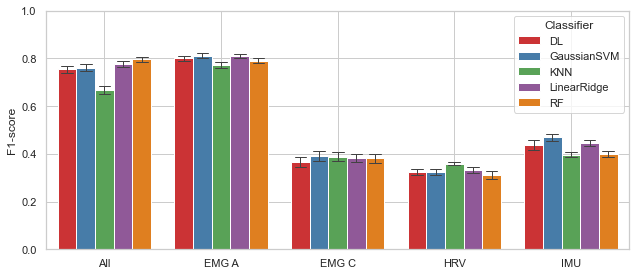

In [144]:
fig,axes = plt.subplots(1, 1, figsize=(9,4))
sns.set_style("whitegrid")
sns.barplot(ax = axes, data = df_temp_mean, x="Data Modality", y="F1-score", hue="Classifier",
                errorbar="sd", errwidth=1, capsize=0.1, palette="Set1")
# plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=4)
plt.xlabel(None)
plt.grid(True)
plt.ylim([0,1])

plt.tight_layout()
save_path_plot = gen_path_plot(f"results-classif-barplot-per-data-modality_25p")
plt.savefig(save_path_plot)

Best combination data modality/classifier per participant

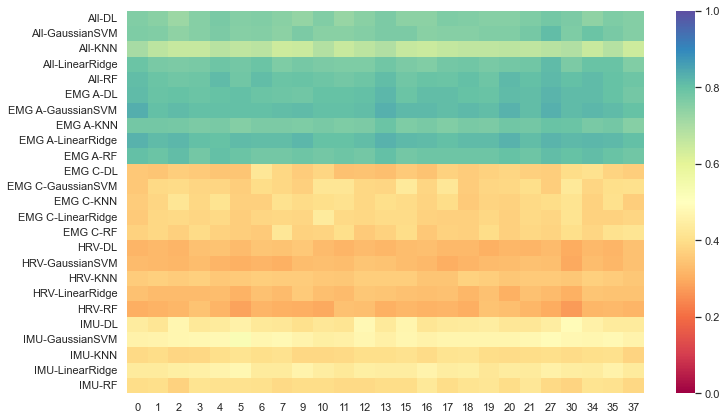

In [145]:
# F1-score per subject
fig,axes = plt.subplots(1, 1, figsize=(11,6))
df_heatmap = df_temp_mean.pivot(index=["Data Modality","Classifier"], columns="Subject", values="F1-score")
sns.heatmap(df_heatmap, ax=axes, cmap="Spectral", vmin=0, vmax=1)
plt.xlabel(None)
plt.ylabel(None)

plt.tight_layout()
save_path_plot = gen_path_plot(f"results-classif-heatmap-per-subject_25p")
plt.savefig(save_path_plot, bbox_inches='tight', pad_inches = 0)

In [146]:
print(">> FINISHED WITHOUT ERRORS!!")

>> FINISHED WITHOUT ERRORS!!
